In [44]:
%run ./DataGen2.ipynb

In [45]:
plt.rcParams.update({'font.size': 18})

In [46]:
class Standard_Param():
    def __init__(self, NumberOfClusters = 40):
        # Region of interest :
        self.x_lim = [0, 4] # micrometer
        self.y_lim = [0, 4]

        # Clusters :
        self.NumberOfClusters = NumberOfClusters
        self.LocPerCluster    = [24] * self.NumberOfClusters
        self.r                = [30] * self.NumberOfClusters # nm
        self.cluster_shape    = 'uniform'

        # Noise :
        self.NoisePercentage  = 0.5 # between 0 adnd 0.8
        self.UniformNoise     = True 
        
        # SMLM points : 
        self.mean_uncertainty      = 20
        self.dev_uncertainty       = 3
        self.N_photons             = 15000
        
        # Scales : 
        self.NumberOfScales   = 1
        
        # Random Seed 
        self.RandomSeed  = 0

In [47]:
def Call_DataGenerator(p):
    datagen = DataGenerator(x_lim = p.x_lim,
                        y_lim = p.y_lim,
                        NumberOfClusters = p.NumberOfClusters,
                        LocPerCluster = p.LocPerCluster,
                        r = p.r,
                        NoisePercentage = p.NoisePercentage,
                        NumberOfScales = p.NumberOfScales,
                        cluster_shape = p.cluster_shape,
                        UniformNoise = p.UniformNoise, 
                        mean_delta = p.mean_uncertainty, 
                        dev_delta = p.dev_uncertainty,
                        N_photons = p.N_photons,
                        RandomSeed = p.RandomSeed)
    return datagen

def compute_T(N, sigma_s = 40.0, x_lim = [0,4], y_lim = [0,4]):
    csr = CsrGenerator(N=N, x_lim = x_lim, y_lim = y_lim)
    data = csr.GetAllData()
    P = data[['x', 'y']].to_numpy() # select the coordinates columns, and transform into a numpy object
    truelabels = data['labels_1'].to_numpy()
    
    Sigma1          = np.ones((P.shape[0], 2, 2)) * 0
    Sigma1[:, 0, 1] = 0
    Sigma1[:, 1, 0] = 0
    n1              = np.ones((P.shape[0], 1)).ravel()
    
    density_csr, G0 = compute_density(P, Sigma1, sigma_s)
    
    # Computing the standard T 
    av = np.mean(density_csr)
    sd = np.std(density_csr)
    T = av + 2 * sd
    if (T>= 1):
        print('T = ', T, ' is bigger than 1. There is a problem. ')
        return 0.99
    see_histogram(density_csr, T, 'vertical method')
    
    # Computing the horizontal T
    histo = plt.hist(density_csr, bins = 50)
    min_ = min(histo[0])
    max_ = max(histo[0])
    v = min_ + (max_ - min_)/10

    T_h = 1 # default value in case it is not found
    for i, x in enumerate(histo[1]):
        if i>0:
            if (histo[0][i-1] <= v):
                T_h = histo[1][i]
                break
    see_histogram(density_csr, T_h, 'horizontal method')
    
    return T, T_h

def compute_T_90_95(N, sigma_s = 40.0, x_lim = [0,4], y_lim = [0,4]):
    csr = CsrGenerator(N=N, x_lim = x_lim, y_lim = y_lim)
    data = csr.GetAllData()
    P = data[['x', 'y']].to_numpy() # select the coordinates columns, and transform into a numpy object
    truelabels = data['labels_1'].to_numpy()
    
    Sigma1          = np.ones((P.shape[0], 2, 2)) * 0
    Sigma1[:, 0, 1] = 0
    Sigma1[:, 1, 0] = 0
    n1              = np.ones((P.shape[0], 1)).ravel()
    
    density_csr, G0 = compute_density(P, Sigma1, sigma_s)
    
    # Computing T for 90% and for 95% 
    T90 = np.quantile(density_csr, 0.90)
    T95 = np.quantile(density_csr, 0.95)
    
        
    see_histogram(density_csr, T90, '90')
    see_histogram(density_csr, T95, '95')
    
    return T90, T95

def compute_T_95(N, sigma_s = 40.0, x_lim = [0,4], y_lim = [0,4]):
    csr = CsrGenerator(N=N, x_lim = x_lim, y_lim = y_lim)
    data = csr.GetAllData()
    P = data[['x', 'y']].to_numpy() # select the coordinates columns, and transform into a numpy object
    truelabels = data['labels_1'].to_numpy()
    
    Sigma1          = np.ones((P.shape[0], 2, 2)) * 0
    Sigma1[:, 0, 1] = 0
    Sigma1[:, 1, 0] = 0
    n1              = np.ones((P.shape[0], 1)).ravel()
    
    density_csr, G0 = compute_density(P, Sigma1, sigma_s)
    
    # Computing T 
    T = np.quantile(density_csr, 0.95)
        
    see_histogram(density_csr, T, '0.95 quantile')
    
    return T

<Figure size 720x576 with 0 Axes>

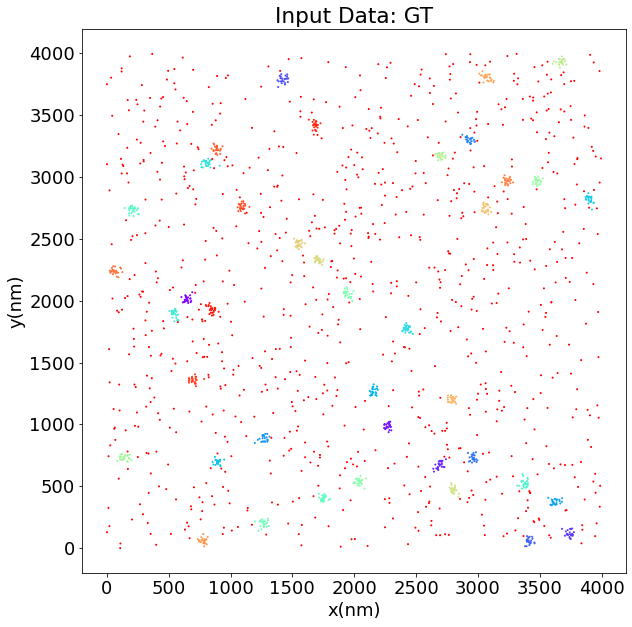

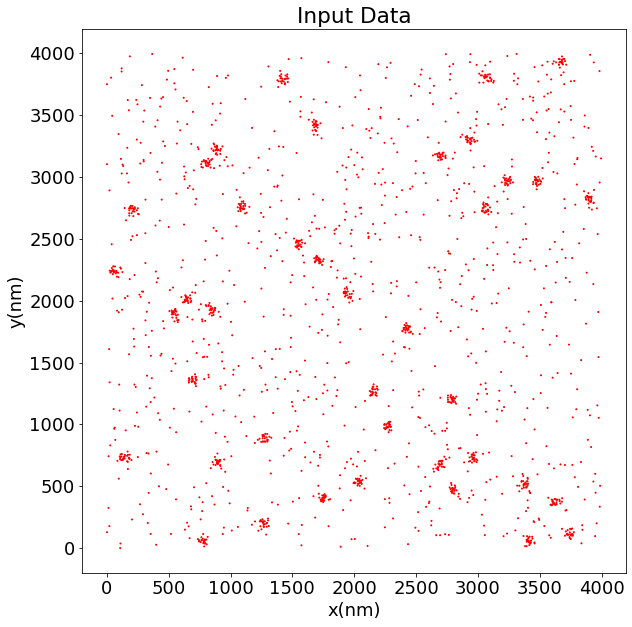

In [50]:
plt.rcParams.update({'font.size': 18})
p = Standard_Param()
p.RandomSeed = 22
datagen = Call_DataGenerator(p)
plt.figure(figsize=(10,8))
datagen.plot_points()

<Figure size 720x576 with 0 Axes>

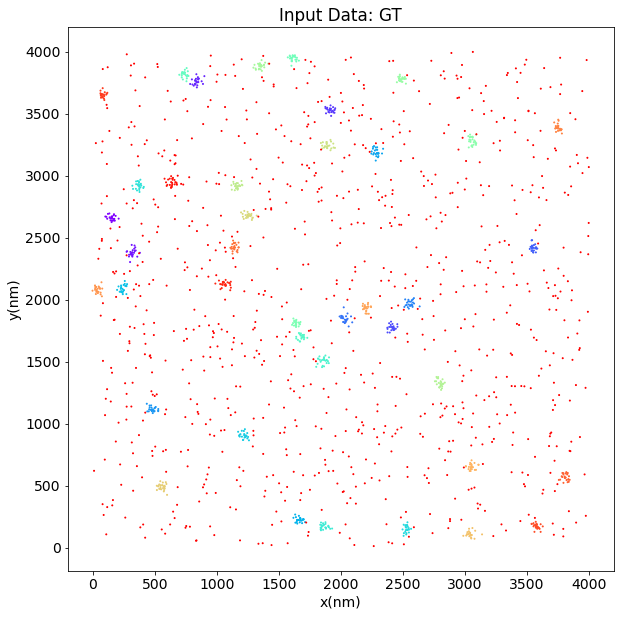

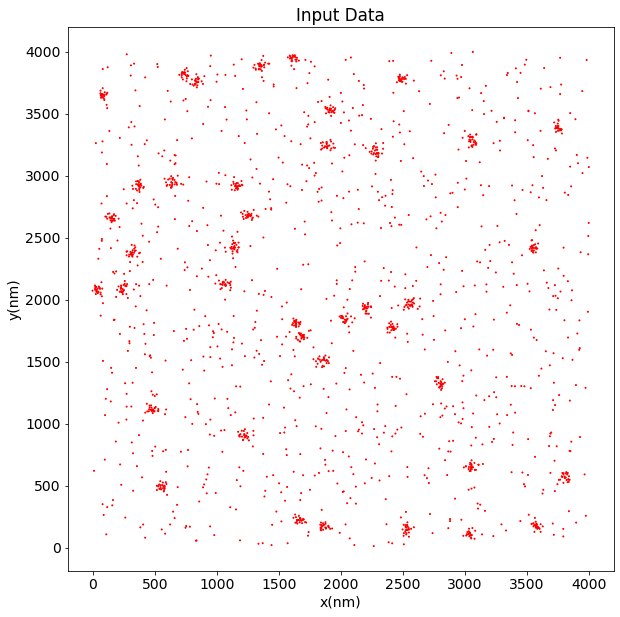

In [28]:
plt.rcParams.update({'font.size': 18})
p = Standard_Param()
p.RandomSeed = True
datagen = Call_DataGenerator(p)
plt.figure(figsize=(10,8))
datagen.plot_points()

In [7]:
saving_path = '/Users/Eliana/Documents/PDM/Codes/My_codes/automatic_T/'

(Text(0.5, 0, 'x [nm]'), Text(0, 0.5, 'y [nm]'))

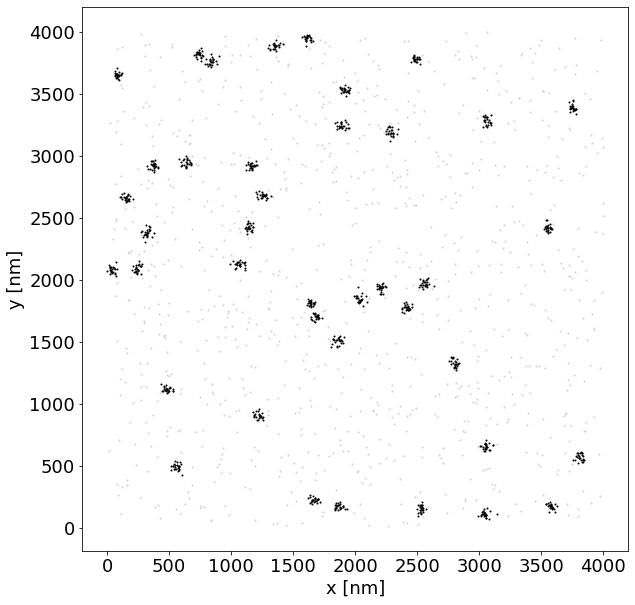

In [99]:
plt.rcParams.update({'font.size': 18})

filename   = 'standard_GT'
P              = np.asarray(datagen.GetPointsCoord())
labels         = np.asarray(datagen.GetPointsLabels())


not_noise_idx = np.where(labels != 0)
noise_idx = np.where(labels == 0)

plt.figure(figsize = (10,10))
plt.scatter(P[noise_idx,0], P[noise_idx,1], c = 'lightgray', s = 1)
#plt.scatter(P[not_noise_idx, 0], P[not_noise_idx, 1], c = labels[not_noise_idx], cmap = 'rainbow_r', s = 1)
plt.scatter(P[not_noise_idx, 0], P[not_noise_idx, 1], c = 'black', s = 1)
plt.gca().set_aspect('equal')
plt.xlabel('x [nm]'), plt.ylabel('y [nm]')

#plt.savefig(saving_path + filename + '.pdf')


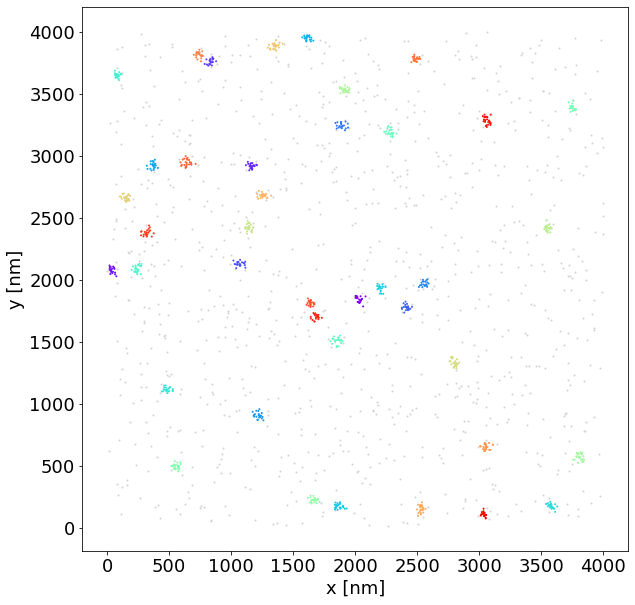

In [94]:
plt.rcParams.update({'font.size': 18})

filename   = 'graphic_result'
P              = datagen.GetPointsCoord()

plt.figure(figsize = (10,10))

not_noise_idx = np.where(labels_clean != 0)
noise_idx = np.where(labels_clean == 0)


plt.scatter(P[noise_idx,0], P[noise_idx,1], c = 'lightgray', s = 1)
plt.scatter(P[not_noise_idx, 0], P[not_noise_idx, 1], c = labels_clean[not_noise_idx], cmap = 'rainbow_r', s = 1)
plt.gca().set_aspect('equal')
plt.xlabel('x [nm]'), plt.ylabel('y [nm]')

plt.savefig(saving_path + filename + '.pdf')

(Text(0.5, 0, 'x[nm]'), Text(0, 0.5, 'y[nm]'))

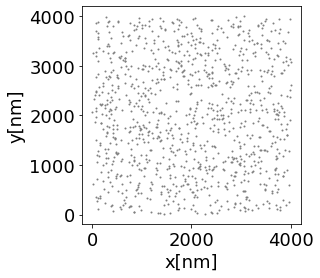

In [82]:
noise_i = np.where(labels_clean == 0)


plt.scatter(P[noise_i,0], P[noise_i,1], c = 'gray', s = 1)

plt.gca().set_aspect('equal')
plt.xlabel('x[nm]'), plt.ylabel('y[nm]')



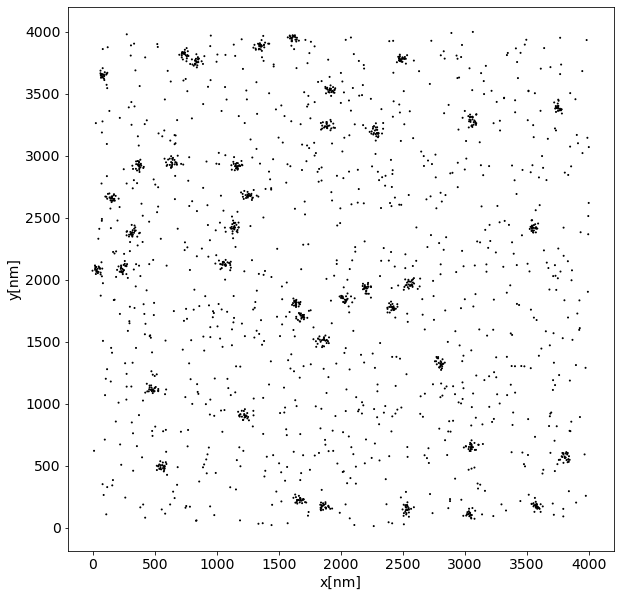

In [31]:
plt.rcParams.update({'font.size': 18})

filename   = 'standard'
P              = datagen.GetPointsCoord()
labels         = datagen.GetPointsLabels()

plt.figure(figsize = (10,10))

new_labels = ['black' for lab in labels]

plt.scatter(P[:,0], P[:,1], c = new_labels, s = 1)
plt.gca().set_aspect('equal')
plt.xlabel('x[nm]'), plt.ylabel('y[nm]')

plt.savefig(saving_path + filename + '.pdf')

In [32]:
N = len(datagen.GetPoints())
csr = CsrGenerator(N = N, x_lim = [0,4], y_lim = [0,4])
Sigma = datagen.GetPointsCovMatrix()

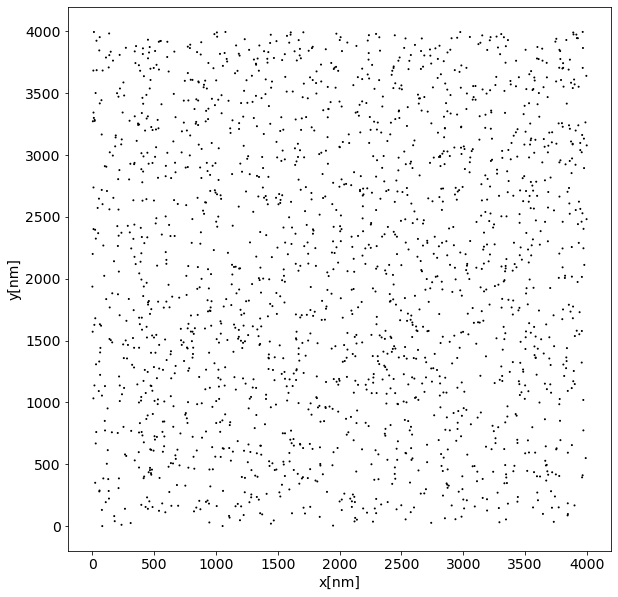

In [34]:
filename      = 'csr'
Pcsr          = csr.GetPointsCoord()

plt.figure(figsize = (10,10))

new_labels = ['black' for i in Pcsr]

plt.scatter(Pcsr[:,0], Pcsr[:,1], c = new_labels, s = 1)
plt.gca().set_aspect('equal')
plt.xlabel('x[nm]'), plt.ylabel('y[nm]')

plt.savefig(saving_path + filename + '.pdf')

In [35]:
sigma_s = 32

In [124]:
%run ./DataGen2.ipynb

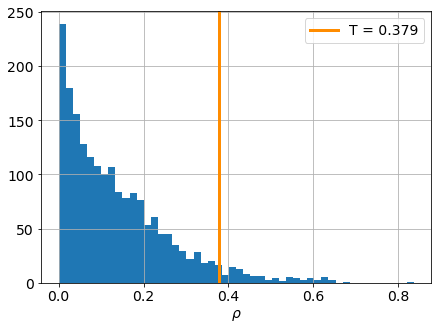

In [55]:
T = compute_T_95(N, Sigma,  sigma_s = sigma_s, x_lim = [0,4], y_lim = [0,4])

In [51]:
plt.savefig(saving_path + 'T_csr'+ '.pdf')

<Figure size 432x288 with 0 Axes>

In [64]:
df = datagen.GetAllData()
P = df[['x', 'y']].to_numpy()
Sigma = np.asarray(datagen.GetPointsCovMatrix())
density, G = compute_density(P, Sigma, sigma_s)

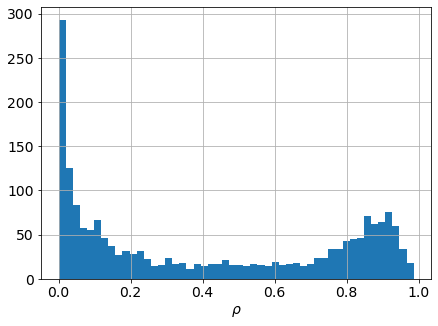

In [65]:
plt.figure(figsize = (7,5))
plt.hist(density, bins = 50)
plt.xlabel(r'$\rho$')
plt.grid()
plt.savefig(saving_path + 'histo'+ '.pdf')

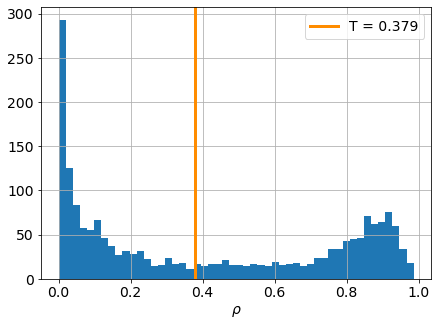

In [66]:
see_histogram(density, T, '')

La prochaine cellule est une démonstration pour le standard, cette fois ci avec les incertitudes prises en compte. 

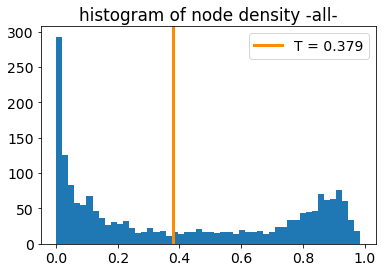

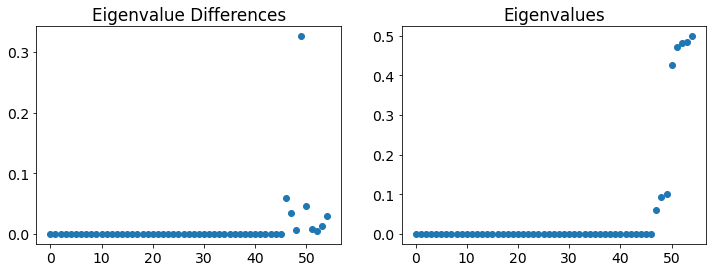

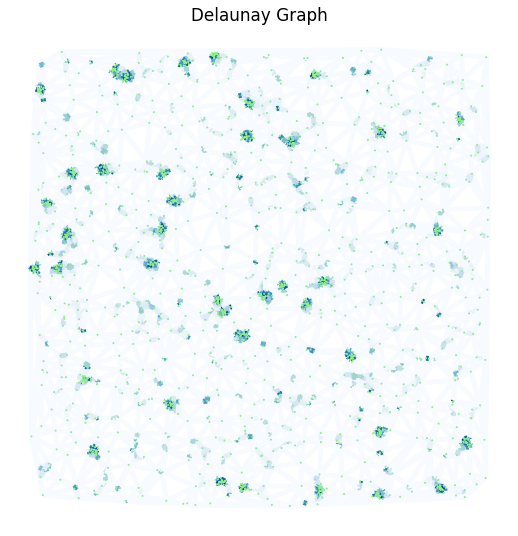

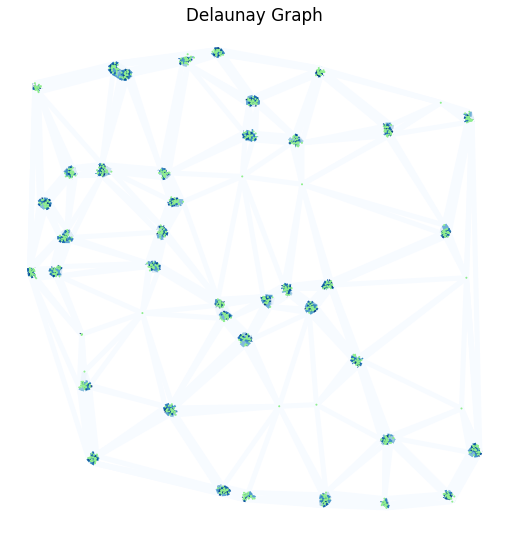

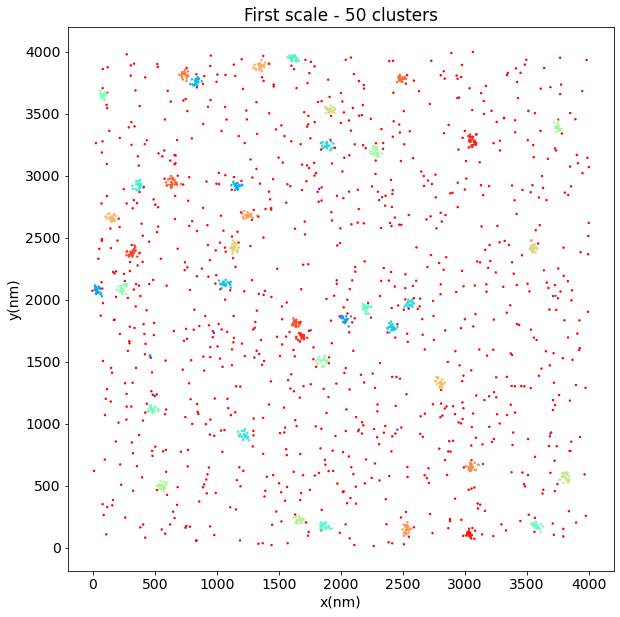

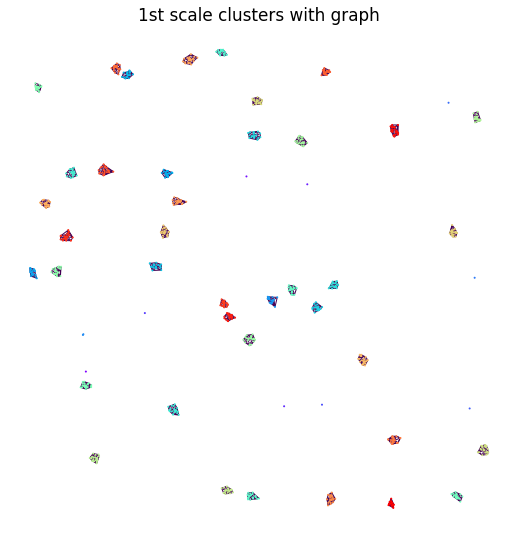

In [67]:
# thershold vertical 
labels = calling_graphic(df, sigma_s, T)

#threshold horizontal 
#calling_graphic(df, sigma_s, hT)

In [68]:
labels_clean = remove_small_clusters(labels, 5)

In [69]:
#GT = datagen.GetAllData()
truelabels = np.asarray(datagen.GetPointsLabels())
#truelabels = GT['labels_1'].to_numpy()

In [115]:
FMI  = metrics.fowlkes_mallows_score(truelabels, labels_clean)

In [31]:
#J = metrics.jaccard_score(truelabels, labels_clean)

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [116]:
FMI

0.9530323275460869

In [117]:
NumberOfClusters_graphic = len(np.unique(labels_clean))-1
print(NumberOfClusters_graphic)

40


# T en fonction du nombre de N, pour plusieurs sigmas. 

0.8725188370772616


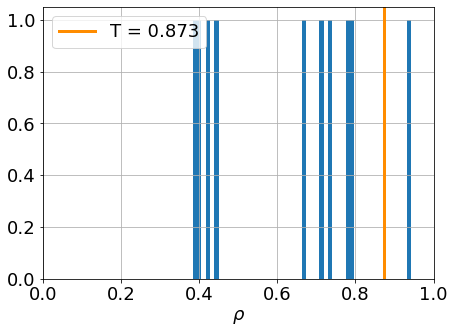

In [117]:
N = 10
sigma_s = 32
uncertainties = np.random.normal(20, 3, N)
cov_matrices = [ np.array([[u**2, 0], [0, u**2]]) for u in uncertainties]

T = compute_T_95(N, cov_matrices, sigma_s = sigma_s, x_lim = [0,0.1], y_lim = [0, 0.1])
print(T)

In [4]:
Ns = np.arange(600, 3001, 400)

sigma_ss = [20, 70, 120, 170]

n_sim = 30

In [5]:
all_T_sd = []
all_T_av = []

for sigma_s in sigma_ss:
    print(sigma_s)
    T_N_sd = []
    T_N_av = []
    for N in Ns:
        uncertainties = np.random.normal(20, 3, N)
        cov_matrices = [ np.array([[u**2, 0], [0, u**2]]) for u in uncertainties]
        print('N = ', N)
        Ts = []
        for i in range(n_sim):
            T = compute_T_95(N, cov_matrices, sigma_s, x_lim = [0,4], y_lim = [0,4])
            Ts.append(T)
            print('Ts = ', Ts)
        Ts    = np.asarray(Ts)
        print('Ts array = ', Ts)
        T_std = np.std(Ts)/ np.sqrt(n_sim) * 1.96
        print('T_std = ', T_std)
        T_avg = np.mean(Ts)

        T_N_sd.append(T_std)
        T_N_av.append(T_avg)
    all_T_sd.append(T_N_sd)
    all_T_av.append(T_N_av)
    

20
N =  600
Ts =  [0.09395195838720803]
Ts =  [0.09395195838720803, 0.12634238091436575]
Ts =  [0.09395195838720803, 0.12634238091436575, 0.11903084451609791]
Ts =  [0.09395195838720803, 0.12634238091436575, 0.11903084451609791, 0.10314932014099173]
Ts =  [0.09395195838720803, 0.12634238091436575, 0.11903084451609791, 0.10314932014099173, 0.07871596703879082]
Ts =  [0.09395195838720803, 0.12634238091436575, 0.11903084451609791, 0.10314932014099173, 0.07871596703879082, 0.10992478181503805]
Ts =  [0.09395195838720803, 0.12634238091436575, 0.11903084451609791, 0.10314932014099173, 0.07871596703879082, 0.10992478181503805, 0.12596472018776528]
Ts =  [0.09395195838720803, 0.12634238091436575, 0.11903084451609791, 0.10314932014099173, 0.07871596703879082, 0.10992478181503805, 0.12596472018776528, 0.12498242929249381]
Ts =  [0.09395195838720803, 0.12634238091436575, 0.11903084451609791, 0.10314932014099173, 0.07871596703879082, 0.10992478181503805, 0.12596472018776528, 0.12498242929249381, 0

Ts =  [0.09395195838720803, 0.12634238091436575, 0.11903084451609791, 0.10314932014099173, 0.07871596703879082, 0.10992478181503805, 0.12596472018776528, 0.12498242929249381, 0.12204037557581313, 0.12340951997454526, 0.12753317742888653, 0.12523682683380782, 0.10611872719784293, 0.12400669710050577, 0.10104498514303968, 0.12839894144636788, 0.12530419131660403, 0.13295554456571193, 0.11694883309896752, 0.12333631826373281, 0.10498133525664008, 0.11834012060086413, 0.10760127297506178, 0.13014308487058007, 0.11113155009639221, 0.12882696888298972, 0.13209214498735697, 0.12937088653868503, 0.11536589404833741]
Ts =  [0.09395195838720803, 0.12634238091436575, 0.11903084451609791, 0.10314932014099173, 0.07871596703879082, 0.10992478181503805, 0.12596472018776528, 0.12498242929249381, 0.12204037557581313, 0.12340951997454526, 0.12753317742888653, 0.12523682683380782, 0.10611872719784293, 0.12400669710050577, 0.10104498514303968, 0.12839894144636788, 0.12530419131660403, 0.13295554456571193,

Ts =  [0.14484554538314642, 0.14049941350780715, 0.14275093238265263, 0.15422655394918247, 0.14600420404663084, 0.13814786817154973, 0.16606588674659853, 0.13990567950159036, 0.1730331483787299, 0.12936160849904305, 0.16060325733939762, 0.14787664457003394, 0.15322188594038585, 0.13736745094517158, 0.16564674955115835, 0.14702991641954224, 0.15656327325486077, 0.15119505332275365, 0.15160723498824338, 0.14686863348228937, 0.14904262313317923, 0.1440455629929733, 0.16745798173053653, 0.14753182490886965, 0.1471655271193183, 0.16293396251891215]
Ts =  [0.14484554538314642, 0.14049941350780715, 0.14275093238265263, 0.15422655394918247, 0.14600420404663084, 0.13814786817154973, 0.16606588674659853, 0.13990567950159036, 0.1730331483787299, 0.12936160849904305, 0.16060325733939762, 0.14787664457003394, 0.15322188594038585, 0.13736745094517158, 0.16564674955115835, 0.14702991641954224, 0.15656327325486077, 0.15119505332275365, 0.15160723498824338, 0.14686863348228937, 0.14904262313317923, 0.1

Ts =  [0.19441124980795824, 0.18919335052606626, 0.18660587896671865, 0.16910198062628495, 0.2066872239687531, 0.1907012217791415, 0.162925215461563, 0.17917916178925847, 0.17846701816587984, 0.18346692071496146, 0.17473343002775762, 0.18037632703147255, 0.17089457778617942, 0.18397206907237584, 0.1827929851106831, 0.18240986980456586, 0.20263356874091756, 0.18618047489418083, 0.17196771020349955, 0.1767425232049819, 0.19231667622720922, 0.17535186882776166]
Ts =  [0.19441124980795824, 0.18919335052606626, 0.18660587896671865, 0.16910198062628495, 0.2066872239687531, 0.1907012217791415, 0.162925215461563, 0.17917916178925847, 0.17846701816587984, 0.18346692071496146, 0.17473343002775762, 0.18037632703147255, 0.17089457778617942, 0.18397206907237584, 0.1827929851106831, 0.18240986980456586, 0.20263356874091756, 0.18618047489418083, 0.17196771020349955, 0.1767425232049819, 0.19231667622720922, 0.17535186882776166, 0.16160524507304685]
Ts =  [0.19441124980795824, 0.18919335052606626, 0.18

Ts =  [0.20931418941870544, 0.1931144088477122, 0.20076555670650892, 0.1882104597323177, 0.2160183383426245, 0.19964183175066366, 0.21507725475254827, 0.2090472449848209, 0.20398002639688131, 0.19831959129566706, 0.21550556066869844, 0.19888476506445868, 0.19221627443434783, 0.2082924202477035, 0.193733865809051, 0.20193014242672025, 0.2129362771491228]
Ts =  [0.20931418941870544, 0.1931144088477122, 0.20076555670650892, 0.1882104597323177, 0.2160183383426245, 0.19964183175066366, 0.21507725475254827, 0.2090472449848209, 0.20398002639688131, 0.19831959129566706, 0.21550556066869844, 0.19888476506445868, 0.19221627443434783, 0.2082924202477035, 0.193733865809051, 0.20193014242672025, 0.2129362771491228, 0.1971815254895713]
Ts =  [0.20931418941870544, 0.1931144088477122, 0.20076555670650892, 0.1882104597323177, 0.2160183383426245, 0.19964183175066366, 0.21507725475254827, 0.2090472449848209, 0.20398002639688131, 0.19831959129566706, 0.21550556066869844, 0.19888476506445868, 0.19221627443

Ts =  [0.24443851679064185, 0.21799264714212443, 0.21758768366024153, 0.22893412279064204, 0.22418150083819172, 0.25082134940859946, 0.2486447086766147, 0.2197162152117122, 0.23757757236961868, 0.2294116996276134]
Ts =  [0.24443851679064185, 0.21799264714212443, 0.21758768366024153, 0.22893412279064204, 0.22418150083819172, 0.25082134940859946, 0.2486447086766147, 0.2197162152117122, 0.23757757236961868, 0.2294116996276134, 0.23158573402882124]
Ts =  [0.24443851679064185, 0.21799264714212443, 0.21758768366024153, 0.22893412279064204, 0.22418150083819172, 0.25082134940859946, 0.2486447086766147, 0.2197162152117122, 0.23757757236961868, 0.2294116996276134, 0.23158573402882124, 0.21348754415000276]
Ts =  [0.24443851679064185, 0.21799264714212443, 0.21758768366024153, 0.22893412279064204, 0.22418150083819172, 0.25082134940859946, 0.2486447086766147, 0.2197162152117122, 0.23757757236961868, 0.2294116996276134, 0.23158573402882124, 0.21348754415000276, 0.22091517535746655]
Ts =  [0.244438516

Ts =  [0.24443851679064185, 0.21799264714212443, 0.21758768366024153, 0.22893412279064204, 0.22418150083819172, 0.25082134940859946, 0.2486447086766147, 0.2197162152117122, 0.23757757236961868, 0.2294116996276134, 0.23158573402882124, 0.21348754415000276, 0.22091517535746655, 0.23577307715672172, 0.23700875541559638, 0.2102965517065306, 0.2534772521784196, 0.2271104629588915, 0.22221223818472816, 0.22579293370207226, 0.22814821646650793, 0.22190968045653856, 0.22972831356576429, 0.23436781174113952, 0.22719954360269354, 0.24518665684906868, 0.21760566272568177, 0.22073013260015006, 0.2360175102981284, 0.222423812937031]
Ts array =  [0.24443852 0.21799265 0.21758768 0.22893412 0.2241815  0.25082135
 0.24864471 0.21971622 0.23757757 0.2294117  0.23158573 0.21348754
 0.22091518 0.23577308 0.23700876 0.21029655 0.25347725 0.22711046
 0.22221224 0.22579293 0.22814822 0.22190968 0.22972831 0.23436781
 0.22719954 0.24518666 0.21760566 0.22073013 0.23601751 0.22242381]
T_std =  0.0039196500988

Ts =  [0.24949567219131144, 0.24854577417369428, 0.24416823421186046, 0.24711635438948779, 0.25170524280809625, 0.24948379291972003, 0.25701305896446736, 0.2509751598355611, 0.2344626063609005, 0.2617566697996982, 0.25073266255523846, 0.24465018103163882, 0.2569466397908347, 0.2504542035621255, 0.2520880419377559, 0.24595856134568694, 0.23554061633424067, 0.2520364253200493, 0.2644206413557494, 0.2307957008688242, 0.24743564574536808, 0.24334875428966876, 0.25327564682010156, 0.24862274585361527, 0.2606300203725387, 0.2538347277090389, 0.24177942665701516]
Ts =  [0.24949567219131144, 0.24854577417369428, 0.24416823421186046, 0.24711635438948779, 0.25170524280809625, 0.24948379291972003, 0.25701305896446736, 0.2509751598355611, 0.2344626063609005, 0.2617566697996982, 0.25073266255523846, 0.24465018103163882, 0.2569466397908347, 0.2504542035621255, 0.2520880419377559, 0.24595856134568694, 0.23554061633424067, 0.2520364253200493, 0.2644206413557494, 0.2307957008688242, 0.24743564574536808

Ts =  [0.28098061062281476, 0.275066913130494, 0.2667524793683618, 0.2621612249618622, 0.271743835227163, 0.2816693956039326, 0.2742936292345078, 0.2533800041324754, 0.2838142133096772, 0.2632736406714876, 0.2684601789803238, 0.26422541945335987, 0.2682117564390275, 0.29138105248779106, 0.2821749250192322, 0.2698138374213423, 0.2761177804573349, 0.2814542625140171, 0.2409647894202456, 0.27131427964836574, 0.27557227017530617, 0.27908129330599496, 0.27358662301127107, 0.28800449983617904]
Ts =  [0.28098061062281476, 0.275066913130494, 0.2667524793683618, 0.2621612249618622, 0.271743835227163, 0.2816693956039326, 0.2742936292345078, 0.2533800041324754, 0.2838142133096772, 0.2632736406714876, 0.2684601789803238, 0.26422541945335987, 0.2682117564390275, 0.29138105248779106, 0.2821749250192322, 0.2698138374213423, 0.2761177804573349, 0.2814542625140171, 0.2409647894202456, 0.27131427964836574, 0.27557227017530617, 0.27908129330599496, 0.27358662301127107, 0.28800449983617904, 0.281445779731

Ts =  [0.4620946685614101, 0.48801812119414767, 0.4610308850163231, 0.44649857418812766, 0.4685406773160312, 0.45085365386352827, 0.46157335273833067, 0.4485274652051385, 0.44942852206382644, 0.42408093964420057, 0.4404285321246154, 0.4624457477301095, 0.41887290455720344, 0.46708480613224307, 0.4771204132860776, 0.4488476869258706, 0.46840320992135415, 0.4587370991230066, 0.4534227127675192, 0.4088478947711241]
Ts =  [0.4620946685614101, 0.48801812119414767, 0.4610308850163231, 0.44649857418812766, 0.4685406773160312, 0.45085365386352827, 0.46157335273833067, 0.4485274652051385, 0.44942852206382644, 0.42408093964420057, 0.4404285321246154, 0.4624457477301095, 0.41887290455720344, 0.46708480613224307, 0.4771204132860776, 0.4488476869258706, 0.46840320992135415, 0.4587370991230066, 0.4534227127675192, 0.4088478947711241, 0.4614916875071768]
Ts =  [0.4620946685614101, 0.48801812119414767, 0.4610308850163231, 0.44649857418812766, 0.4685406773160312, 0.45085365386352827, 0.4615733527383306

Ts =  [0.5592556629540593, 0.5763516664851539, 0.5749814916658673, 0.5439655350129178, 0.6201586686163583, 0.5562927947435914, 0.5887911462259564, 0.5632831100826939, 0.5859868952280429, 0.5857097914005008, 0.5998420073626587, 0.5747654061187709, 0.5731227835608529, 0.5693327385704336, 0.5920209739582004]
Ts =  [0.5592556629540593, 0.5763516664851539, 0.5749814916658673, 0.5439655350129178, 0.6201586686163583, 0.5562927947435914, 0.5887911462259564, 0.5632831100826939, 0.5859868952280429, 0.5857097914005008, 0.5998420073626587, 0.5747654061187709, 0.5731227835608529, 0.5693327385704336, 0.5920209739582004, 0.5952927552862756]
Ts =  [0.5592556629540593, 0.5763516664851539, 0.5749814916658673, 0.5439655350129178, 0.6201586686163583, 0.5562927947435914, 0.5887911462259564, 0.5632831100826939, 0.5859868952280429, 0.5857097914005008, 0.5998420073626587, 0.5747654061187709, 0.5731227835608529, 0.5693327385704336, 0.5920209739582004, 0.5952927552862756, 0.5689352263602845]
Ts =  [0.5592556629

Ts =  [0.6637003930811859, 0.6419950796695489, 0.6537801121503091, 0.6541646854322269, 0.6546303811579262, 0.632949336034381, 0.6691939320773524, 0.6762381121889195]
Ts =  [0.6637003930811859, 0.6419950796695489, 0.6537801121503091, 0.6541646854322269, 0.6546303811579262, 0.632949336034381, 0.6691939320773524, 0.6762381121889195, 0.6506281609231874]
Ts =  [0.6637003930811859, 0.6419950796695489, 0.6537801121503091, 0.6541646854322269, 0.6546303811579262, 0.632949336034381, 0.6691939320773524, 0.6762381121889195, 0.6506281609231874, 0.6571866699245865]
Ts =  [0.6637003930811859, 0.6419950796695489, 0.6537801121503091, 0.6541646854322269, 0.6546303811579262, 0.632949336034381, 0.6691939320773524, 0.6762381121889195, 0.6506281609231874, 0.6571866699245865, 0.6598874410695337]
Ts =  [0.6637003930811859, 0.6419950796695489, 0.6537801121503091, 0.6541646854322269, 0.6546303811579262, 0.632949336034381, 0.6691939320773524, 0.6762381121889195, 0.6506281609231874, 0.6571866699245865, 0.65988744

Ts =  [0.6637003930811859, 0.6419950796695489, 0.6537801121503091, 0.6541646854322269, 0.6546303811579262, 0.632949336034381, 0.6691939320773524, 0.6762381121889195, 0.6506281609231874, 0.6571866699245865, 0.6598874410695337, 0.6458468625023256, 0.667466919337774, 0.641671041138433, 0.6439350403444395, 0.6334124267285872, 0.6647031557975925, 0.6556295221545331, 0.6304503863122796, 0.6680668935518189, 0.6630601408916581, 0.6434151040754849, 0.6600316524766303, 0.645730088022478, 0.6580932420556768, 0.6614028848016508, 0.6656199944476096, 0.6676483745237374, 0.6829722011220816, 0.6477253060482282]
Ts array =  [0.66370039 0.64199508 0.65378011 0.65416469 0.65463038 0.63294934
 0.66919393 0.67623811 0.65062816 0.65718667 0.65988744 0.64584686
 0.66746692 0.64167104 0.64393504 0.63341243 0.66470316 0.65562952
 0.63045039 0.66806689 0.66306014 0.6434151  0.66003165 0.64573009
 0.65809324 0.66140288 0.66561999 0.66764837 0.6829722  0.64772531]
T_std =  0.004513155002746104
N =  1800
Ts =  [0.

Ts =  [0.6998136018565744, 0.7113637918288572, 0.696384632638398, 0.7264724449362571, 0.7304005347328324, 0.7119862108477735, 0.7057302717890531, 0.7093513658349069, 0.6977999982698564, 0.7224094210230915, 0.7009647918972904, 0.7112902313677183, 0.7170369858078199, 0.6970223986800361, 0.6911865537565433, 0.7019136228526319, 0.68789162968316, 0.7132553723098988, 0.7131825004102968, 0.6946235184367304, 0.698837883833904, 0.7050628952990609, 0.7138612212735513, 0.7193480261258773, 0.7285154480726532, 0.6952348031118087, 0.7338135857979872, 0.697211840085613]
Ts =  [0.6998136018565744, 0.7113637918288572, 0.696384632638398, 0.7264724449362571, 0.7304005347328324, 0.7119862108477735, 0.7057302717890531, 0.7093513658349069, 0.6977999982698564, 0.7224094210230915, 0.7009647918972904, 0.7112902313677183, 0.7170369858078199, 0.6970223986800361, 0.6911865537565433, 0.7019136228526319, 0.68789162968316, 0.7132553723098988, 0.7131825004102968, 0.6946235184367304, 0.698837883833904, 0.7050628952990

Ts =  [0.7513603294099809, 0.7588132521858479, 0.7589499128894703, 0.7458956336045768, 0.739278758821243, 0.7305126355329191, 0.7524137047329091, 0.764169870170895, 0.7587185905839093, 0.7317871257279914, 0.7662397845267872, 0.7458288141807512, 0.7563956952326698, 0.7639835046124475, 0.7418116337298927, 0.7592155992169223, 0.7426743786774602, 0.7511883519663263, 0.7474246126334366, 0.7791670293570241, 0.7508365550794641, 0.7413762406577284, 0.7620023964166923, 0.7464233238781065, 0.7511218146671135]
Ts =  [0.7513603294099809, 0.7588132521858479, 0.7589499128894703, 0.7458956336045768, 0.739278758821243, 0.7305126355329191, 0.7524137047329091, 0.764169870170895, 0.7587185905839093, 0.7317871257279914, 0.7662397845267872, 0.7458288141807512, 0.7563956952326698, 0.7639835046124475, 0.7418116337298927, 0.7592155992169223, 0.7426743786774602, 0.7511883519663263, 0.7474246126334366, 0.7791670293570241, 0.7508365550794641, 0.7413762406577284, 0.7620023964166923, 0.7464233238781065, 0.75112181

Ts =  [0.779010723155809, 0.7920852689142514, 0.7974437951187648, 0.7759232657159568, 0.7814511552601908, 0.7804230749151196, 0.7879837768380452, 0.7615940343926624, 0.78118888682082, 0.7886873944653983, 0.7885275389004177, 0.7818007766657387, 0.782364010977949, 0.7857181476395367, 0.7805872100824391, 0.7835400278324524, 0.783822272814274, 0.7809914129754353, 0.7805834110652203, 0.7762465428060722, 0.7844852538844264, 0.7823649780058434]
Ts =  [0.779010723155809, 0.7920852689142514, 0.7974437951187648, 0.7759232657159568, 0.7814511552601908, 0.7804230749151196, 0.7879837768380452, 0.7615940343926624, 0.78118888682082, 0.7886873944653983, 0.7885275389004177, 0.7818007766657387, 0.782364010977949, 0.7857181476395367, 0.7805872100824391, 0.7835400278324524, 0.783822272814274, 0.7809914129754353, 0.7805834110652203, 0.7762465428060722, 0.7844852538844264, 0.7823649780058434, 0.7838320649438194]
Ts =  [0.779010723155809, 0.7920852689142514, 0.7974437951187648, 0.7759232657159568, 0.78145115

Ts =  [0.7978619727430821, 0.8093641667078356, 0.8110312968396113, 0.7994632996449803, 0.808271689194339, 0.805735990405103, 0.8186839116633633, 0.8017380514956172, 0.8064152565555143, 0.8032469377900947, 0.8020064683049875, 0.8047245909658022, 0.8121348267135401, 0.811961067078015, 0.8036014836812727, 0.793903433357421, 0.8113247844844934, 0.8059249286477654]
Ts =  [0.7978619727430821, 0.8093641667078356, 0.8110312968396113, 0.7994632996449803, 0.808271689194339, 0.805735990405103, 0.8186839116633633, 0.8017380514956172, 0.8064152565555143, 0.8032469377900947, 0.8020064683049875, 0.8047245909658022, 0.8121348267135401, 0.811961067078015, 0.8036014836812727, 0.793903433357421, 0.8113247844844934, 0.8059249286477654, 0.7957808754895271]
Ts =  [0.7978619727430821, 0.8093641667078356, 0.8110312968396113, 0.7994632996449803, 0.808271689194339, 0.805735990405103, 0.8186839116633633, 0.8017380514956172, 0.8064152565555143, 0.8032469377900947, 0.8020064683049875, 0.8047245909658022, 0.8121348

Ts =  [0.7331182917632598, 0.7171339287918901, 0.6940216117613982, 0.7080919586421279, 0.7132131490176531, 0.7352429877453999, 0.711863906947839, 0.7066545749655733, 0.7024692118376008, 0.7121620312532543, 0.6910100328573077, 0.6975726909778817, 0.7048765142004928]
Ts =  [0.7331182917632598, 0.7171339287918901, 0.6940216117613982, 0.7080919586421279, 0.7132131490176531, 0.7352429877453999, 0.711863906947839, 0.7066545749655733, 0.7024692118376008, 0.7121620312532543, 0.6910100328573077, 0.6975726909778817, 0.7048765142004928, 0.6987333541482206]
Ts =  [0.7331182917632598, 0.7171339287918901, 0.6940216117613982, 0.7080919586421279, 0.7132131490176531, 0.7352429877453999, 0.711863906947839, 0.7066545749655733, 0.7024692118376008, 0.7121620312532543, 0.6910100328573077, 0.6975726909778817, 0.7048765142004928, 0.6987333541482206, 0.6971379244961363]
Ts =  [0.7331182917632598, 0.7171339287918901, 0.6940216117613982, 0.7080919586421279, 0.7132131490176531, 0.7352429877453999, 0.7118639069478

Ts =  [0.7939190619848304]
Ts =  [0.7939190619848304, 0.8134421980959535]
Ts =  [0.7939190619848304, 0.8134421980959535, 0.7894338476529895]
Ts =  [0.7939190619848304, 0.8134421980959535, 0.7894338476529895, 0.8057736089094439]
Ts =  [0.7939190619848304, 0.8134421980959535, 0.7894338476529895, 0.8057736089094439, 0.8081591088303532]
Ts =  [0.7939190619848304, 0.8134421980959535, 0.7894338476529895, 0.8057736089094439, 0.8081591088303532, 0.798480126874422]
Ts =  [0.7939190619848304, 0.8134421980959535, 0.7894338476529895, 0.8057736089094439, 0.8081591088303532, 0.798480126874422, 0.8264550676049857]
Ts =  [0.7939190619848304, 0.8134421980959535, 0.7894338476529895, 0.8057736089094439, 0.8081591088303532, 0.798480126874422, 0.8264550676049857, 0.7906996937366895]
Ts =  [0.7939190619848304, 0.8134421980959535, 0.7894338476529895, 0.8057736089094439, 0.8081591088303532, 0.798480126874422, 0.8264550676049857, 0.7906996937366895, 0.8101598600905737]
Ts =  [0.7939190619848304, 0.813442198095

Ts =  [0.7939190619848304, 0.8134421980959535, 0.7894338476529895, 0.8057736089094439, 0.8081591088303532, 0.798480126874422, 0.8264550676049857, 0.7906996937366895, 0.8101598600905737, 0.792382523356096, 0.8050171384910494, 0.7916144704831309, 0.8025598948312481, 0.795228689502731, 0.795805844790779, 0.8152594340475808, 0.7941449889231466, 0.8196004983317746, 0.8020718488709587, 0.7970209504914814, 0.8158022858693704, 0.7907124258283458, 0.7914191831675412, 0.8261640559953258, 0.800032616163625, 0.7902485799897379, 0.7806009550026519, 0.8058604708000319, 0.8070679359992299]
Ts =  [0.7939190619848304, 0.8134421980959535, 0.7894338476529895, 0.8057736089094439, 0.8081591088303532, 0.798480126874422, 0.8264550676049857, 0.7906996937366895, 0.8101598600905737, 0.792382523356096, 0.8050171384910494, 0.7916144704831309, 0.8025598948312481, 0.795228689502731, 0.795805844790779, 0.8152594340475808, 0.7941449889231466, 0.8196004983317746, 0.8020718488709587, 0.7970209504914814, 0.8158022858693

Ts =  [0.8489541683811378, 0.849877770827777, 0.8488917839124619, 0.8613298960458761, 0.8575024840449776, 0.8372830055814992, 0.8520100728668801, 0.8584286055554686, 0.8528404451181709, 0.854841878672869, 0.8463962227888889, 0.8515759101218265, 0.8549953347442807, 0.8576511060609655, 0.8359641638104947, 0.8741210550657299, 0.8490972392064086, 0.8524000539263933, 0.850568893204286, 0.8532215934331796, 0.8543657539262987, 0.8458257625967296, 0.8452151061394171, 0.858748288238012, 0.8459983613231332, 0.8516227213935572]
Ts =  [0.8489541683811378, 0.849877770827777, 0.8488917839124619, 0.8613298960458761, 0.8575024840449776, 0.8372830055814992, 0.8520100728668801, 0.8584286055554686, 0.8528404451181709, 0.854841878672869, 0.8463962227888889, 0.8515759101218265, 0.8549953347442807, 0.8576511060609655, 0.8359641638104947, 0.8741210550657299, 0.8490972392064086, 0.8524000539263933, 0.850568893204286, 0.8532215934331796, 0.8543657539262987, 0.8458257625967296, 0.8452151061394171, 0.85874828823

Ts =  [0.8845833648289309, 0.8730754559634974, 0.8718342835634422, 0.8798947328302433, 0.8773254498501233, 0.8821779696482208, 0.8840481467802295, 0.8712255644554521, 0.8785488252022016, 0.8826544224735532, 0.8904275883171742, 0.8838810066354743, 0.8841935418674393, 0.8891741081458252, 0.8921595611953345, 0.8870686628287057, 0.8804142225419056, 0.8918672987328502, 0.8763618953095732, 0.8884988111200968, 0.8865868337409673, 0.8834911397878067, 0.8804658303053554]
Ts =  [0.8845833648289309, 0.8730754559634974, 0.8718342835634422, 0.8798947328302433, 0.8773254498501233, 0.8821779696482208, 0.8840481467802295, 0.8712255644554521, 0.8785488252022016, 0.8826544224735532, 0.8904275883171742, 0.8838810066354743, 0.8841935418674393, 0.8891741081458252, 0.8921595611953345, 0.8870686628287057, 0.8804142225419056, 0.8918672987328502, 0.8763618953095732, 0.8884988111200968, 0.8865868337409673, 0.8834911397878067, 0.8804658303053554, 0.8874631194390239]
Ts =  [0.8845833648289309, 0.8730754559634974,

Ts =  [0.8994384230004344, 0.9022682823383326, 0.9014222973221643, 0.9062819564467274, 0.9026550094313219, 0.9012387560919253, 0.8941534846998808, 0.8996027882592363, 0.9056332972928866, 0.8967401983450874, 0.9031545791413571, 0.905040428271702, 0.9009213022657606, 0.8945520155639255, 0.909305118074589, 0.9093670841852903, 0.9031321433281979, 0.9028346153749842, 0.8909846381227977]
Ts =  [0.8994384230004344, 0.9022682823383326, 0.9014222973221643, 0.9062819564467274, 0.9026550094313219, 0.9012387560919253, 0.8941534846998808, 0.8996027882592363, 0.9056332972928866, 0.8967401983450874, 0.9031545791413571, 0.905040428271702, 0.9009213022657606, 0.8945520155639255, 0.909305118074589, 0.9093670841852903, 0.9031321433281979, 0.9028346153749842, 0.8909846381227977, 0.8994962927813465]
Ts =  [0.8994384230004344, 0.9022682823383326, 0.9014222973221643, 0.9062819564467274, 0.9026550094313219, 0.9012387560919253, 0.8941534846998808, 0.8996027882592363, 0.9056332972928866, 0.8967401983450874, 0.9

Ts =  [0.9166729613471807, 0.9138683260069513, 0.9177915796837465, 0.9162324885865886, 0.9206446868851523, 0.9110269554206593, 0.9171239459892261, 0.9194906011134713, 0.9124110981466852, 0.9151739320304026, 0.9178596974585727, 0.9189271194571598, 0.9159544814328747, 0.9127512643417951]
Ts =  [0.9166729613471807, 0.9138683260069513, 0.9177915796837465, 0.9162324885865886, 0.9206446868851523, 0.9110269554206593, 0.9171239459892261, 0.9194906011134713, 0.9124110981466852, 0.9151739320304026, 0.9178596974585727, 0.9189271194571598, 0.9159544814328747, 0.9127512643417951, 0.9146953397038728]
Ts =  [0.9166729613471807, 0.9138683260069513, 0.9177915796837465, 0.9162324885865886, 0.9206446868851523, 0.9110269554206593, 0.9171239459892261, 0.9194906011134713, 0.9124110981466852, 0.9151739320304026, 0.9178596974585727, 0.9189271194571598, 0.9159544814328747, 0.9127512643417951, 0.9146953397038728, 0.9113411512286982]
Ts =  [0.9166729613471807, 0.9138683260069513, 0.9177915796837465, 0.9162324885

Ts =  [0.9280489971617647, 0.9243814762998046, 0.9210023815815491, 0.927067879437404, 0.9253569968945035]
Ts =  [0.9280489971617647, 0.9243814762998046, 0.9210023815815491, 0.927067879437404, 0.9253569968945035, 0.922862014090494]
Ts =  [0.9280489971617647, 0.9243814762998046, 0.9210023815815491, 0.927067879437404, 0.9253569968945035, 0.922862014090494, 0.9298904563908662]
Ts =  [0.9280489971617647, 0.9243814762998046, 0.9210023815815491, 0.927067879437404, 0.9253569968945035, 0.922862014090494, 0.9298904563908662, 0.9251493596934605]
Ts =  [0.9280489971617647, 0.9243814762998046, 0.9210023815815491, 0.927067879437404, 0.9253569968945035, 0.922862014090494, 0.9298904563908662, 0.9251493596934605, 0.9258333137201568]
Ts =  [0.9280489971617647, 0.9243814762998046, 0.9210023815815491, 0.927067879437404, 0.9253569968945035, 0.922862014090494, 0.9298904563908662, 0.9251493596934605, 0.9258333137201568, 0.9259859349342864]
Ts =  [0.9280489971617647, 0.9243814762998046, 0.9210023815815491, 0.

Ts =  [0.9280489971617647, 0.9243814762998046, 0.9210023815815491, 0.927067879437404, 0.9253569968945035, 0.922862014090494, 0.9298904563908662, 0.9251493596934605, 0.9258333137201568, 0.9259859349342864, 0.9316294516217803, 0.9199653330781843, 0.9306172960438864, 0.9248181485065491, 0.9271232794364506, 0.9310295797521287, 0.9274760249810392, 0.9260183762464588, 0.9259355559605689, 0.9274409430180057, 0.9234086278832739, 0.9290099651060661, 0.9317863957905234, 0.9201440328281839, 0.9268197494836037, 0.9245596907150704, 0.923999765731291, 0.9260504399370744, 0.9238289427626674, 0.9238657226266787]
Ts array =  [0.928049   0.92438148 0.92100238 0.92706788 0.925357   0.92286201
 0.92989046 0.92514936 0.92583331 0.92598593 0.93162945 0.91996533
 0.9306173  0.92481815 0.92712328 0.93102958 0.92747602 0.92601838
 0.92593556 0.92744094 0.92340863 0.92900997 0.9317864  0.92014403
 0.92681975 0.92455969 0.92399977 0.92605044 0.92382894 0.92386572]
T_std =  0.0010937273041889816
170
N =  600
Ts =

Ts =  [0.834603888380688, 0.8339778595720673, 0.8309944575700916, 0.8382962849797687, 0.8189297746432055, 0.8532827196509006, 0.840062583487038, 0.8136690211498844, 0.8209044021766354, 0.8275212321908284, 0.8383813103575659, 0.8384509805385902, 0.8321992158368868, 0.8386460747280723, 0.8357360217075838, 0.848384882541012, 0.8134803079057566, 0.8361757022635785, 0.844832118597424, 0.8254839188072286, 0.8130569908782063, 0.8377545301849665, 0.852164472577543, 0.8227119000154818, 0.8436013149044526, 0.8066975255987227, 0.8412855283228524, 0.8300011496580927]
Ts =  [0.834603888380688, 0.8339778595720673, 0.8309944575700916, 0.8382962849797687, 0.8189297746432055, 0.8532827196509006, 0.840062583487038, 0.8136690211498844, 0.8209044021766354, 0.8275212321908284, 0.8383813103575659, 0.8384509805385902, 0.8321992158368868, 0.8386460747280723, 0.8357360217075838, 0.848384882541012, 0.8134803079057566, 0.8361757022635785, 0.844832118597424, 0.8254839188072286, 0.8130569908782063, 0.8377545301849

Ts =  [0.9028527150091921, 0.8891234529729467, 0.8851987434209514, 0.8830844388934479, 0.8904380370639201, 0.8997403799586728, 0.8850188975176796, 0.8993517112643111, 0.8957739407621017, 0.8921587906577635, 0.8872127250279052, 0.8962944964958521, 0.8929013943205206, 0.881992876999369, 0.9061091034580041, 0.8826785136169483, 0.8917215407494999, 0.905064946410718, 0.9024652708799782, 0.8978937603838169, 0.8938911610700159, 0.8972907798755211, 0.8968023975390325, 0.9012116748970812, 0.8815854877811021]
Ts =  [0.9028527150091921, 0.8891234529729467, 0.8851987434209514, 0.8830844388934479, 0.8904380370639201, 0.8997403799586728, 0.8850188975176796, 0.8993517112643111, 0.8957739407621017, 0.8921587906577635, 0.8872127250279052, 0.8962944964958521, 0.8929013943205206, 0.881992876999369, 0.9061091034580041, 0.8826785136169483, 0.8917215407494999, 0.905064946410718, 0.9024652708799782, 0.8978937603838169, 0.8938911610700159, 0.8972907798755211, 0.8968023975390325, 0.9012116748970812, 0.88158548

Ts =  [0.9208671702355731, 0.9209361490422342, 0.9232347102635123, 0.9233306901533977, 0.9222429065964624, 0.923010296702875, 0.9169827918683822, 0.9189330803088682, 0.9241153038613075, 0.9195898185403523, 0.9210206155478077, 0.9190055714044809, 0.921375660458077, 0.9174713737050213, 0.9299973111227471, 0.9194263917518053, 0.9277578585514968, 0.9241316195150813, 0.922046792959783, 0.9202227012996455, 0.9224094759503388, 0.9191194409544775]
Ts =  [0.9208671702355731, 0.9209361490422342, 0.9232347102635123, 0.9233306901533977, 0.9222429065964624, 0.923010296702875, 0.9169827918683822, 0.9189330803088682, 0.9241153038613075, 0.9195898185403523, 0.9210206155478077, 0.9190055714044809, 0.921375660458077, 0.9174713737050213, 0.9299973111227471, 0.9194263917518053, 0.9277578585514968, 0.9241316195150813, 0.922046792959783, 0.9202227012996455, 0.9224094759503388, 0.9191194409544775, 0.9234746423835855]
Ts =  [0.9208671702355731, 0.9209361490422342, 0.9232347102635123, 0.9233306901533977, 0.922

Ts =  [0.9375246526135723, 0.9330808541758845, 0.9405020841491983, 0.94355694396736, 0.937597357335948, 0.9412086250450932, 0.937174217388474, 0.9361971275126005, 0.9383087020579556, 0.9353226898767811, 0.9364051139545696, 0.9419721946247631, 0.9372367613814901, 0.9372109302636409, 0.9356052652174287, 0.9366329029814332, 0.9342741770857251, 0.9401230085709786]
Ts =  [0.9375246526135723, 0.9330808541758845, 0.9405020841491983, 0.94355694396736, 0.937597357335948, 0.9412086250450932, 0.937174217388474, 0.9361971275126005, 0.9383087020579556, 0.9353226898767811, 0.9364051139545696, 0.9419721946247631, 0.9372367613814901, 0.9372109302636409, 0.9356052652174287, 0.9366329029814332, 0.9342741770857251, 0.9401230085709786, 0.9408313543072468]
Ts =  [0.9375246526135723, 0.9330808541758845, 0.9405020841491983, 0.94355694396736, 0.937597357335948, 0.9412086250450932, 0.937174217388474, 0.9361971275126005, 0.9383087020579556, 0.9353226898767811, 0.9364051139545696, 0.9419721946247631, 0.937236761

Ts =  [0.9482120420928732, 0.9495564905089566, 0.9445792517862971, 0.9486134704240695, 0.9487260960712716, 0.9480705155253307, 0.9511123890428089, 0.9481527419590312, 0.9470158285576011, 0.9470718010462328, 0.9490652331581055, 0.9464467075032558, 0.9462036988659536]
Ts =  [0.9482120420928732, 0.9495564905089566, 0.9445792517862971, 0.9486134704240695, 0.9487260960712716, 0.9480705155253307, 0.9511123890428089, 0.9481527419590312, 0.9470158285576011, 0.9470718010462328, 0.9490652331581055, 0.9464467075032558, 0.9462036988659536, 0.9463827589610925]
Ts =  [0.9482120420928732, 0.9495564905089566, 0.9445792517862971, 0.9486134704240695, 0.9487260960712716, 0.9480705155253307, 0.9511123890428089, 0.9481527419590312, 0.9470158285576011, 0.9470718010462328, 0.9490652331581055, 0.9464467075032558, 0.9462036988659536, 0.9463827589610925, 0.9464311423501293]
Ts =  [0.9482120420928732, 0.9495564905089566, 0.9445792517862971, 0.9486134704240695, 0.9487260960712716, 0.9480705155253307, 0.9511123890

Ts =  [0.9545993406286932]
Ts =  [0.9545993406286932, 0.9574441345876433]
Ts =  [0.9545993406286932, 0.9574441345876433, 0.9544047183204435]
Ts =  [0.9545993406286932, 0.9574441345876433, 0.9544047183204435, 0.956437201972603]
Ts =  [0.9545993406286932, 0.9574441345876433, 0.9544047183204435, 0.956437201972603, 0.9575299661034808]
Ts =  [0.9545993406286932, 0.9574441345876433, 0.9544047183204435, 0.956437201972603, 0.9575299661034808, 0.957285404610608]
Ts =  [0.9545993406286932, 0.9574441345876433, 0.9544047183204435, 0.956437201972603, 0.9575299661034808, 0.957285404610608, 0.9539317848541693]
Ts =  [0.9545993406286932, 0.9574441345876433, 0.9544047183204435, 0.956437201972603, 0.9575299661034808, 0.957285404610608, 0.9539317848541693, 0.9608223196155883]
Ts =  [0.9545993406286932, 0.9574441345876433, 0.9544047183204435, 0.956437201972603, 0.9575299661034808, 0.957285404610608, 0.9539317848541693, 0.9608223196155883, 0.9570558872636257]
Ts =  [0.9545993406286932, 0.9574441345876433, 

Ts =  [0.9545993406286932, 0.9574441345876433, 0.9544047183204435, 0.956437201972603, 0.9575299661034808, 0.957285404610608, 0.9539317848541693, 0.9608223196155883, 0.9570558872636257, 0.9567817062430031, 0.9559327957272714, 0.9557415543368083, 0.960130731781266, 0.9586109554935838, 0.9576704241562892, 0.9549411526184812, 0.9573391023363966, 0.9567097437402263, 0.9578605905025728, 0.9571712384420974, 0.9553667103082166, 0.9554691158649605, 0.9562438872978383, 0.9532749157689063, 0.9602338038297898, 0.9549647990286702, 0.9550974637109602, 0.9569095949324035, 0.9559193984065719]
Ts =  [0.9545993406286932, 0.9574441345876433, 0.9544047183204435, 0.956437201972603, 0.9575299661034808, 0.957285404610608, 0.9539317848541693, 0.9608223196155883, 0.9570558872636257, 0.9567817062430031, 0.9559327957272714, 0.9557415543368083, 0.960130731781266, 0.9586109554935838, 0.9576704241562892, 0.9549411526184812, 0.9573391023363966, 0.9567097437402263, 0.9578605905025728, 0.9571712384420974, 0.9553667103

Ts =  [0.9599079386530145, 0.9594472470452754, 0.9616548149918767, 0.9627779786506466, 0.9609834989088334, 0.9607446915108813, 0.9607690706424821, 0.9640306521663145, 0.9622667804649646, 0.9642451720293786, 0.9616996822484476, 0.9607626091254671, 0.9628966384274358, 0.9622633406781, 0.9627520176974339, 0.9618810847733807, 0.9597837879725987, 0.9618172269683561, 0.9596734799077146, 0.9615944382336368, 0.9611359711387839, 0.9619637286288487, 0.9631055786108113, 0.9617539856397678, 0.9608641600272471, 0.9637310022367018]
Ts =  [0.9599079386530145, 0.9594472470452754, 0.9616548149918767, 0.9627779786506466, 0.9609834989088334, 0.9607446915108813, 0.9607690706424821, 0.9640306521663145, 0.9622667804649646, 0.9642451720293786, 0.9616996822484476, 0.9607626091254671, 0.9628966384274358, 0.9622633406781, 0.9627520176974339, 0.9618810847733807, 0.9597837879725987, 0.9618172269683561, 0.9596734799077146, 0.9615944382336368, 0.9611359711387839, 0.9619637286288487, 0.9631055786108113, 0.9617539856

In [ ]:
all_T_av.reverse()

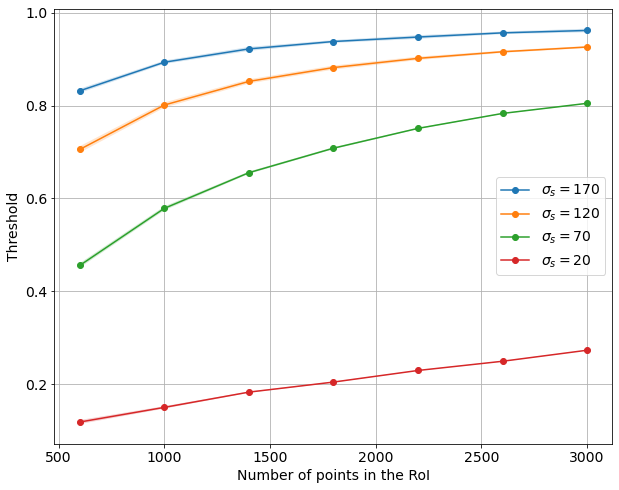

In [16]:
filename = 'automatic_thresholding'

plt.rcParams.update({'font.size': 14})

x = Ns
plt.figure(figsize = (10,8))

linestyle = 'o-'
labels = [r'$\sigma_s = $' + str(s) for s in sigma_ss]
labels.reverse()
for i, av in enumerate(all_T_av):
    av = np.asarray(av)
    sd = np.asarray(all_T_sd[i]) 
    plt.plot(x,av, linestyle, label = labels[i])
    plt.fill_between(x, (av - sd), (av + sd), alpha=.2)

plt.xlabel('Number of points in the RoI')
plt.ylabel('Threshold')
plt.legend()
plt.grid()
plt.savefig(saving_path + filename + '.pdf')

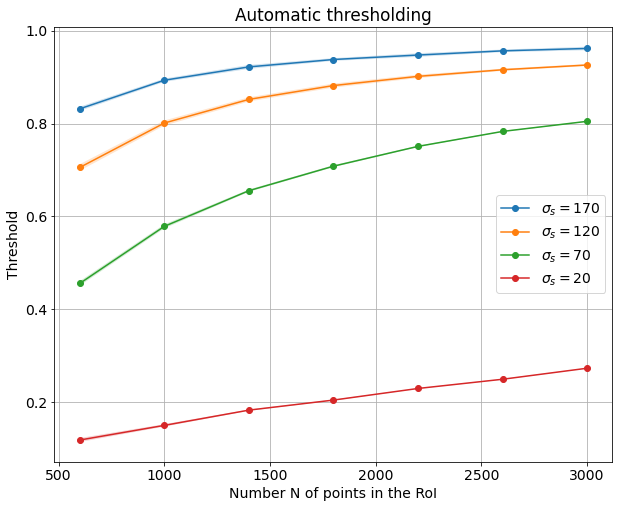

In [12]:
labels.reverse()

In [13]:
labels

['$\\sigma_s = $170',
 '$\\sigma_s = $120',
 '$\\sigma_s = $70',
 '$\\sigma_s = $20']

In [162]:
all_T_sd

[[0.011830327550372716,
  0.01738696252854915,
  0.008643291869369895,
  0.01604782780587805,
  0.010323808322767733,
  0.013307889989586775,
  0.008818330348200022],
 [0.013571826650544272,
  0.021960391662089695,
  0.011304137039011638,
  0.011733642401226544,
  0.008387312307024705,
  0.005523412369706588,
  0.009257299031201104],
 [0.025106168592393095,
  0.013375460587667304,
  0.012402324533670028,
  0.004436458179931914,
  0.0049497359897361344,
  0.004444713386059679,
  0.0032660195811097517],
 [0.011663272795278264,
  0.010997030380888473,
  0.003410377384505544,
  0.0031352436165645132,
  0.0036065559339767787,
  0.0013469281088616637,
  0.0021017907370265523]]

# Cas de low density et high noise.. 

In [31]:
def save_graphic_result(P, labels_clean, file_name):
    saving_path = '/Users/Eliana/Documents/PDM/Codes/My_codes/automatic_T/'
    plt.rcParams.update({'font.size': 18})


    plt.figure(figsize = (10,10))

    not_noise_idx = np.where(labels_clean != 0)
    noise_idx = np.where(labels_clean == 0)


    plt.scatter(P[noise_idx,0], P[noise_idx,1], c = 'lightgray', s = 1)
    plt.scatter(P[not_noise_idx, 0], P[not_noise_idx, 1], c = labels_clean[not_noise_idx], cmap = 'rainbow_r', s = 1)
    plt.gca().set_aspect('equal')
    plt.xlabel('x [nm]'), plt.ylabel('y [nm]')

    plt.savefig(saving_path + file_name + '.pdf')

In [32]:
p_low = Standard_Param()
p_low.LocPerCluster = [10] * p_low.NumberOfClusters
p_low.NoisePercentage = 0.75
DataGen = Call_DataGenerator(p_low)

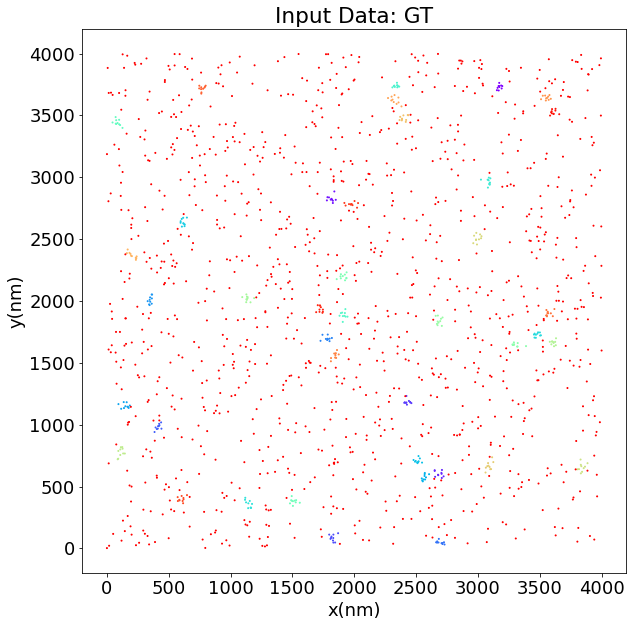

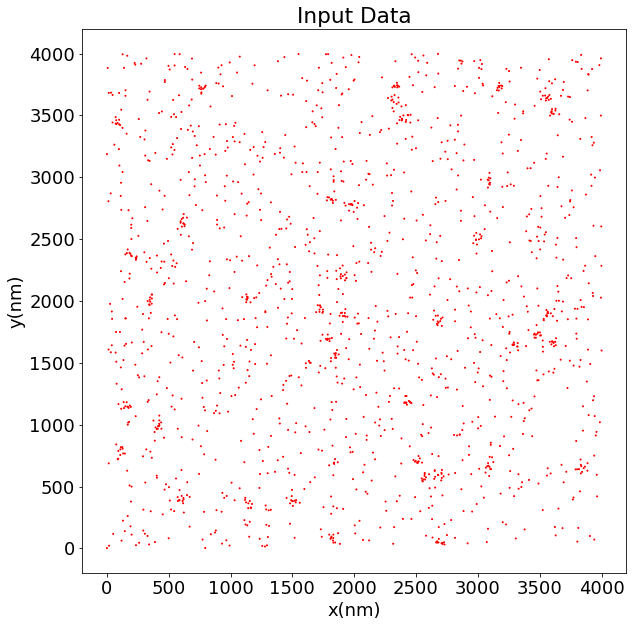

In [33]:
DataGen.plot_points()

In [34]:
sigma_s = 32

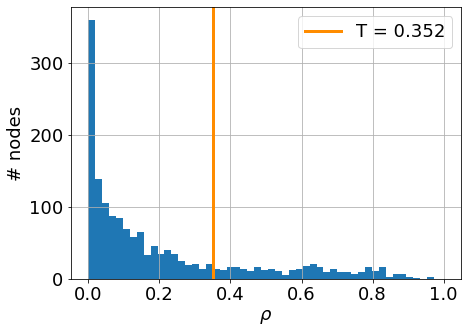

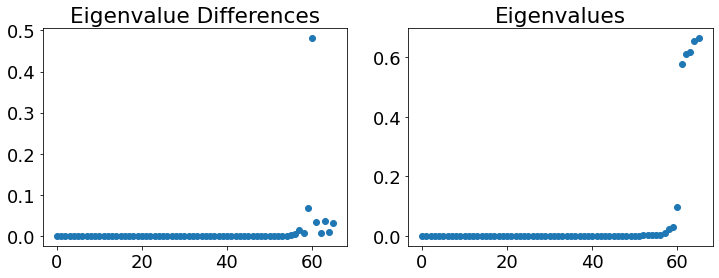

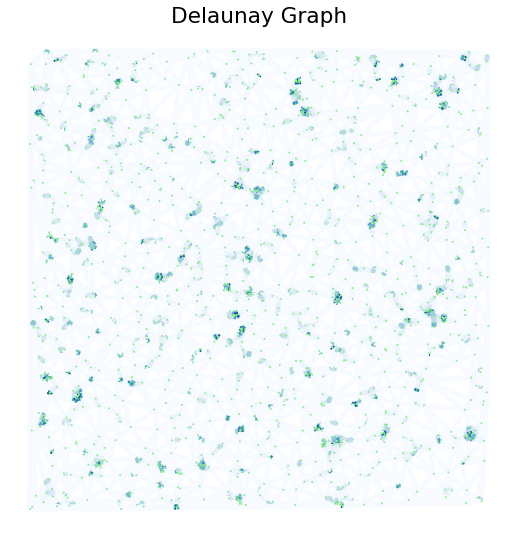

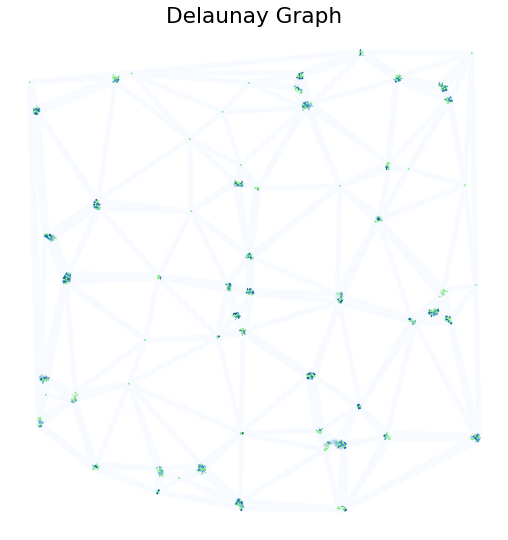

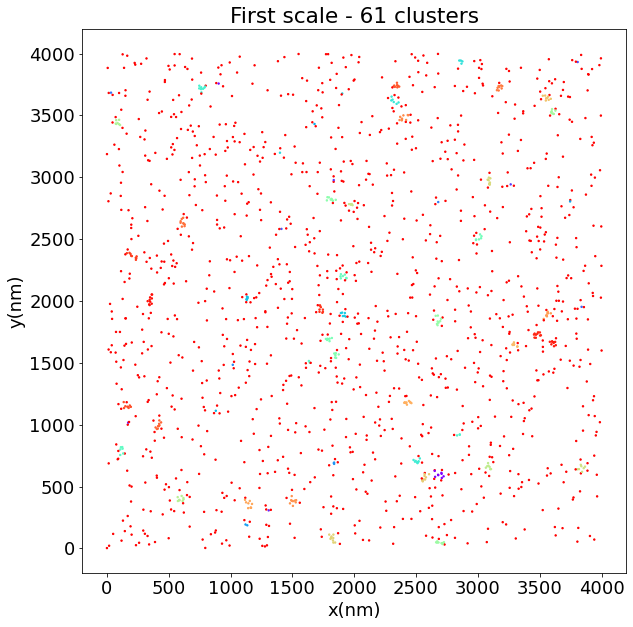

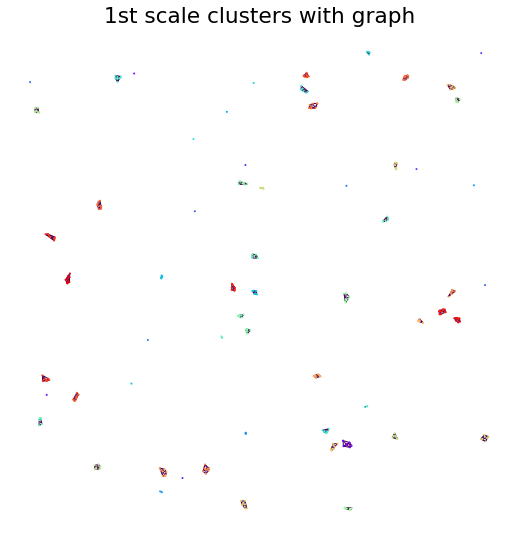

In [35]:
%run ./DataGen2.ipynb
N = len(DataGen.GetPoints())
cov_matrices = DataGen.GetPointsCovMatrix()
T = compute_T_95(N, cov_matrices, sigma_s = sigma_s)
data = DataGen.GetAllData()
labels = calling_graphic(data, sigma_s = sigma_s, noise_thresh = T)
labels_clean = remove_small_clusters(labels, 5)

In [36]:
len(np.unique(labels_clean))

41

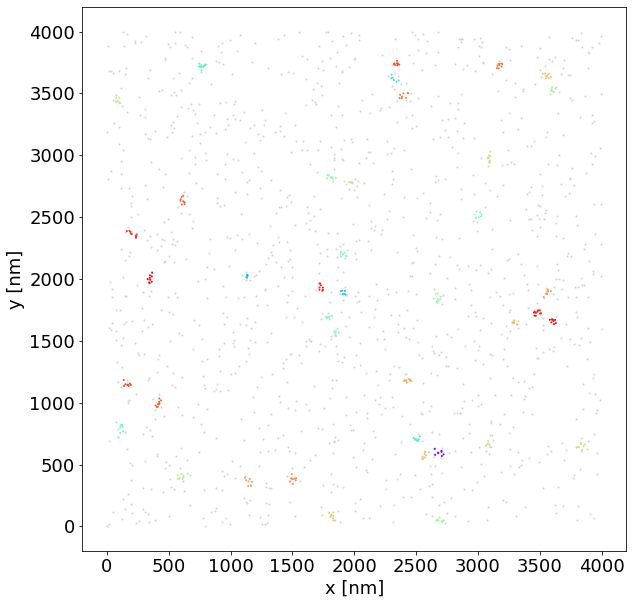

In [37]:
save_graphic_result(DataGen.GetPointsCoord(), labels_clean, 'res_low_density')

In [38]:
truelabels = DataGen.GetPointsLabels()
FMI = metrics.fowlkes_mallows_score(truelabels, labels_clean)
print(FMI)

0.9274432181760017


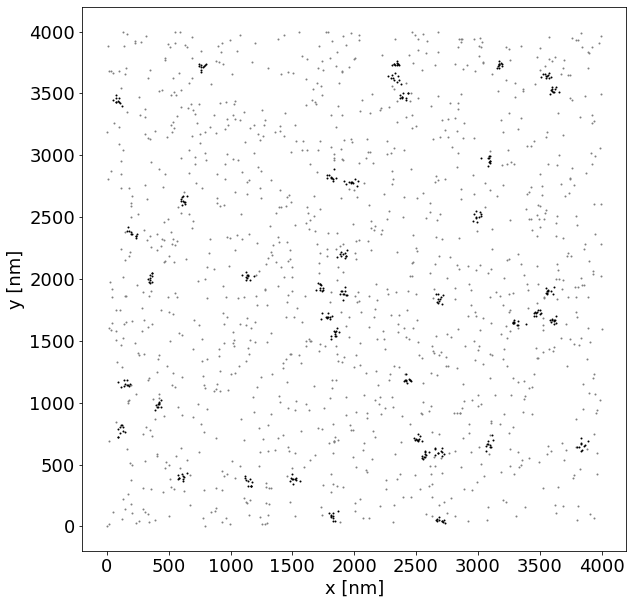

In [39]:

plt.figure(figsize = (10,10))

P = DataGen.GetPointsCoord()

not_noise_idx = np.where(np.asarray(truelabels) != 0)
noise_idx = np.where(np.asarray(truelabels) == 0)


plt.scatter(P[noise_idx,0], P[noise_idx,1], c = 'gray', s = 1)
plt.scatter(P[not_noise_idx, 0], P[not_noise_idx, 1], c = 'black', s = 1)
plt.gca().set_aspect('equal')
plt.xlabel('x [nm]'), plt.ylabel('y [nm]')

plt.savefig(saving_path + 'low_density_GT' + '.pdf')

In [40]:
unique, counts = np.unique(labels_clean, return_counts = True)
counts_without_noise = counts[np.where(unique != 0)]

In [41]:
GT_L = 10

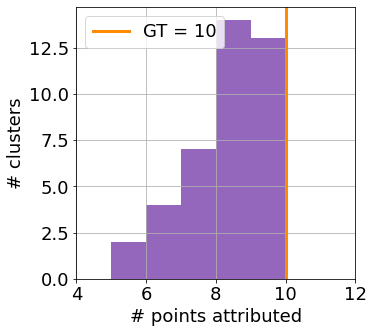

In [43]:
plt.figure(figsize = (5,5))
#plt.axvspan(18, 24, color='DarkOrange', alpha = 0.2, label = 'domaine ok selon GT')
plt.hist(counts_without_noise, bins = np.unique(counts_without_noise), color = 'tab:purple')
plt.grid()
plt.axvline(x=GT_L, label='GT = ' + str(GT_L), c='DarkOrange', linewidth=3)
plt.legend()
plt.xlabel('# points attributed')
plt.ylabel('# clusters')
plt.xlim(4, 12)
#plt.xticks([15, 18, 21, 24])
#plt.yticks([0, 20, 40, 60])
saving_path = '/Users/Eliana/Documents/PDM/Codes/My_codes/automatic_T/'
plt.savefig(saving_path + 'low_density_LocPerClus'+ '.pdf')

## Crowded of clusters  with no noise 

In [25]:
pcr = Standard_Param(NumberOfClusters = 200)
pcr.NoisePercentage = 0
DataCrowded = Call_DataGenerator(pcr)
#DataCrowded.plot_points()

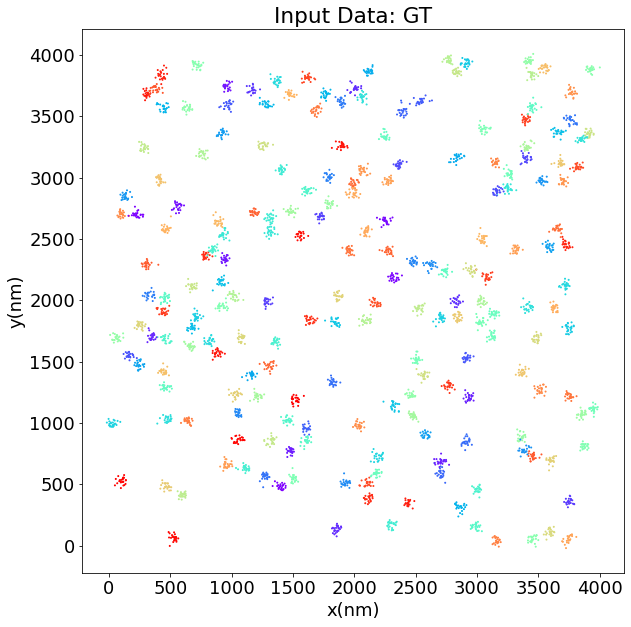

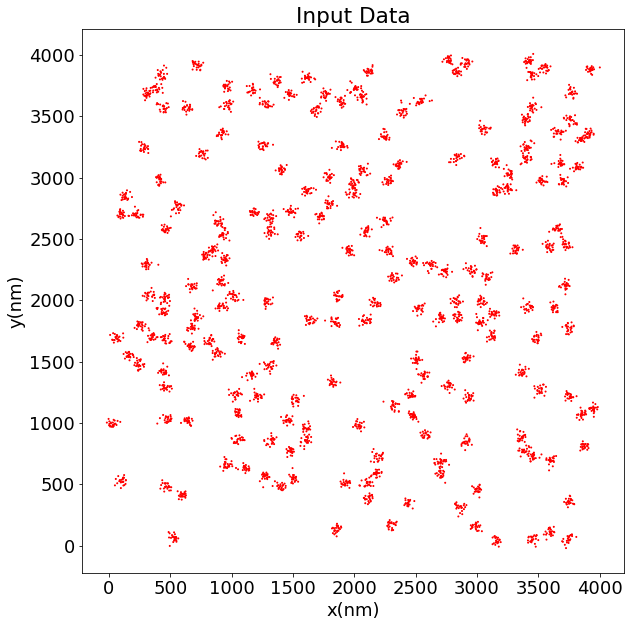

In [26]:
DataCrowded.plot_points()

In [27]:
crowded_df = DataCrowded.GetAllData()
N_crowded = len(DataCrowded.GetPoints())

sigma_s = 32.0

cov_matrices = DataCrowded.GetPointsCovMatrix()
T_crowded = compute_T_95(N_crowded, cov_matrices, sigma_s = sigma_s, x_lim = [0,4], y_lim= [0,4])



P_crowded = crowded_df[['x', 'y']].to_numpy()

#density_crowded, G = compute_density(P_crowded, Sigma1, sigma_s)
#see_histogram(density_crowded, T_crowded, 'standard')

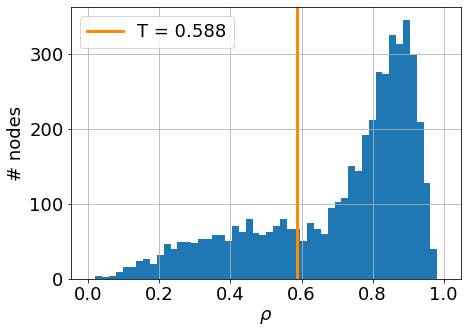

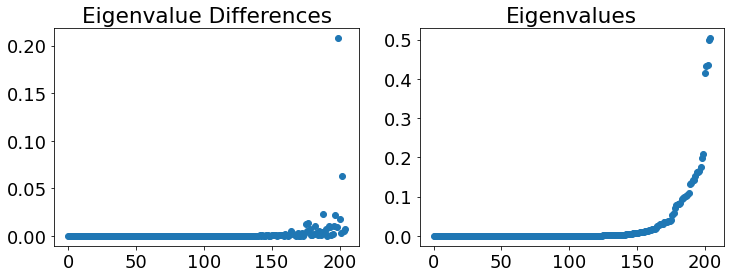

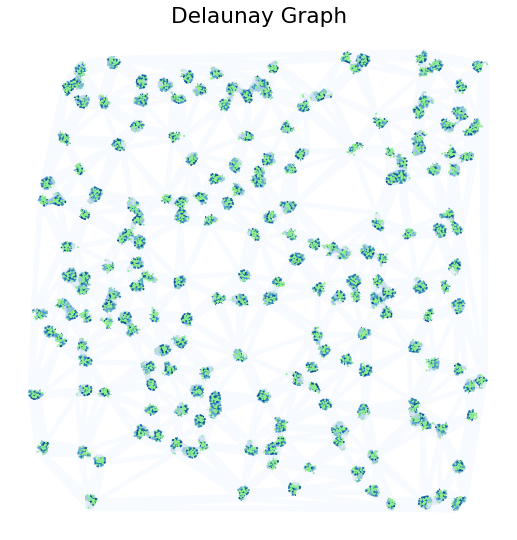

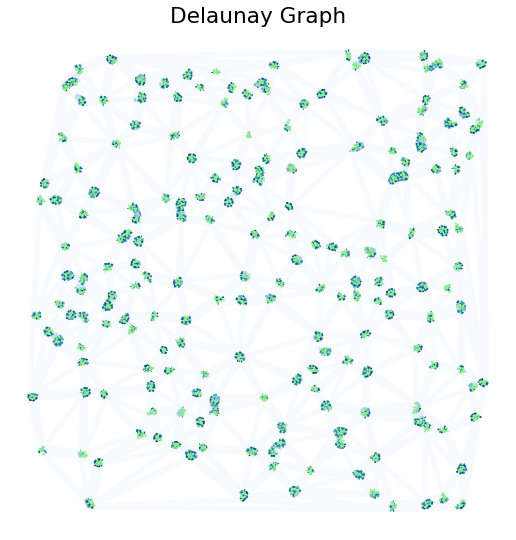

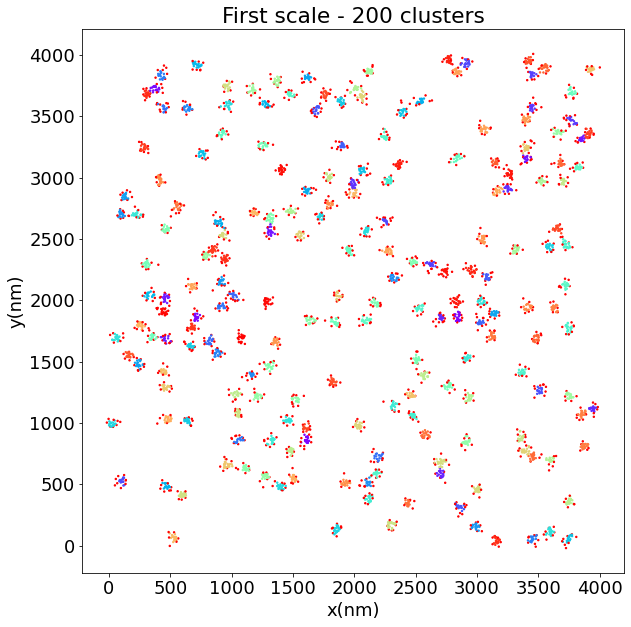

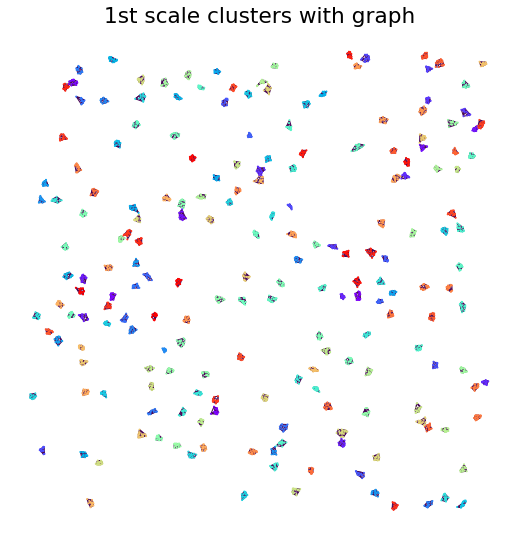

In [28]:
labels_crowded = calling_graphic(crowded_df, sigma_s, T_crowded)
labels_clean = remove_small_clusters(labels_crowded, 5)

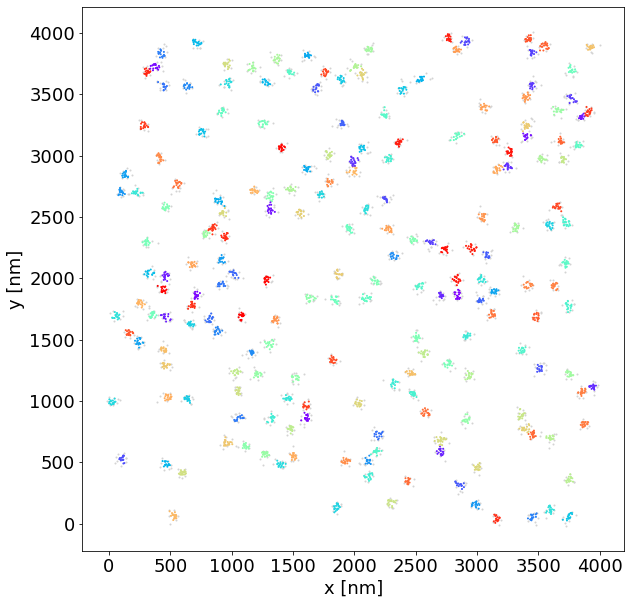

In [29]:
save_graphic_result(DataCrowded.GetPointsCoord(), labels_clean, 'res_crowded')

In [30]:
truelabels = DataCrowded.GetPointsLabels()
FMI = metrics.fowlkes_mallows_score(truelabels, labels_clean)
print(FMI)

0.1472650543391447


In [34]:
saving_path = '/Users/Eliana/Documents/PDM/Codes/My_codes/automatic_T/'

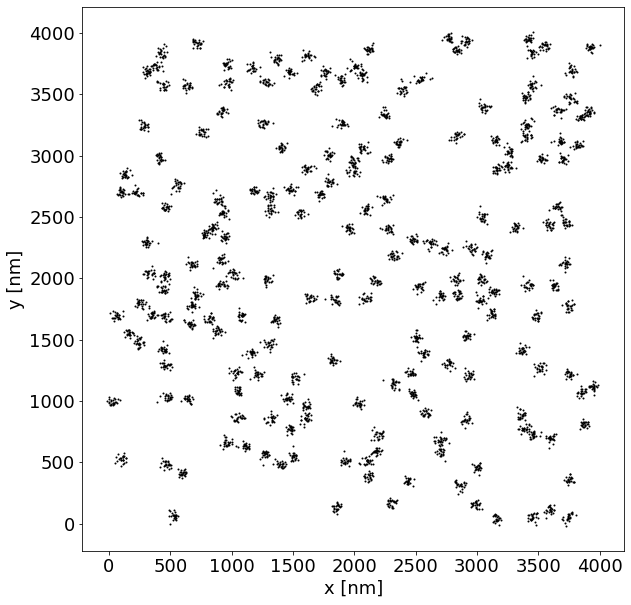

In [35]:
plt.figure(figsize = (10,10))

P = DataCrowded.GetPointsCoord()

not_noise_idx = np.where(np.asarray(truelabels) != 0)
noise_idx = np.where(np.asarray(truelabels) == 0)


plt.scatter(P[noise_idx,0], P[noise_idx,1], c = 'gray', s = 1)
plt.scatter(P[not_noise_idx, 0], P[not_noise_idx, 1], c = 'black', s = 1)
plt.gca().set_aspect('equal')
plt.xlabel('x [nm]'), plt.ylabel('y [nm]')

plt.savefig(saving_path + 'crowded_GT' + '.pdf')

In [59]:
unique, counts = np.unique(labels_clean, return_counts = True)
counts_without_noise = counts[np.where(unique != 0)]

In [88]:
GT_L = 24
range_hist = (GT_L - min(counts_without_noise), GT_L + min(counts_without_noise))

In [148]:
counts_without_noise

array([17, 17, 19, 18, 19, 20, 18, 19, 19, 20, 21, 19, 18, 20, 20, 18, 21,
       17, 19, 18, 18, 19, 18, 18, 19, 20, 18, 19, 19, 20, 17, 18, 19, 18,
       19, 17, 19, 17, 19, 19, 18, 20, 19, 17, 19, 19, 20, 18, 19, 18, 18,
       17, 18, 18, 19, 18, 18, 18, 19, 17, 19, 20, 19, 18, 19, 17, 21, 19,
       19, 18, 17, 18, 18, 17, 17, 19, 18, 18, 18, 18, 19, 18, 18, 18, 18,
       17, 18, 19, 19, 18, 18, 18, 17, 16, 17, 18, 17, 19, 17, 18, 16, 18,
       18, 17, 17, 18, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 17, 17,
       17, 19, 17, 18, 17, 16, 17, 17, 17, 17, 17, 18, 17, 17, 17, 17, 16,
       17, 17, 17, 16, 17, 17, 16, 16, 16, 17, 17, 17, 15, 16, 17, 18, 16,
       16, 17, 17, 17, 16, 17, 17, 16, 16, 16, 16, 17, 16, 16, 15, 16, 15,
       16, 17, 15, 15, 15, 15, 15, 15, 15, 15, 14, 19, 18, 15, 15, 15, 20,
       18, 18, 14, 17, 15, 17, 16, 17, 14, 18, 18, 18, 16])

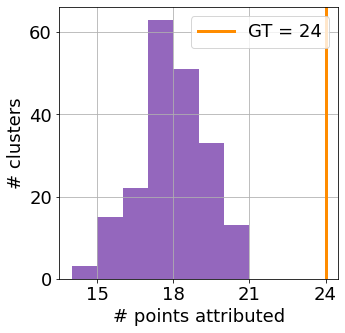

In [155]:
plt.figure(figsize = (5,5))
#plt.axvspan(18, 24, color='DarkOrange', alpha = 0.2, label = 'domaine ok selon GT')
plt.hist(counts_without_noise, bins = np.unique(counts_without_noise), color = 'tab:purple')
plt.grid()
plt.axvline(x=GT_L, label='GT = ' + str(GT_L), c='DarkOrange', linewidth=3)
plt.legend()
plt.xlabel('# points attributed')
plt.ylabel('# clusters')
plt.xticks([15, 18, 21, 24])
plt.yticks([0, 20, 40, 60])
saving_path = '/Users/Eliana/Documents/PDM/Codes/My_codes/automatic_T/'
plt.savefig(saving_path + 'crowded_LocPerClus'+ '.pdf')

In [47]:
LocPerCluster = []
LocInNoise = []
for clus in np.unique(labels_clean):
    print(clus)
    print(np.where(labels_clean == clus))
    print('len = ', len(np.where(labels_clean == clus)))
    
        #if clus != 0:
        #    LocPerCluster.append(len(np.where(labels_clean == clus)))
        #if clus == 0:
        #    LocPerCluster.append(len(np.where(labels_clean == 0)))

0.0
(array([   5,    6,    9, ..., 4784, 4792, 4793]),)
len =  1
1.0
(array([1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546,
       1547, 1548, 1551, 1555, 1558, 1559]),)
len =  1
2.0
(array([360, 361, 362, 363, 364, 366, 369, 370, 371, 372, 374, 375, 376,
       380, 381, 382, 383]),)
len =  1
3.0
(array([4392, 4394, 4395, 4396, 4397, 4398, 4399, 4400, 4401, 4402, 4403,
       4407, 4408, 4409, 4410, 4411, 4412, 4414, 4415]),)
len =  1
4.0
(array([3001, 3002, 3003, 3004, 3005, 3007, 3008, 3009, 3010, 3011, 3014,
       3016, 3017, 3018, 3019, 3020, 3021, 3022]),)
len =  1
5.0
(array([2664, 2665, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675,
       2678, 2681, 2682, 2683, 2684, 2685, 2686, 2687]),)
len =  1
6.0
(array([2521, 2522, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2532, 2533,
       2534, 2535, 2536, 2537, 2538, 2539, 2541, 2542, 2543]),)
len =  1
7.0
(array([4465, 4466, 4468, 4469, 4470, 4471, 4472, 4474, 4478, 4479, 4480,
       4481, 4482, 4483, 448

(array([  0.,   0.,   0.,   0.,   0., 201.,   0.,   0.,   0.,   0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

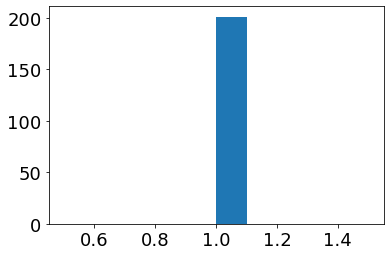

In [40]:
plt.hist(LocPerCluster)

In [41]:
LocPerCluster

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

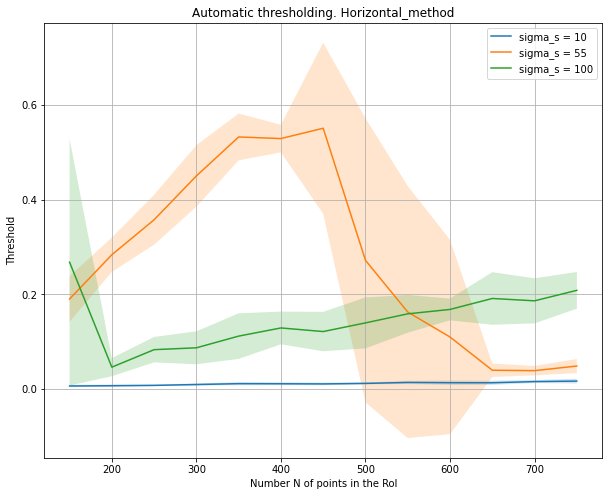

In [62]:

labels = ['sigma_s = ' + str(s) for s in Sigma_s_s]

x = Ns
plt.figure(figsize = (10,8))
for i, av in enumerate(all_T_av):
    av = np.asarray(av)
    sd = np.asarray(all_T_sd[i])
    plt.plot(x,av, label = labels[i])
    plt.fill_between(x, (av - sd), (av + sd), alpha=.2)

plt.title('Automatic thresholding. Horizontal_method')
plt.xlabel('Number N of points in the RoI')
plt.ylabel('Threshold')
plt.legend()
plt.grid()
plt.show()

10
N =  300


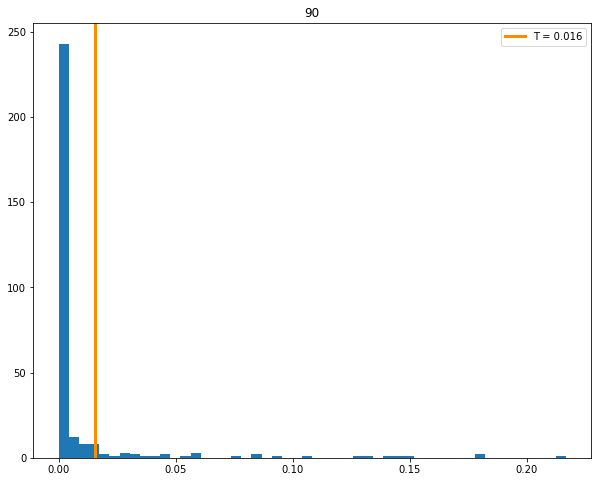

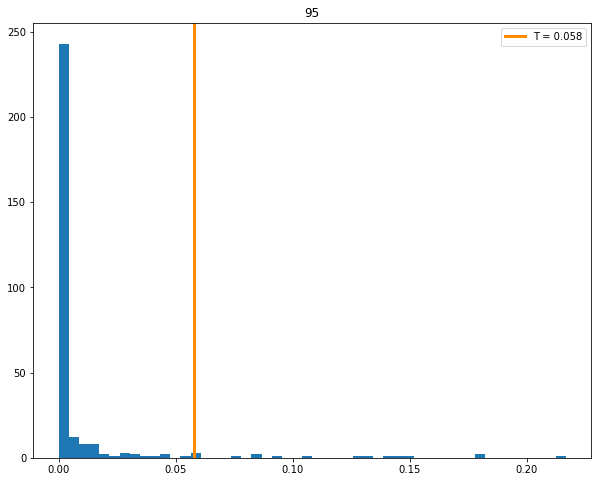

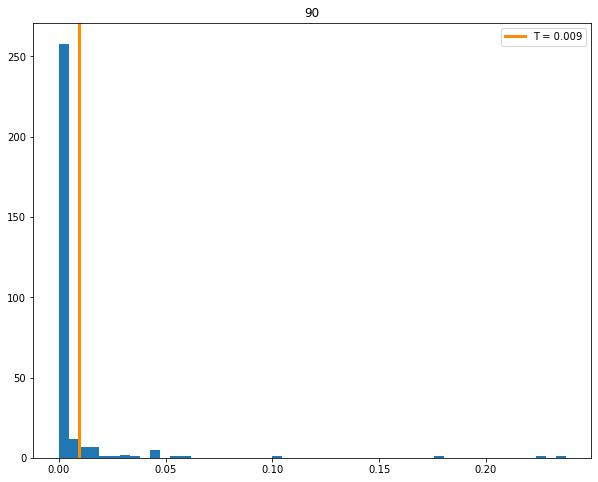

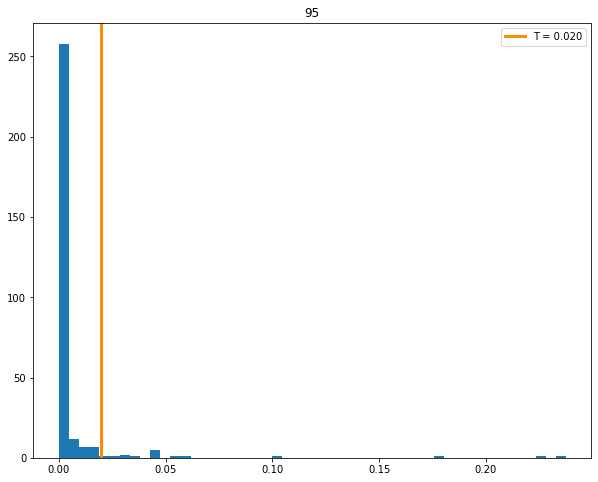

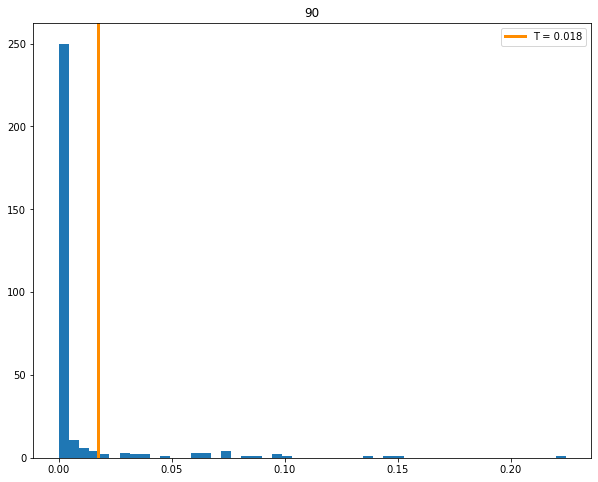

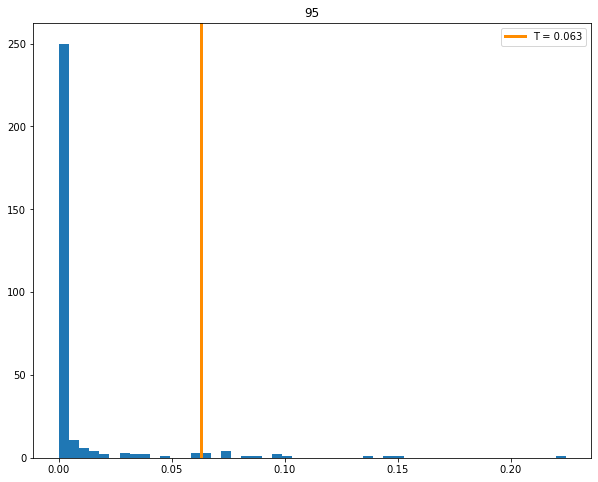

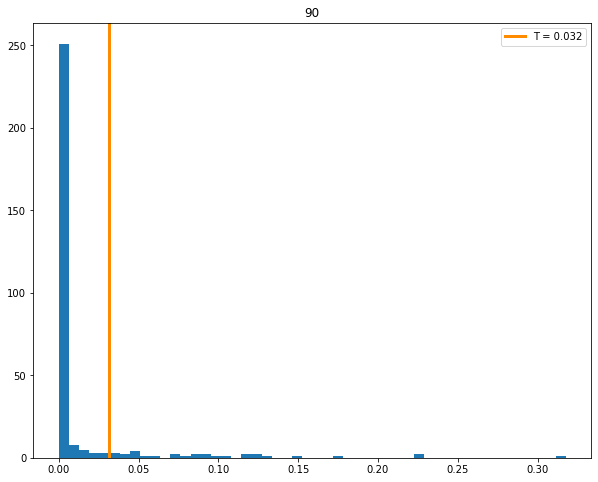

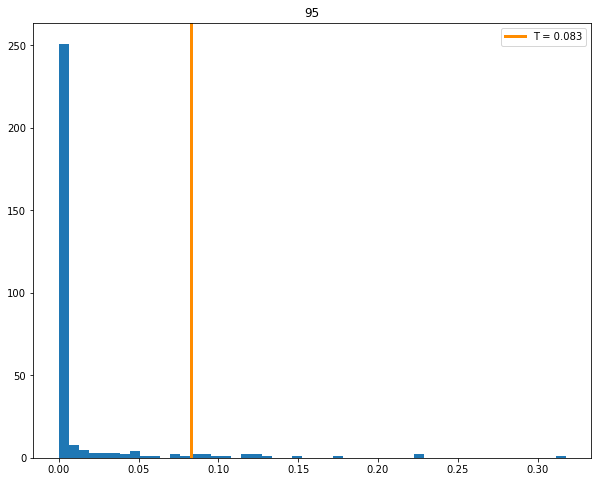

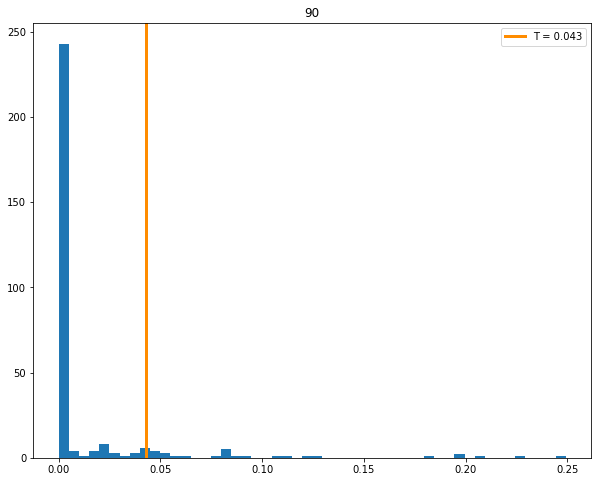

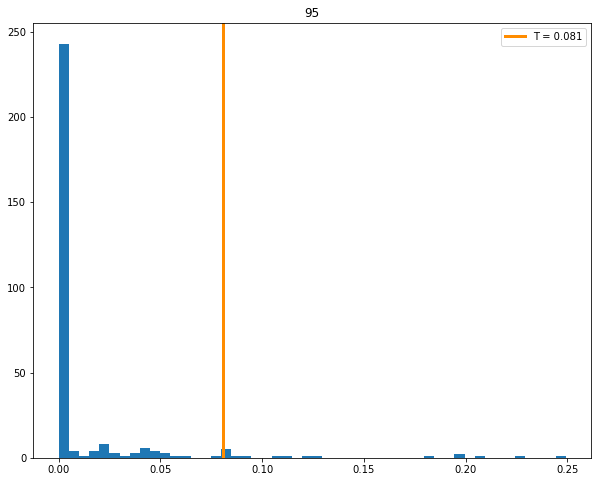

N =  350


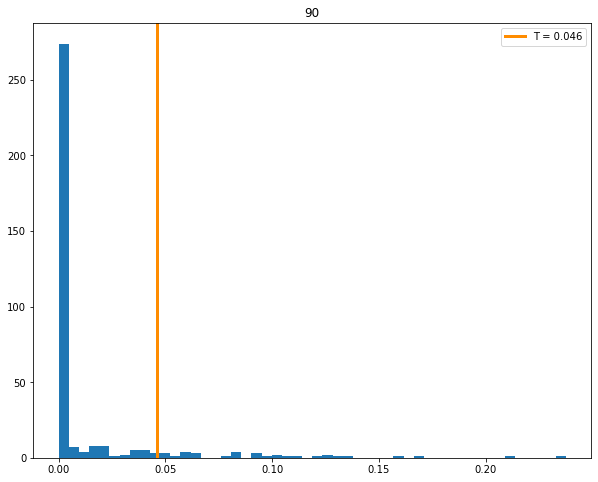

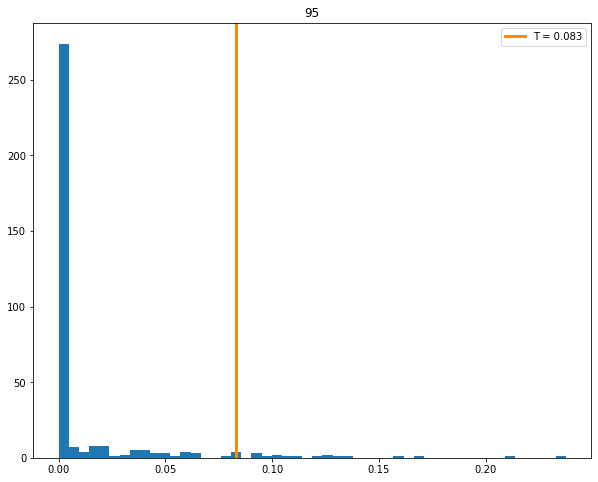

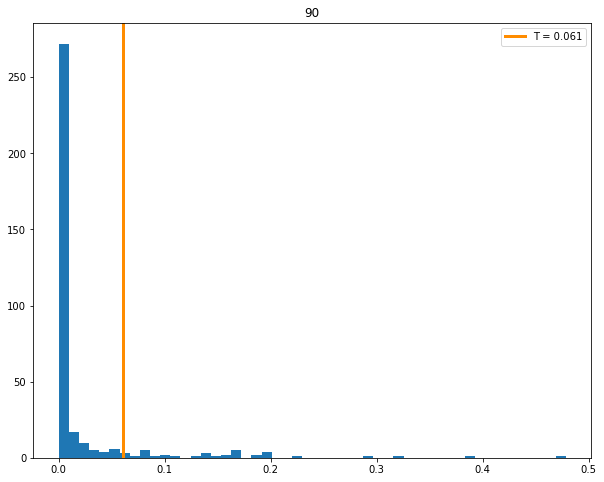

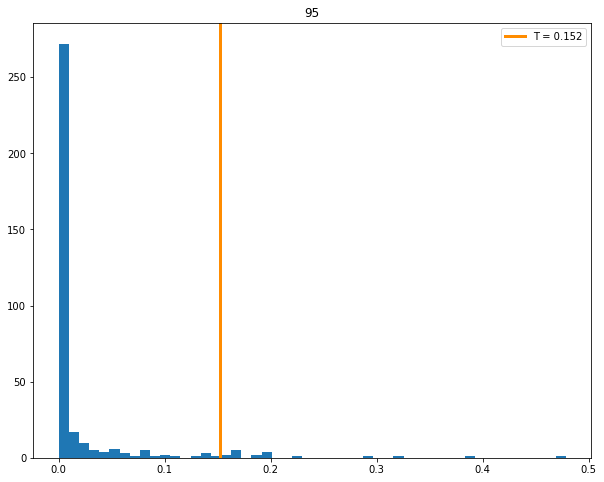

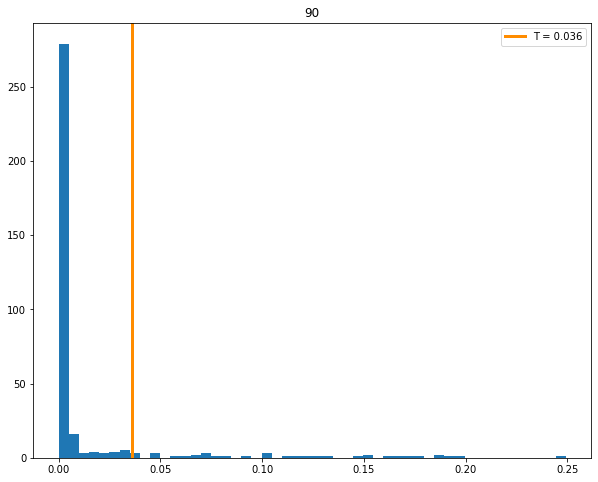

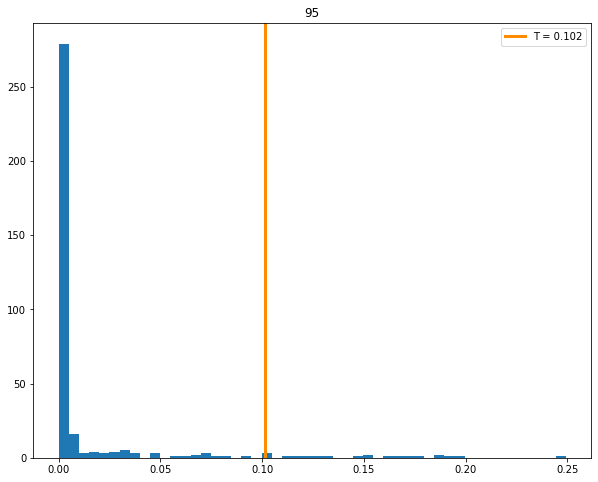

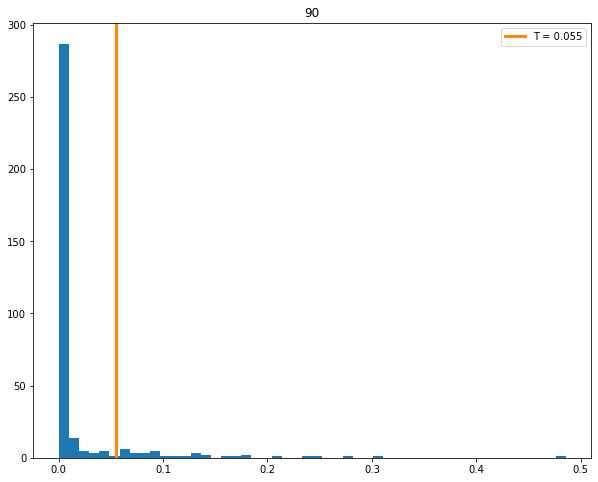

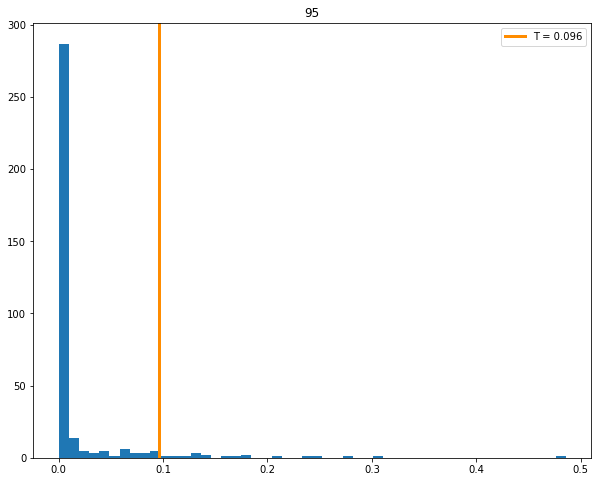

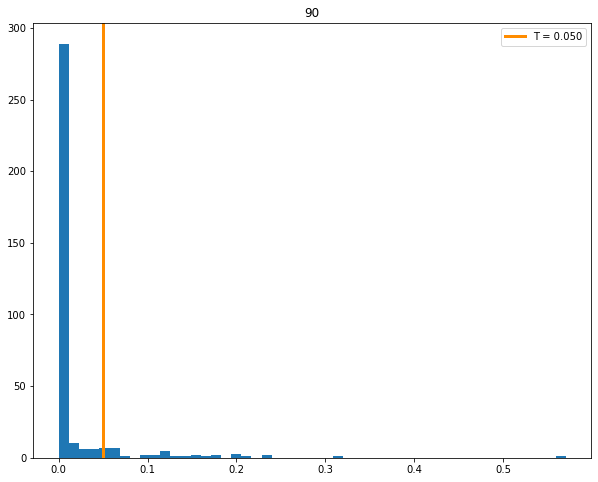

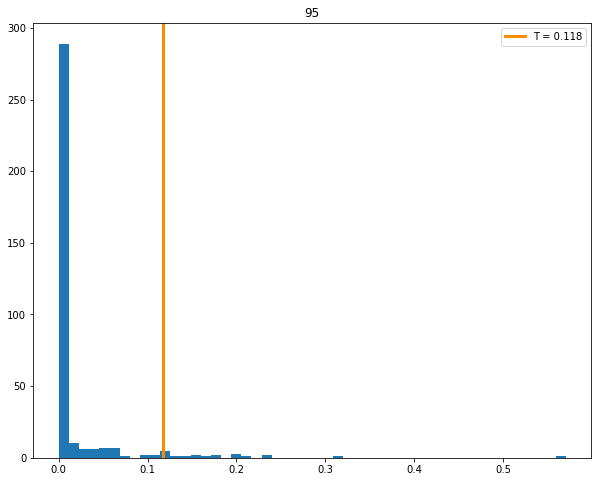

N =  400


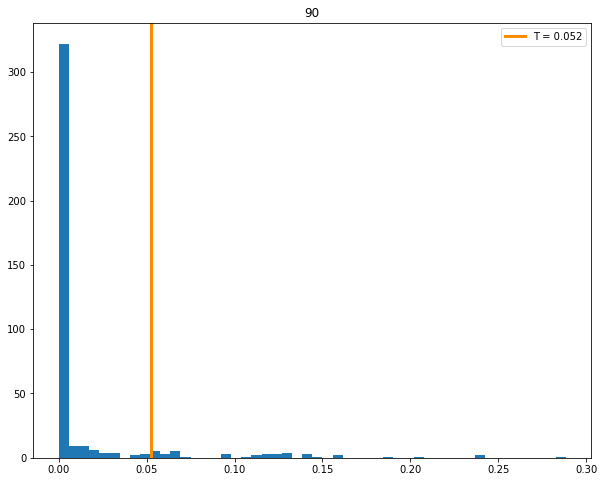

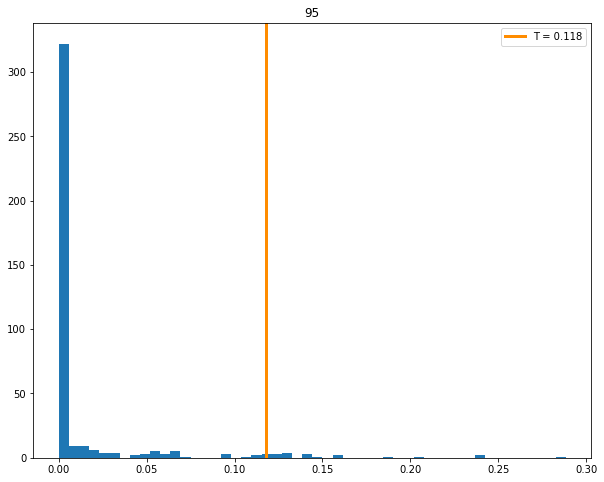

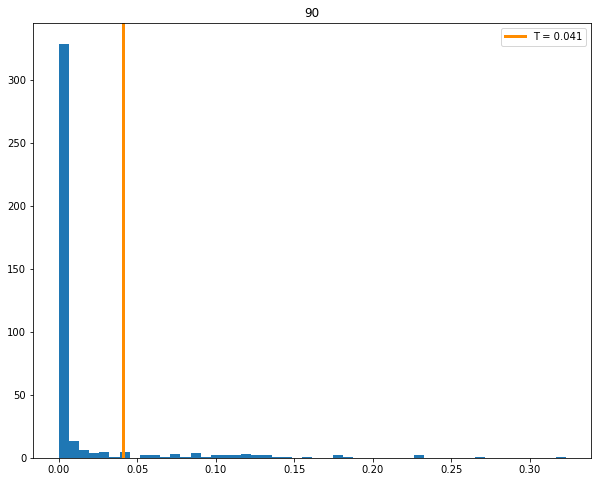

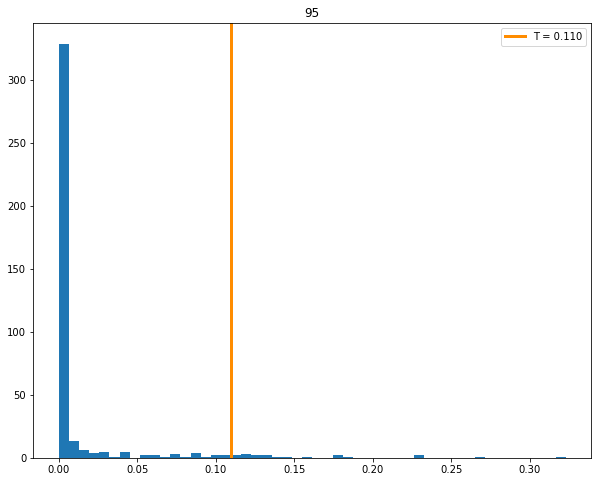

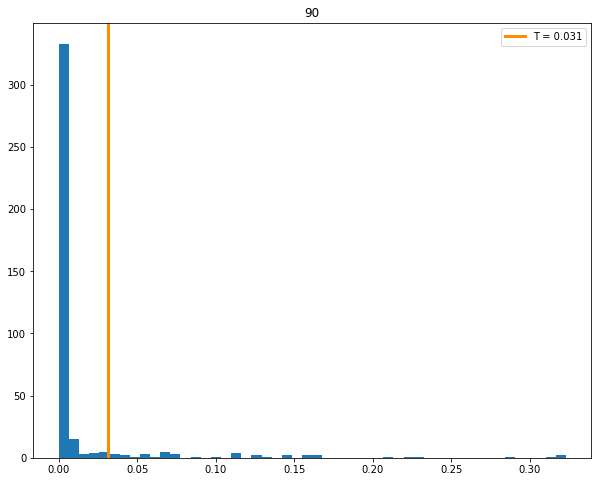

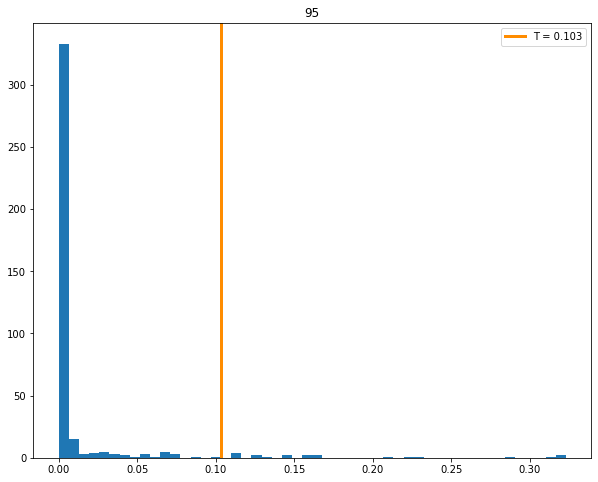

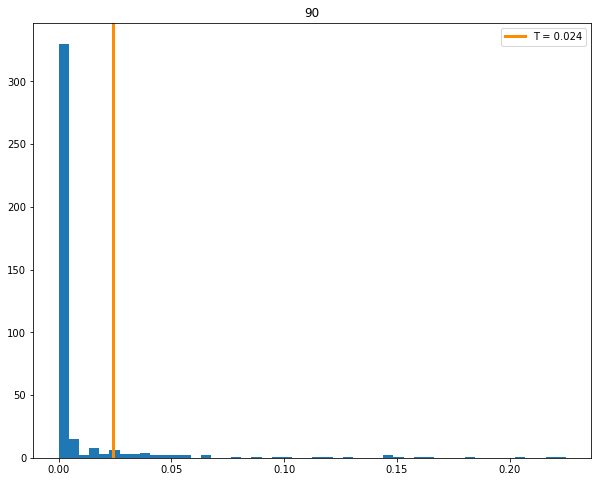

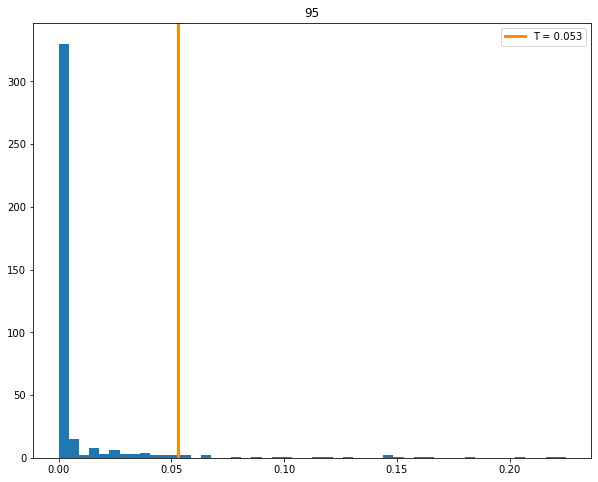

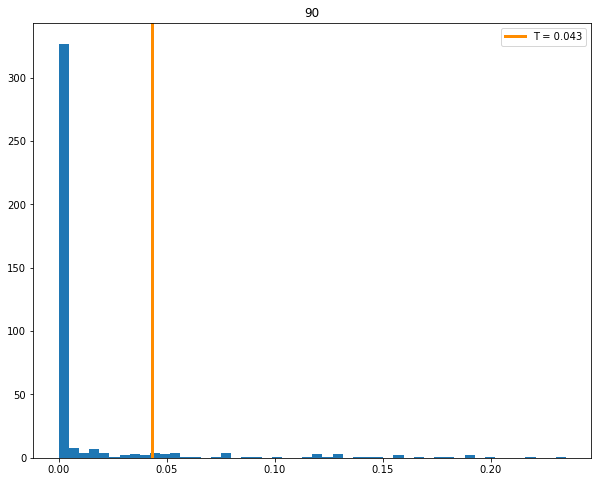

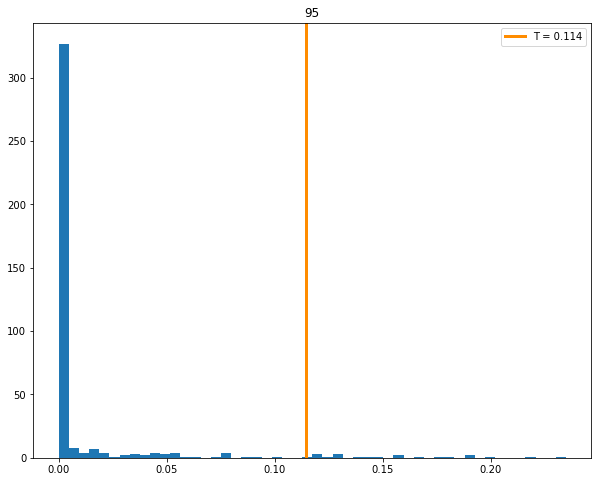

N =  450


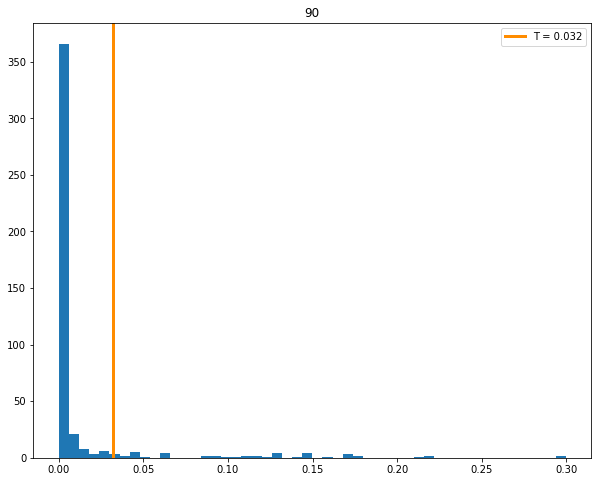

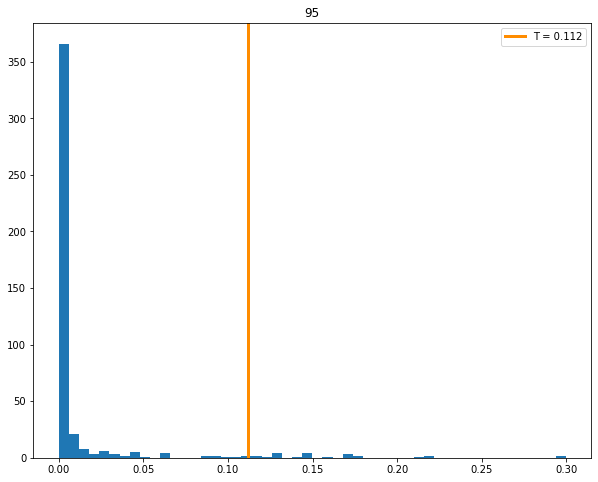

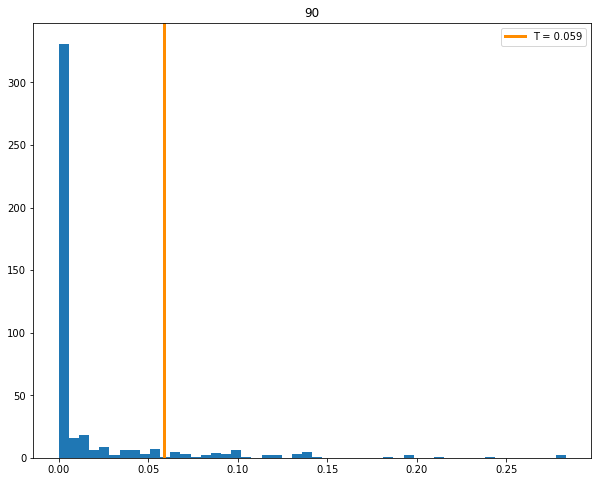

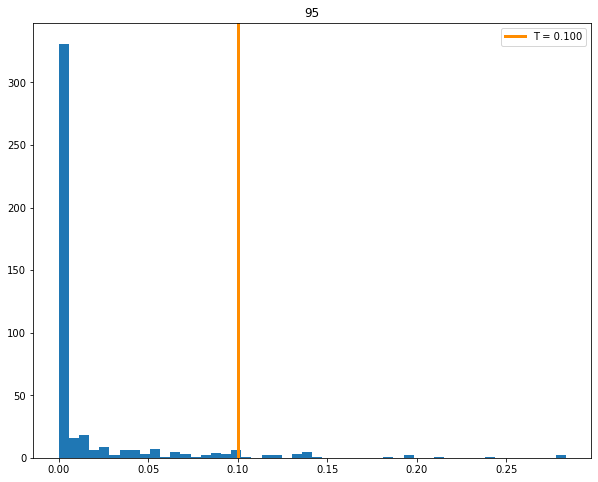

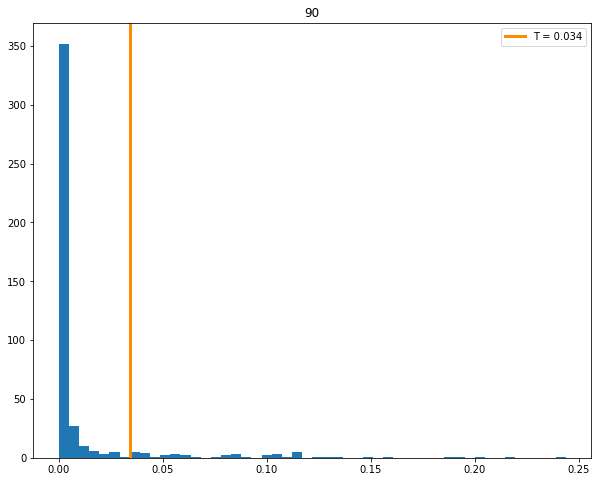

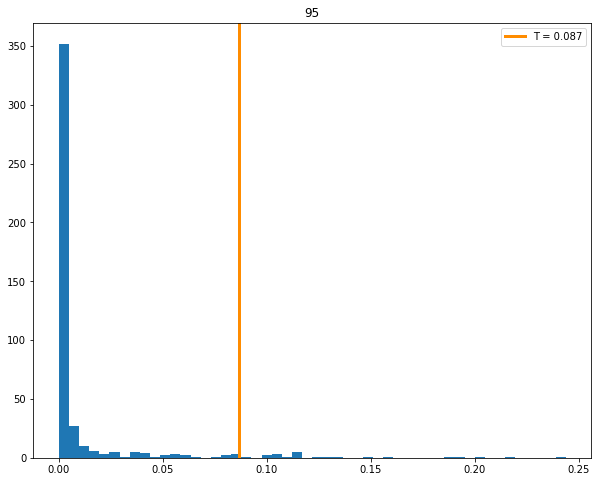

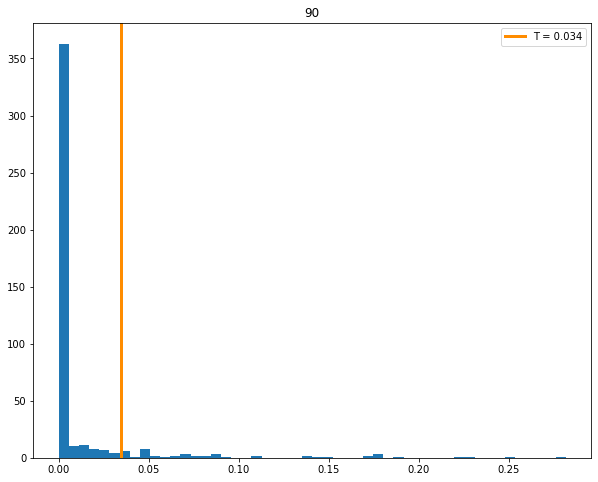

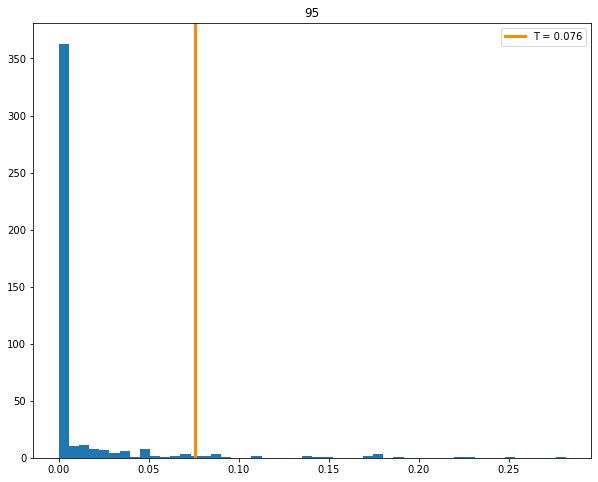

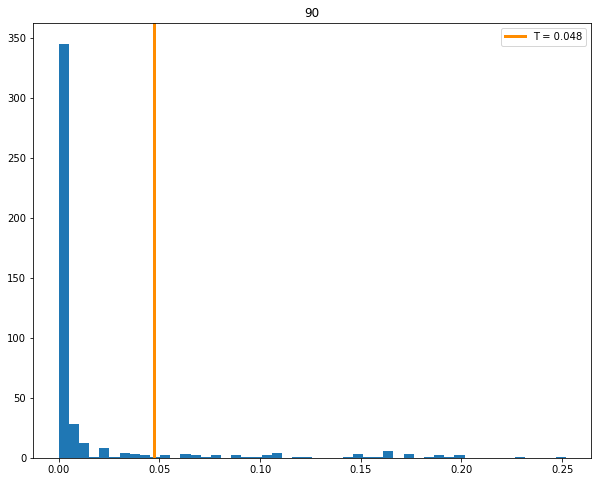

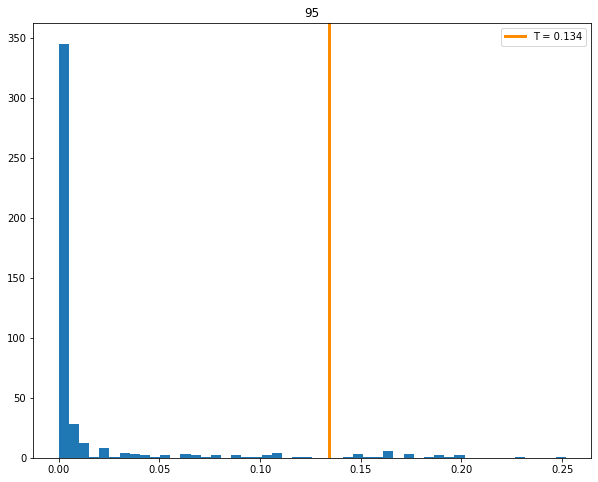

N =  500


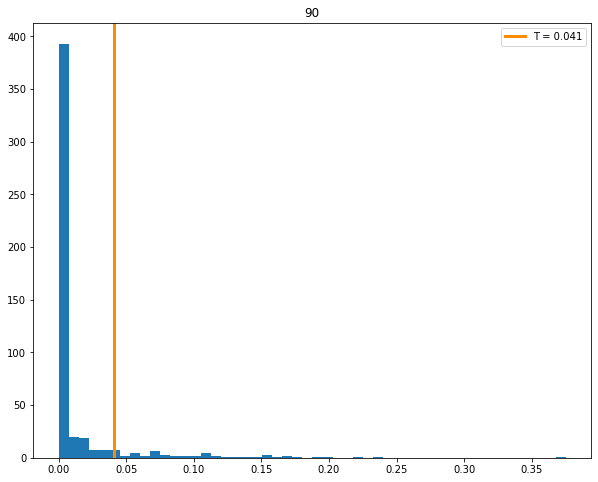

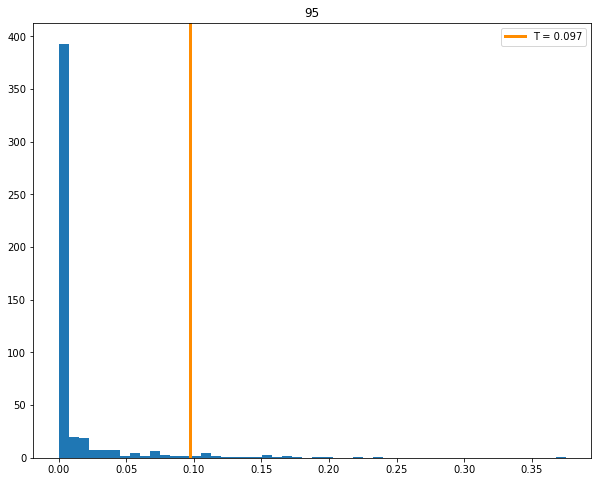

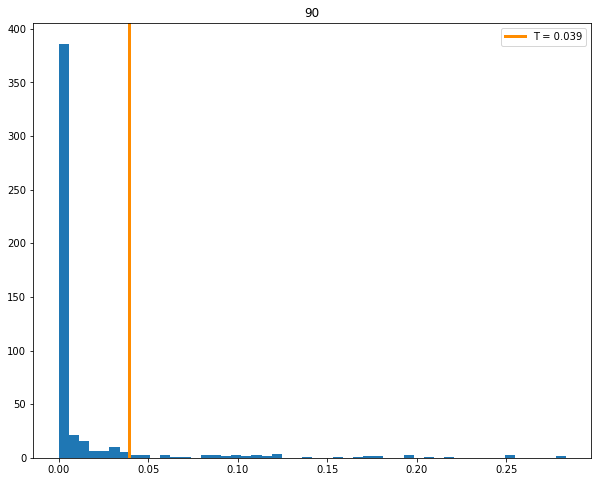

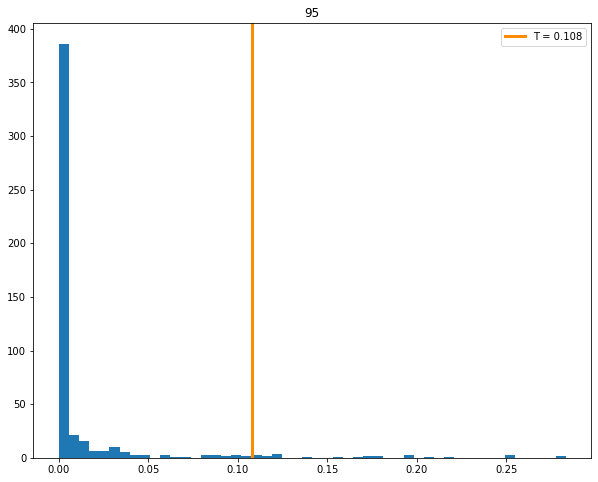

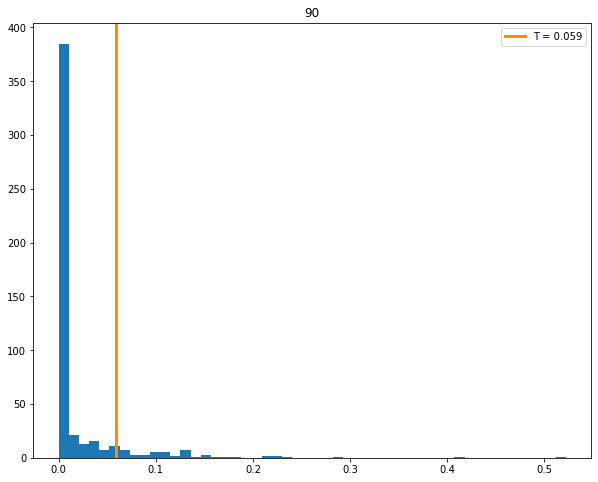

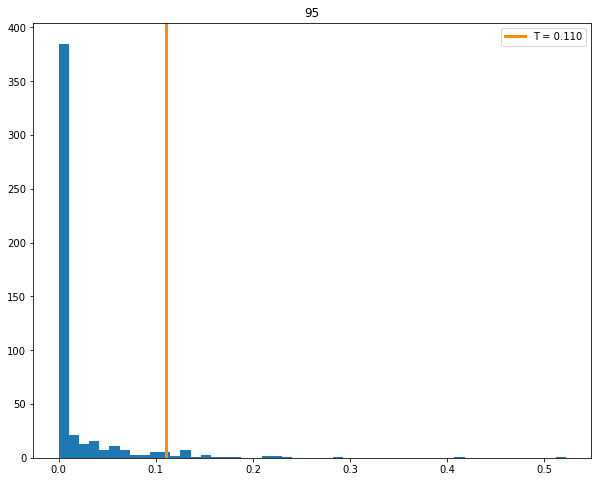

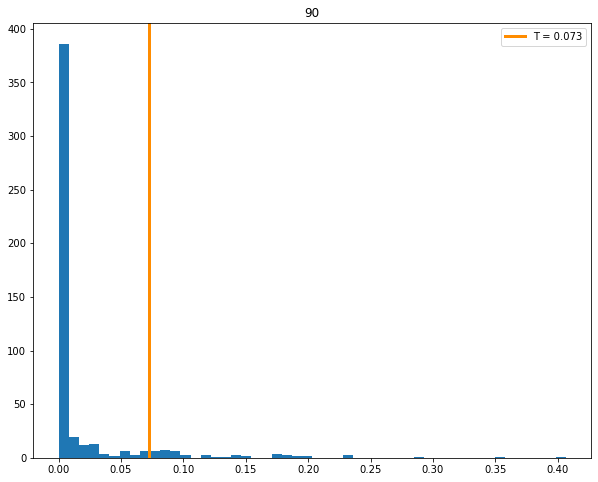

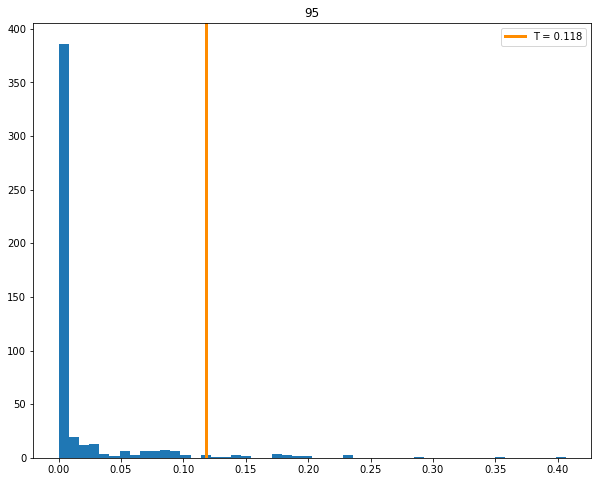

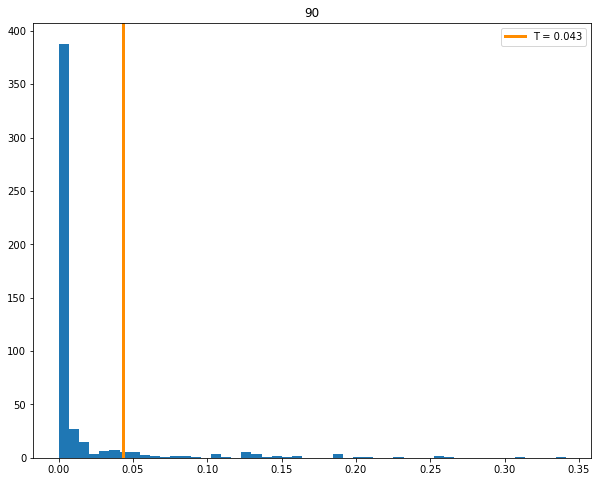

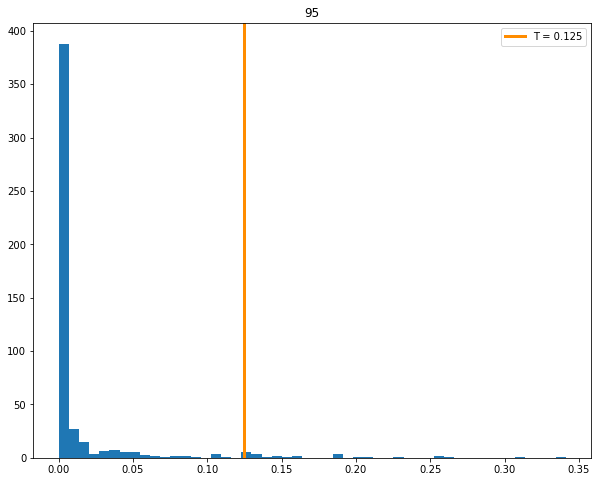

N =  550


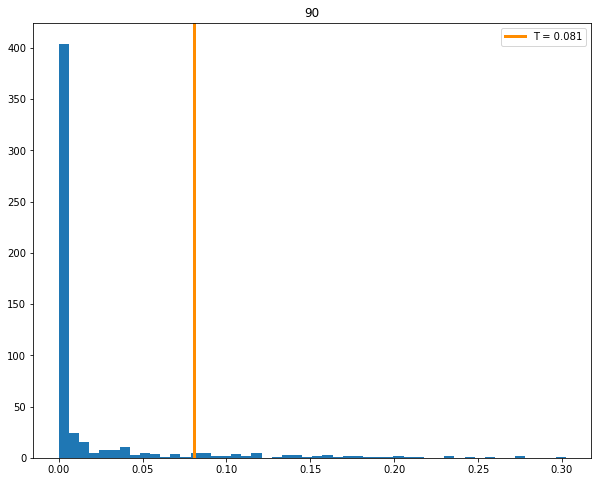

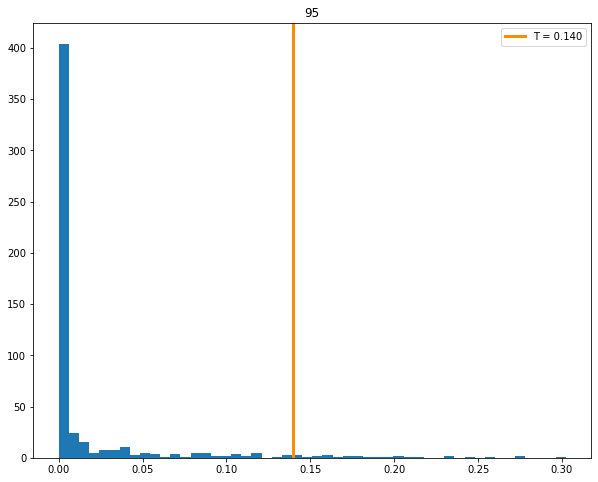

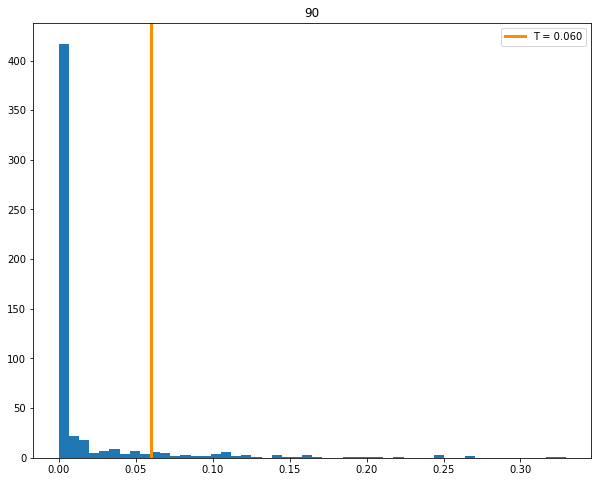

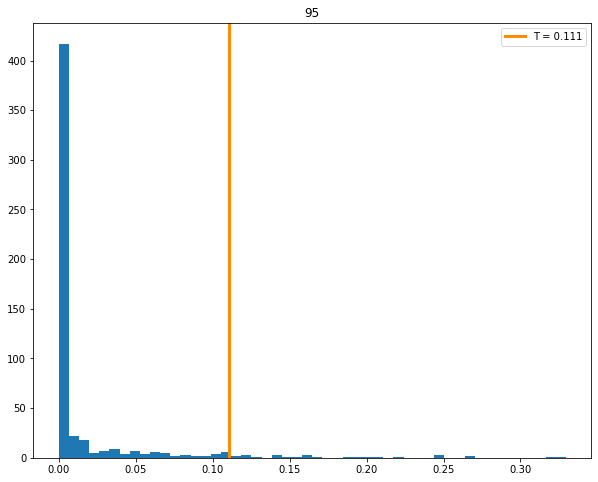

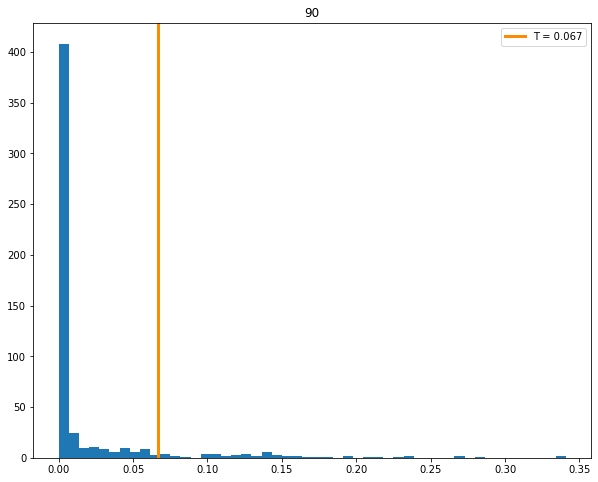

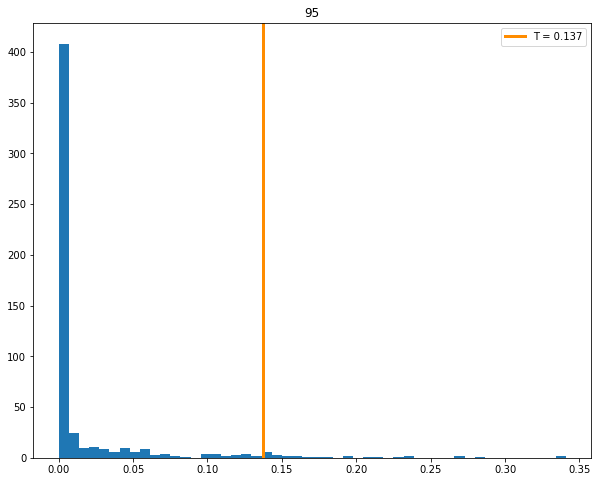

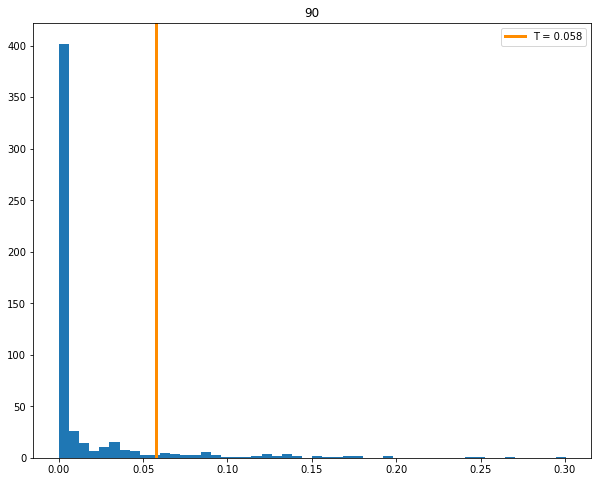

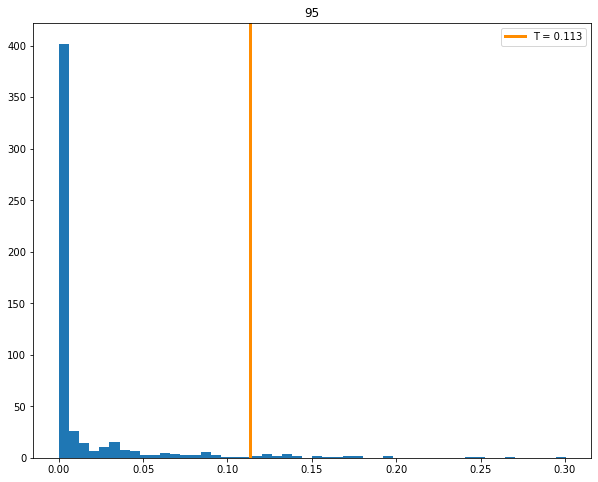

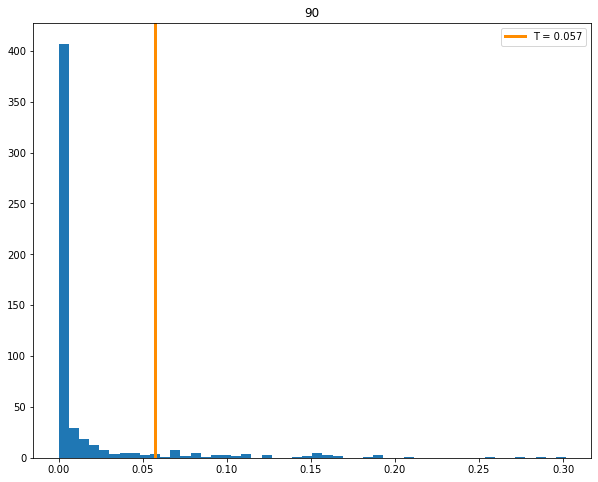

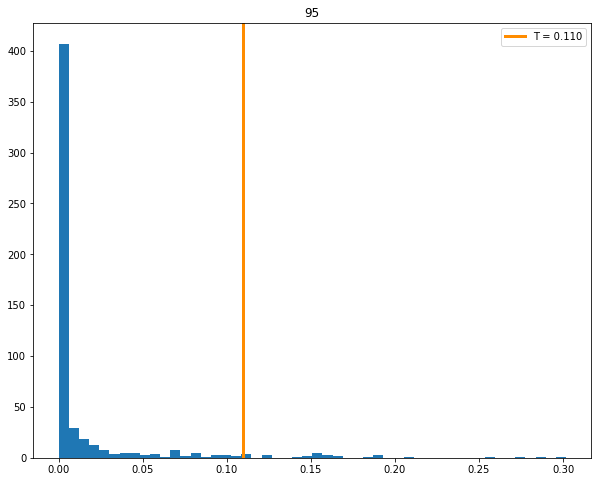

N =  600


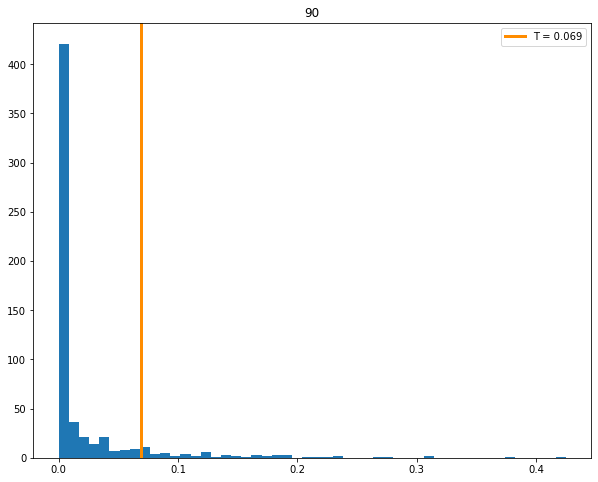

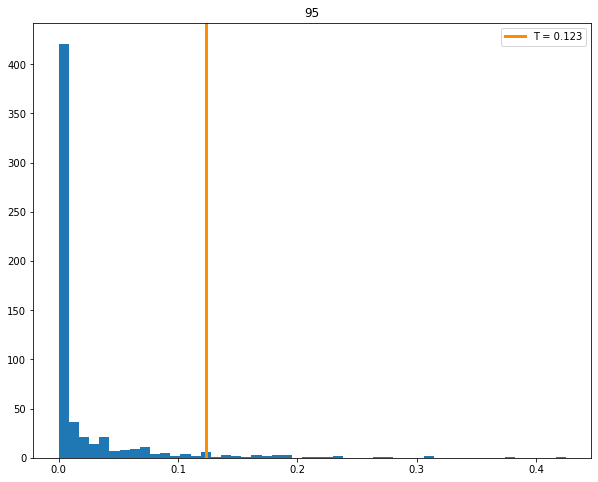

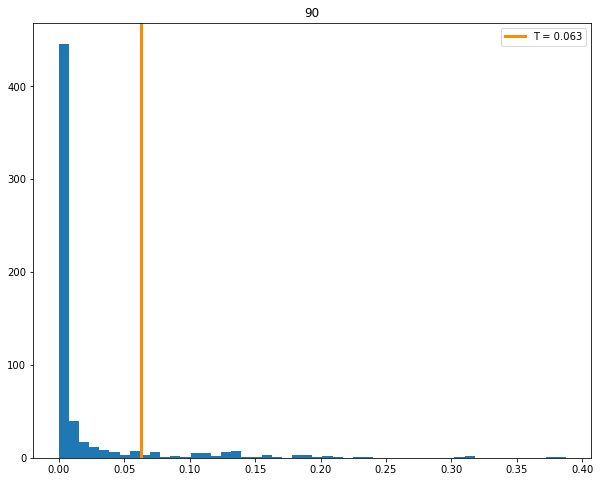

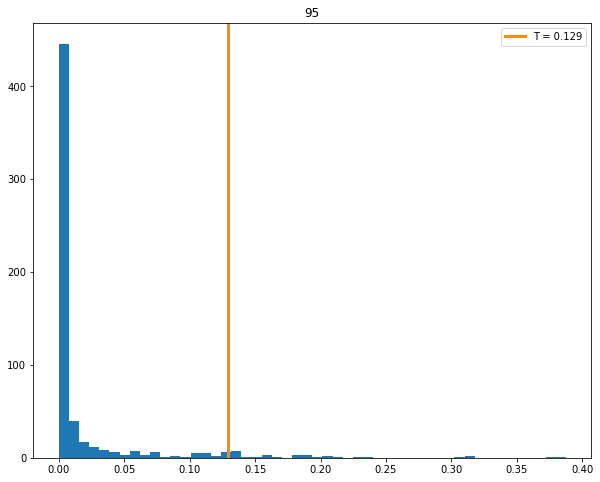

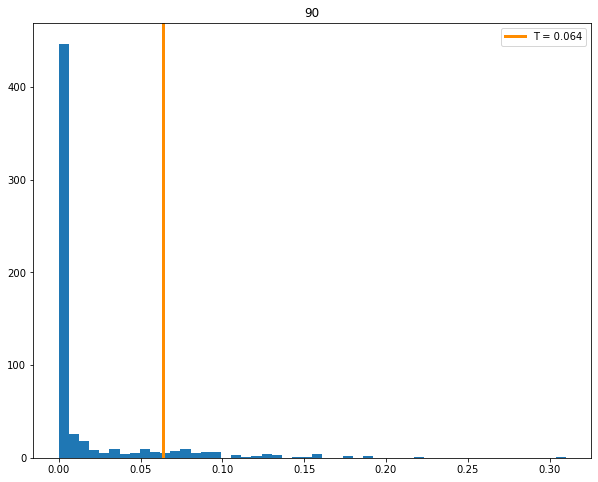

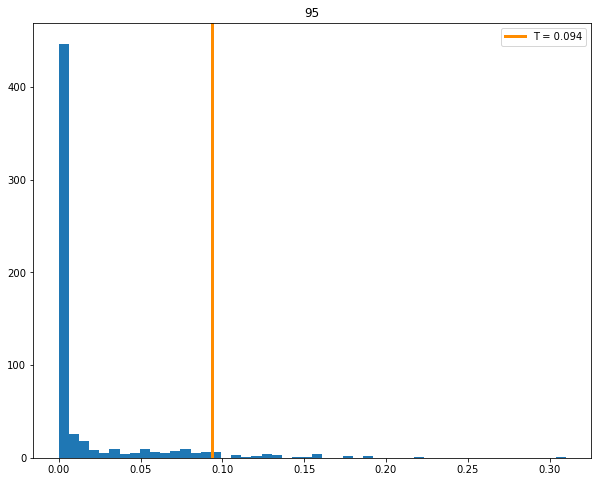

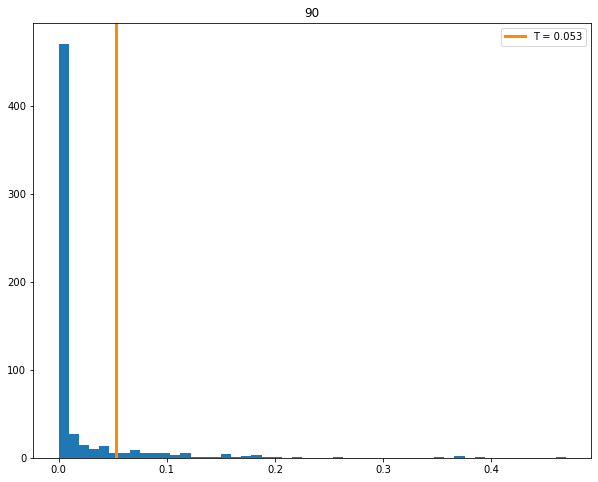

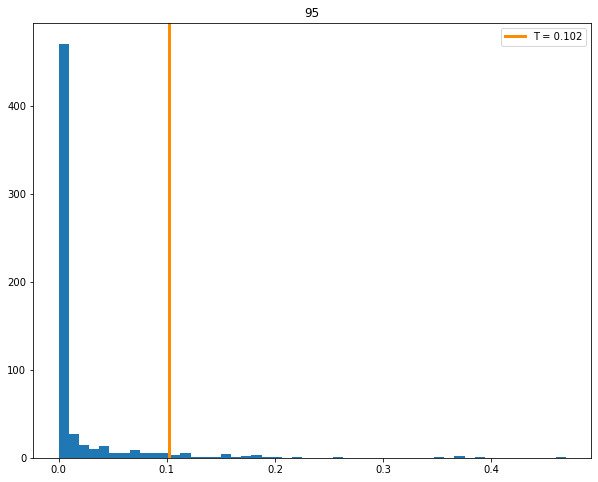

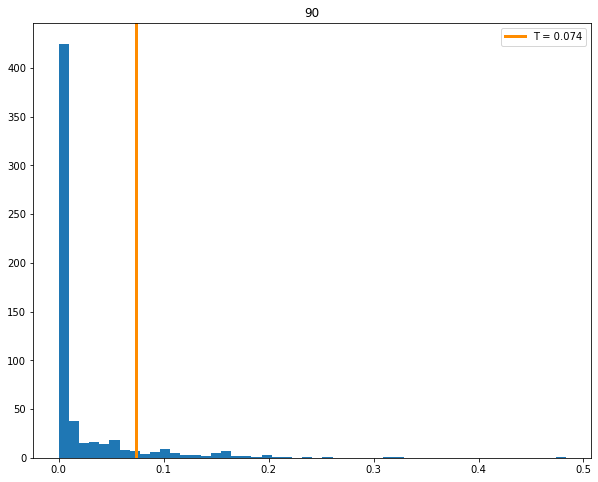

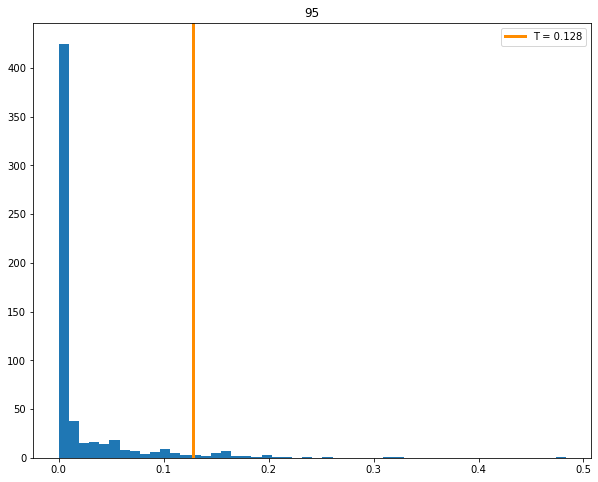

N =  650


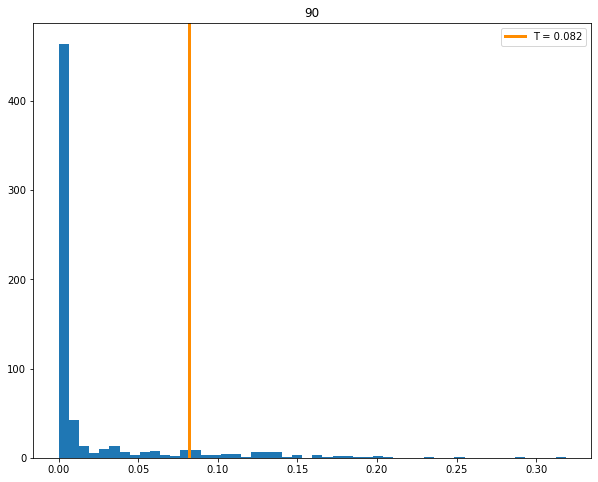

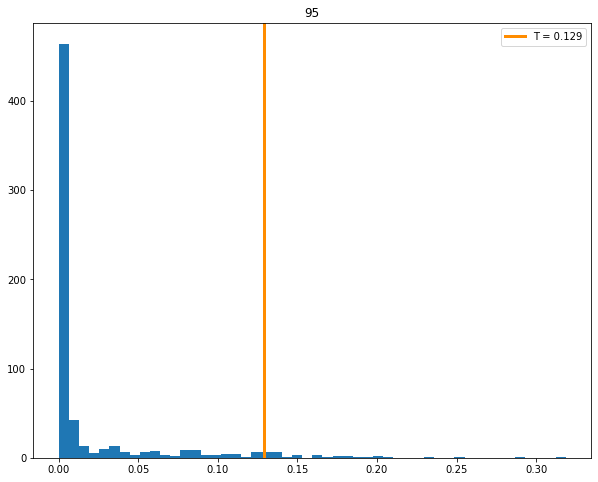

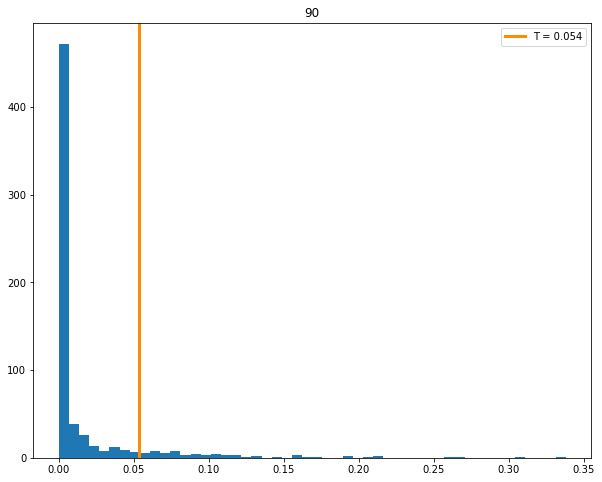

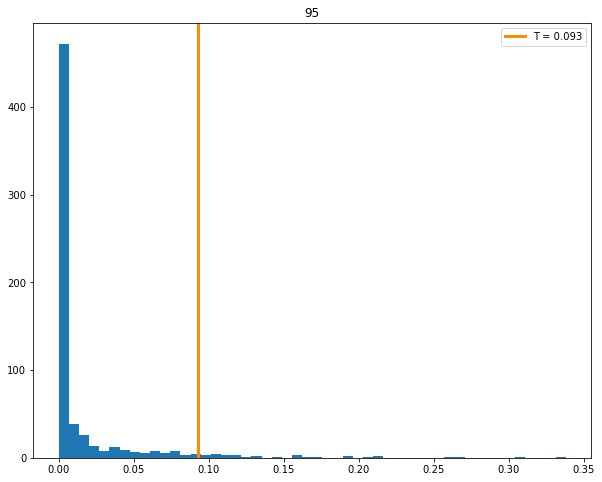

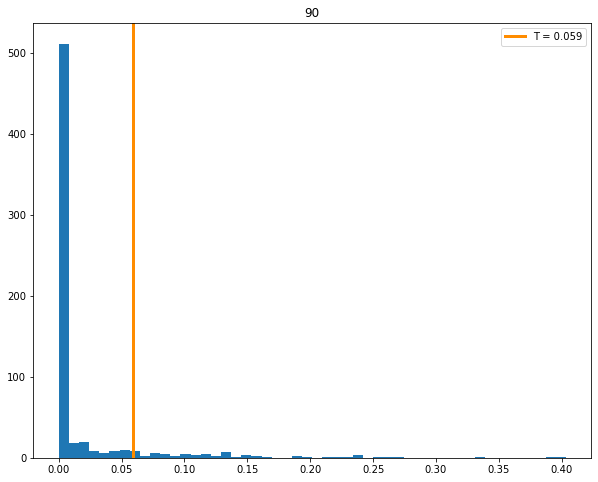

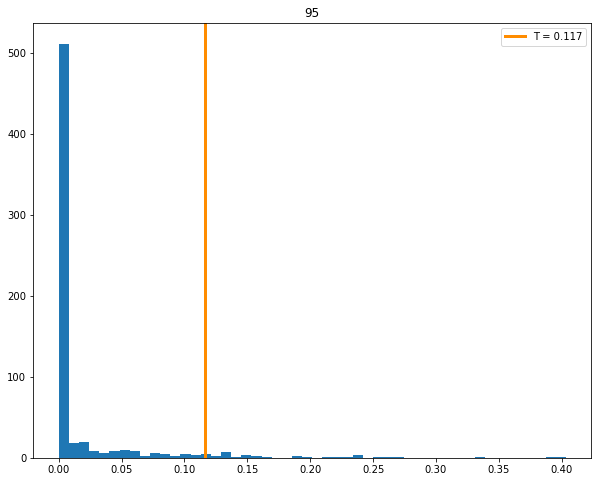

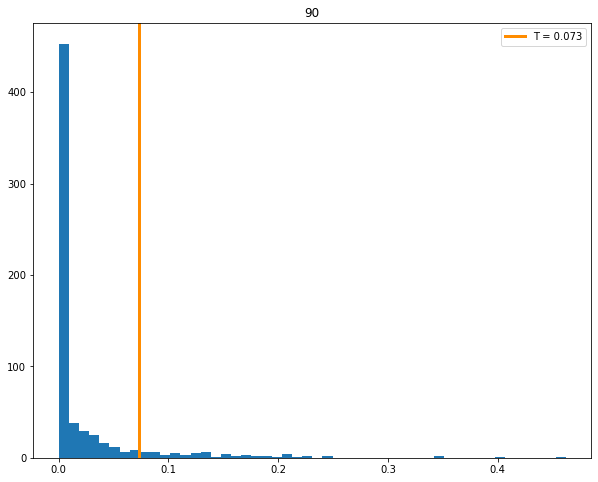

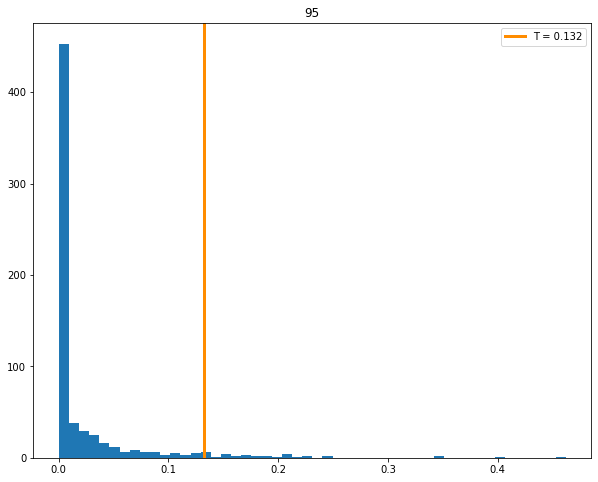

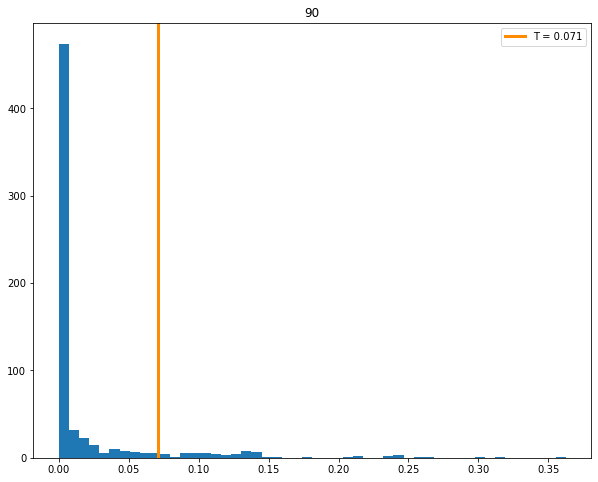

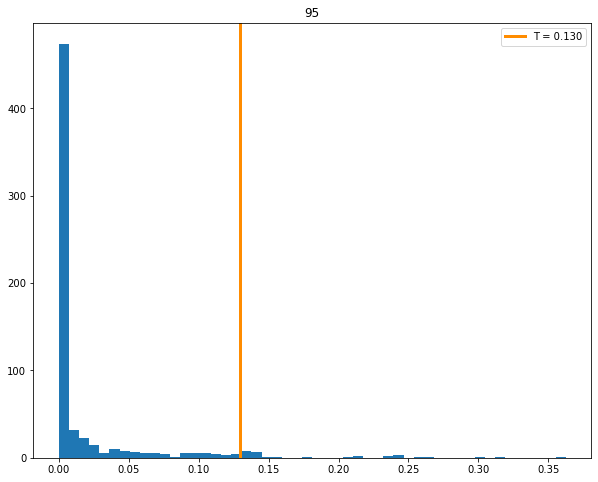

55
N =  300


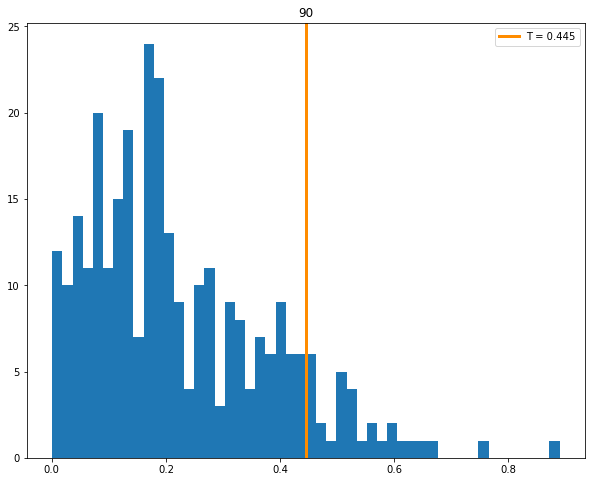

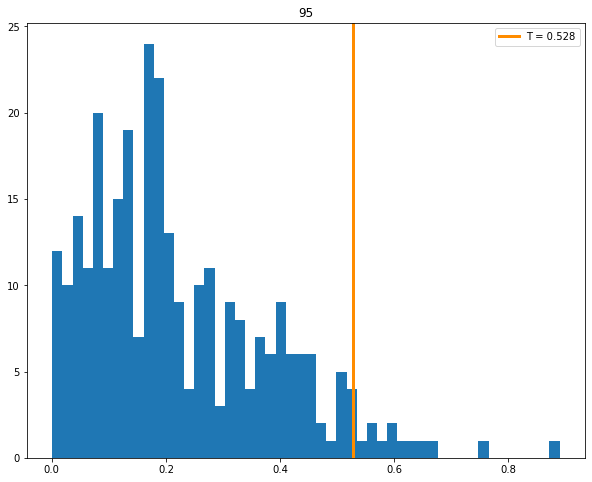

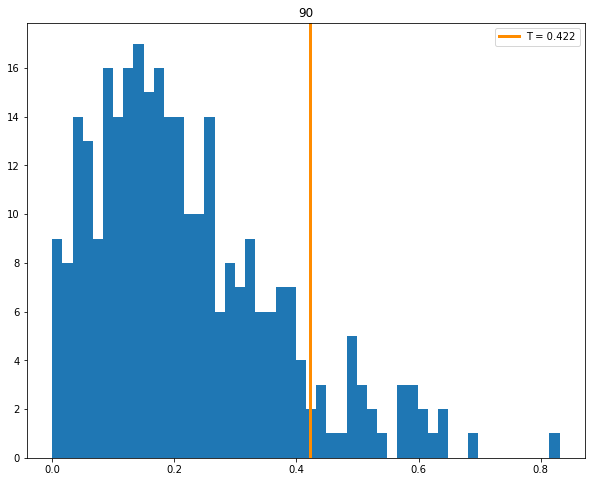

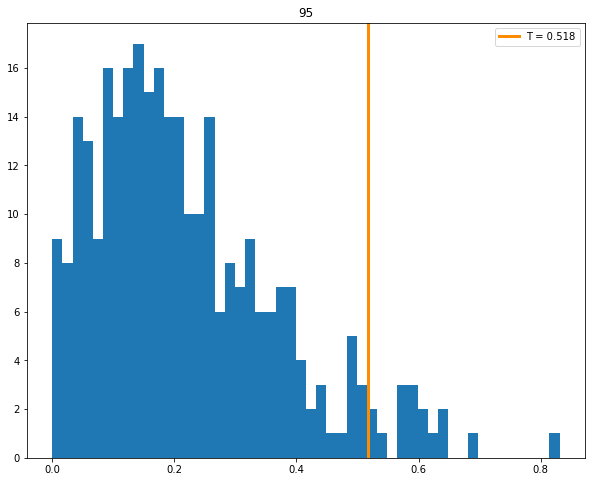

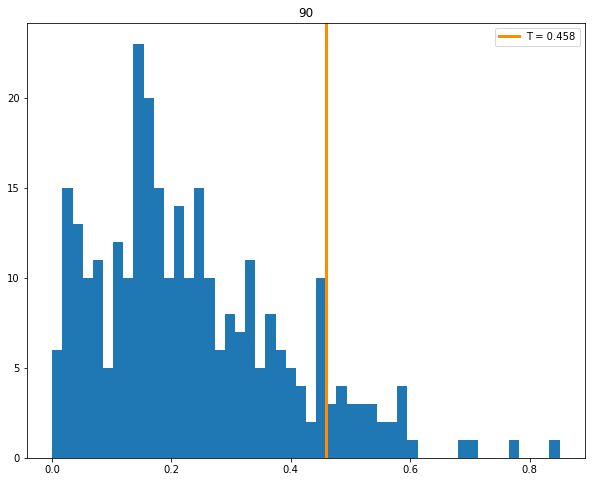

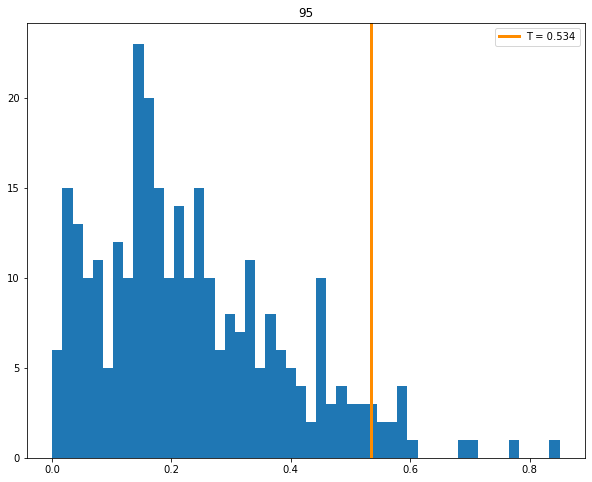

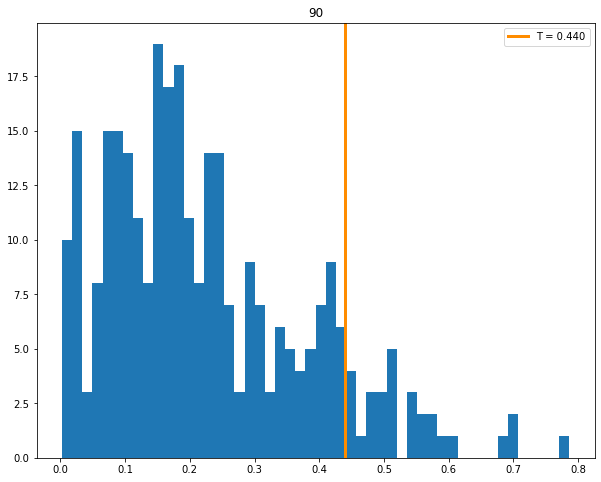

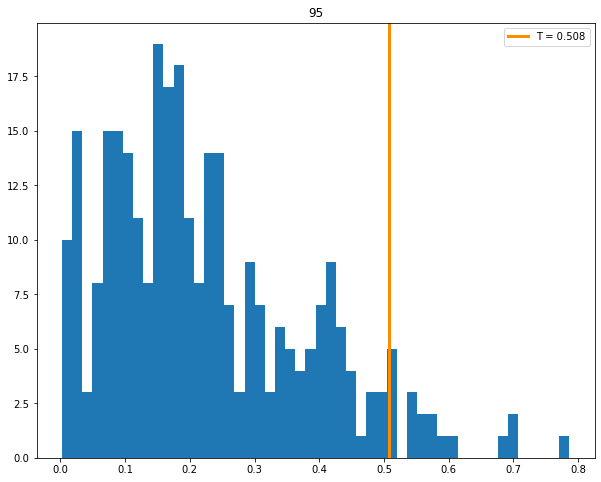

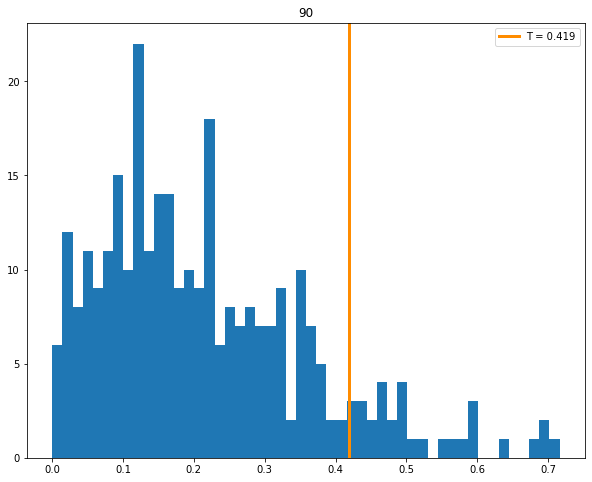

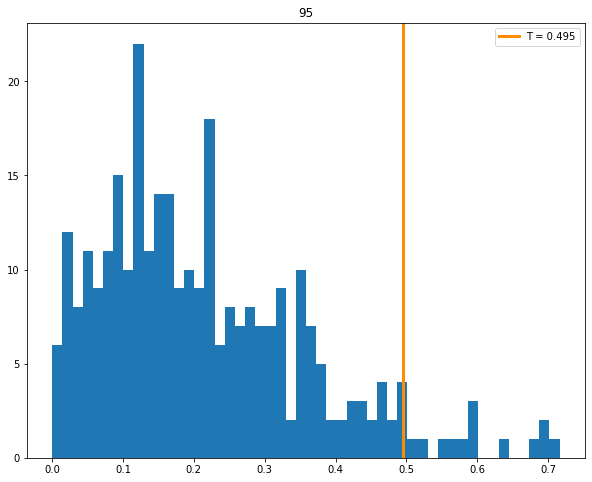

N =  350


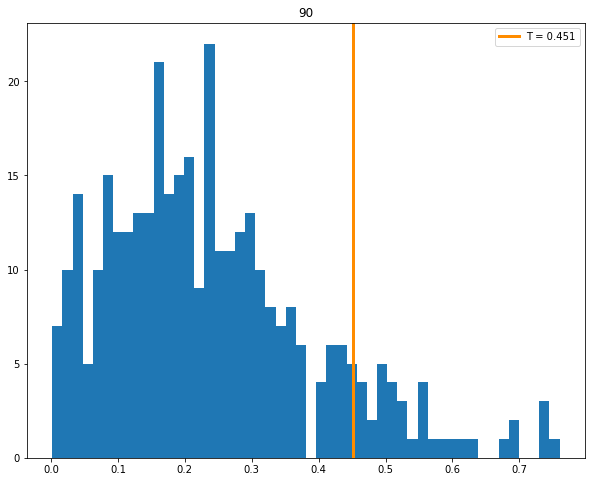

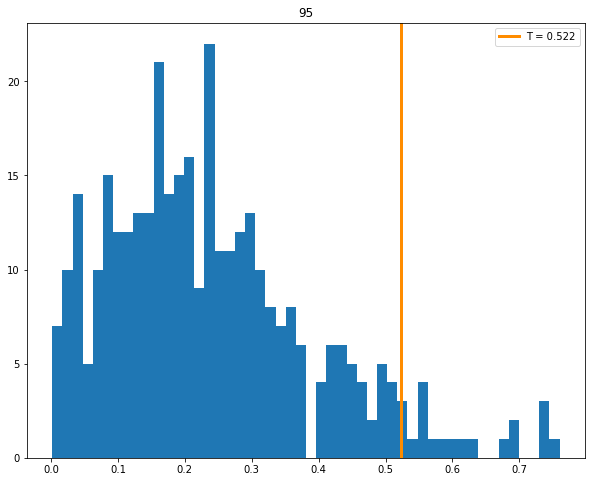

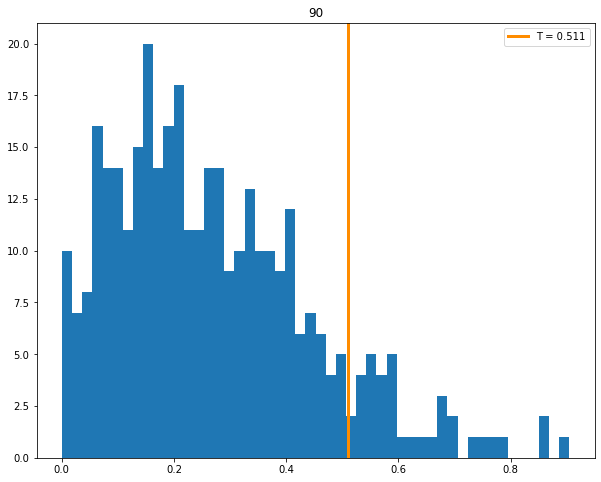

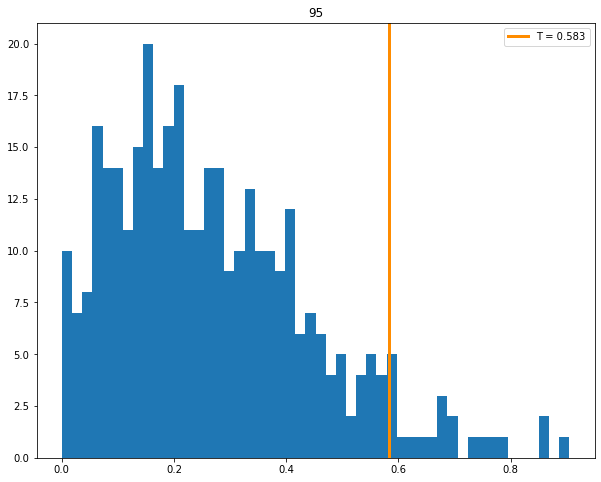

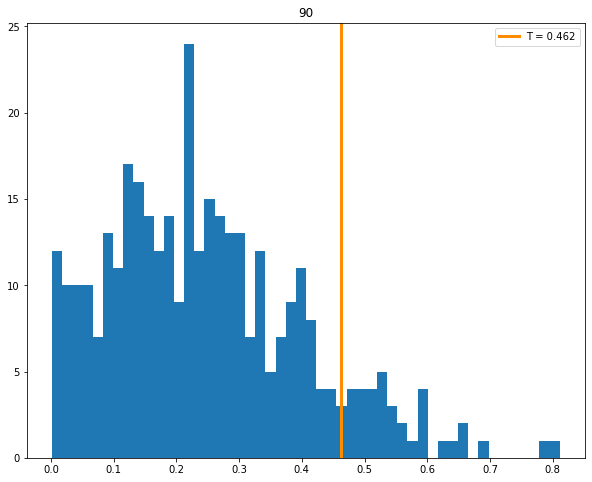

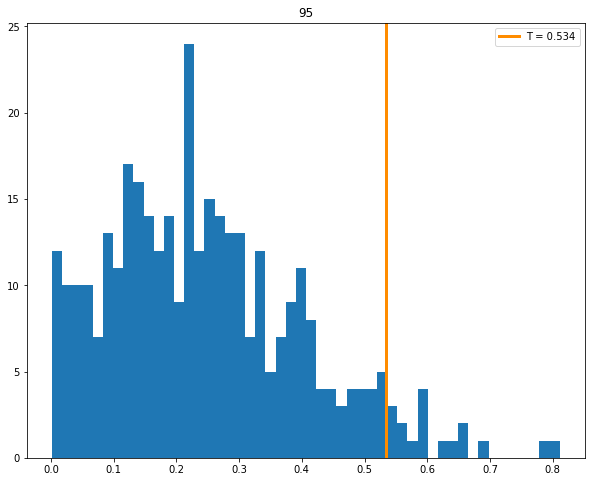

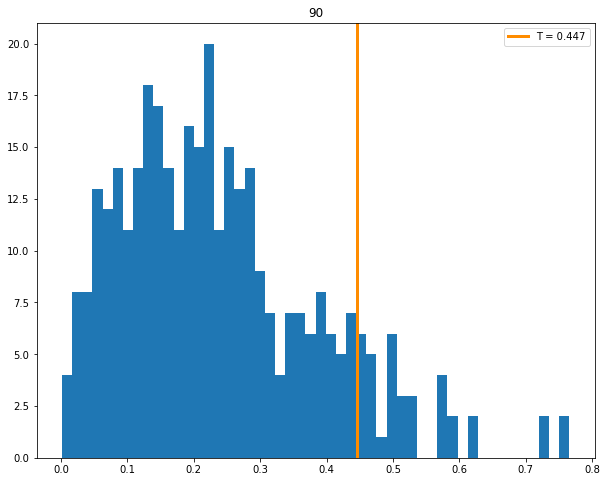

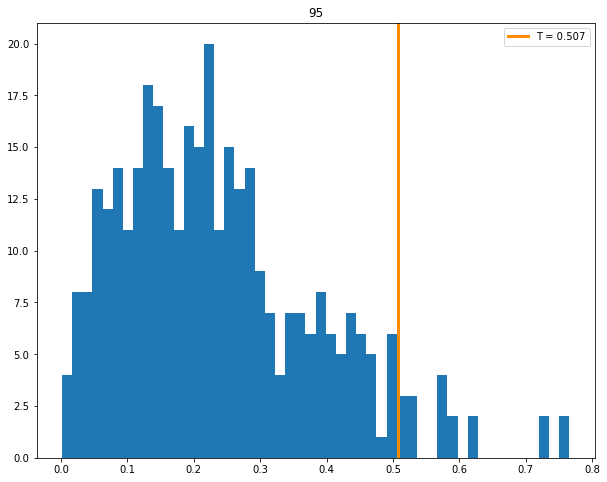

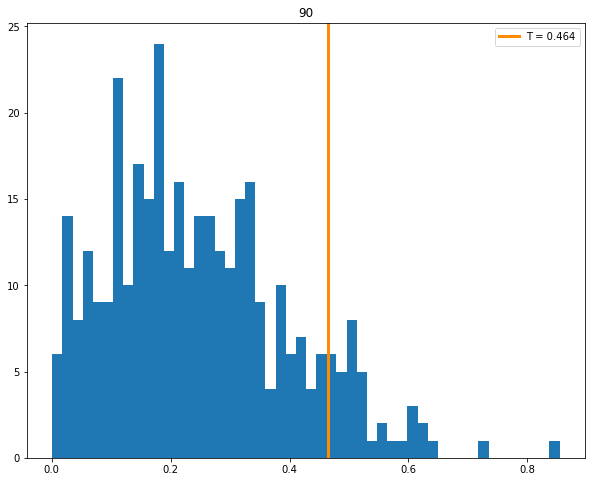

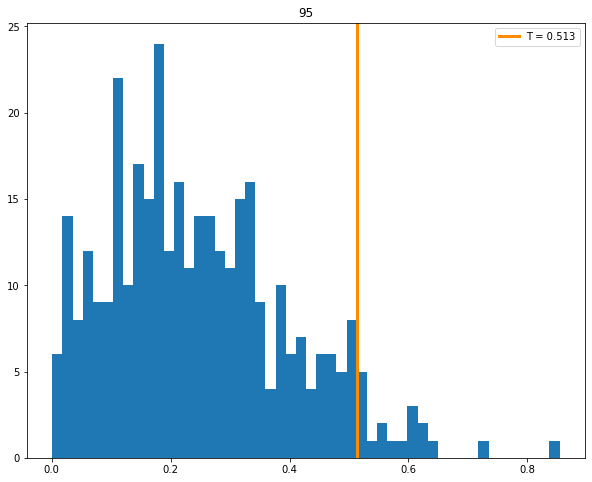

N =  400


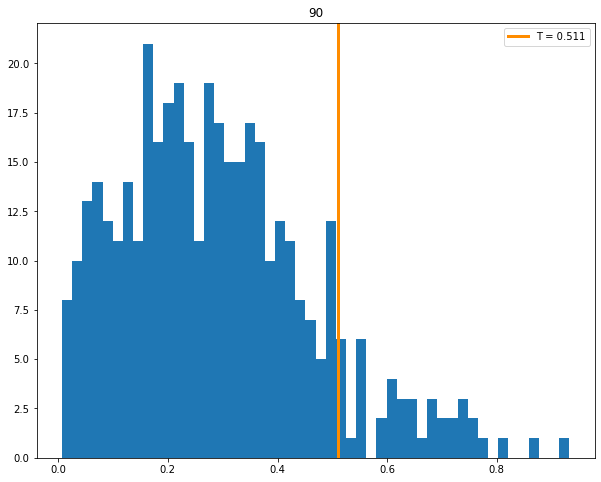

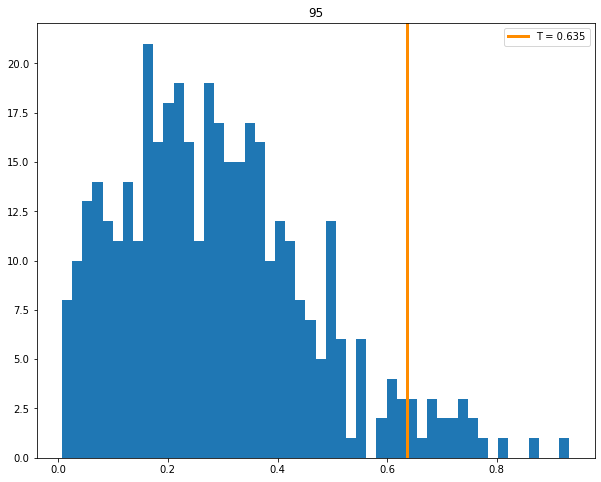

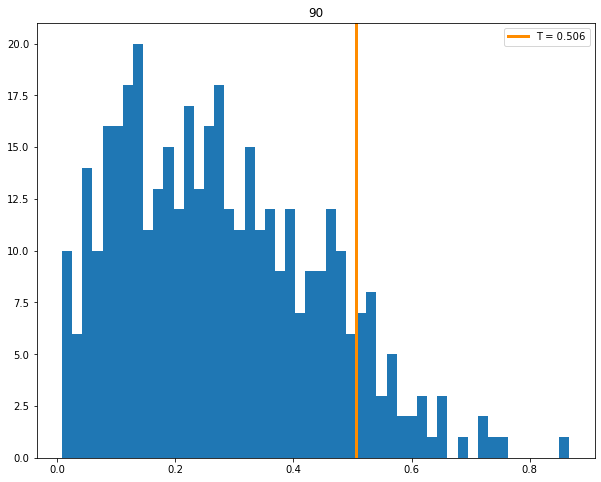

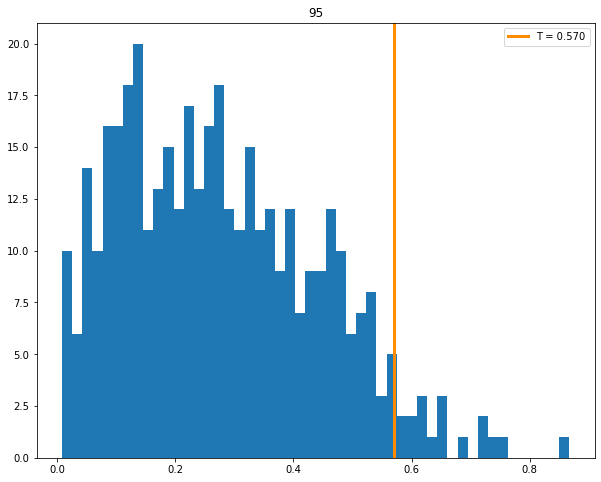

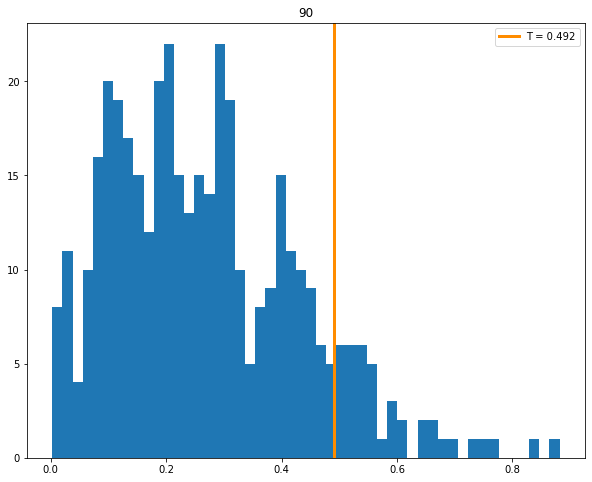

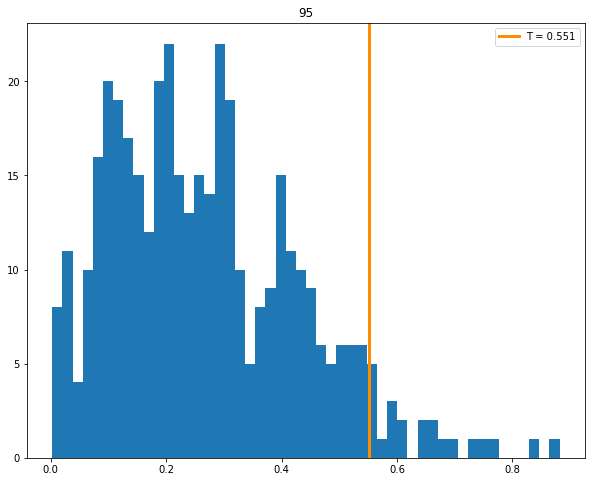

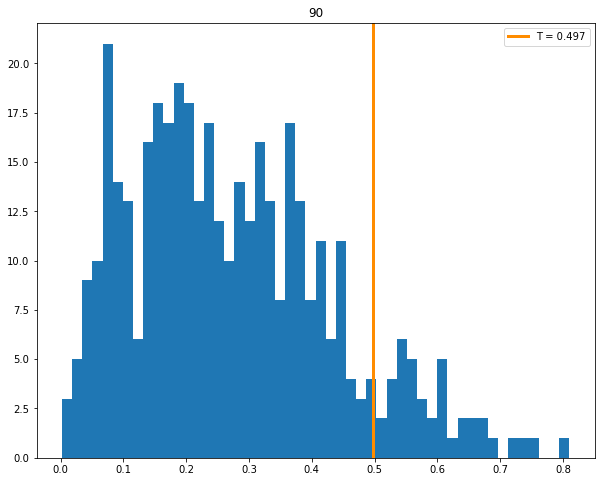

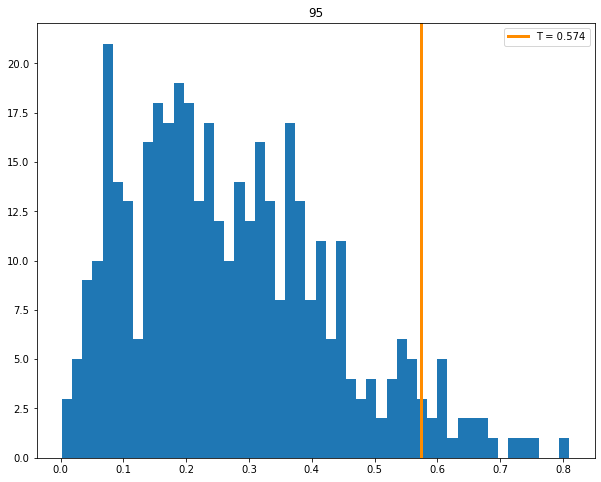

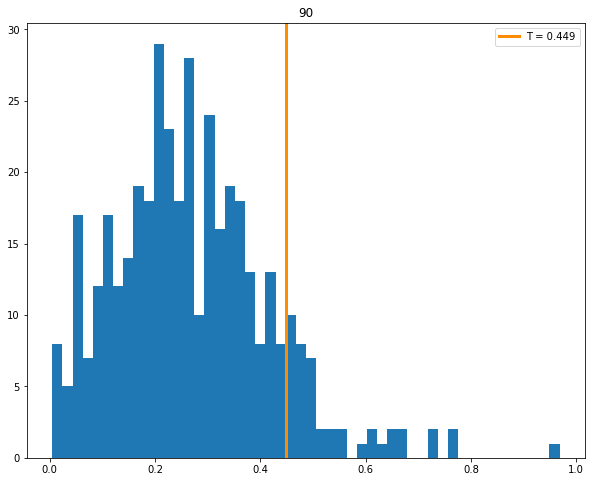

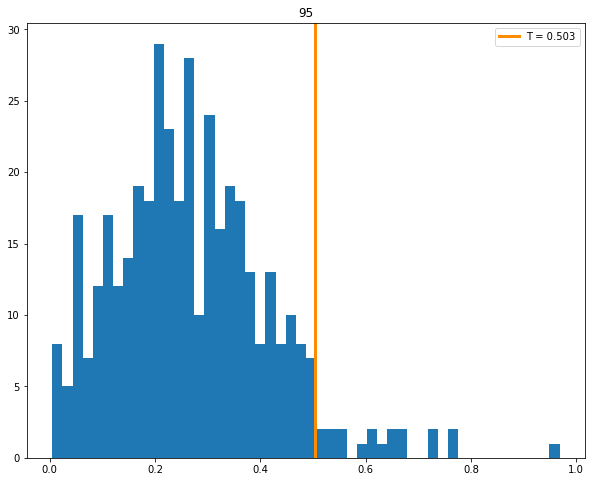

N =  450


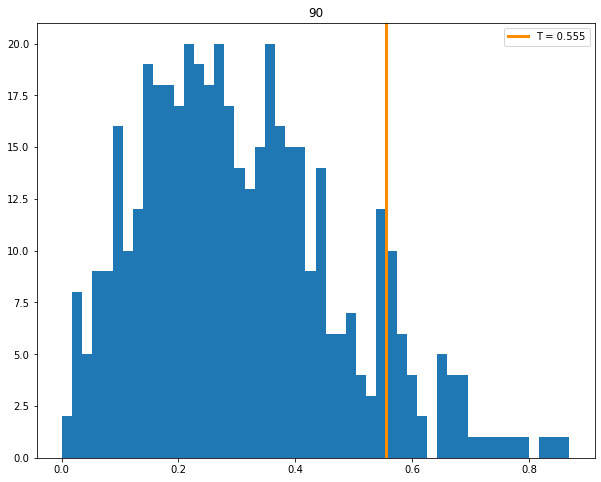

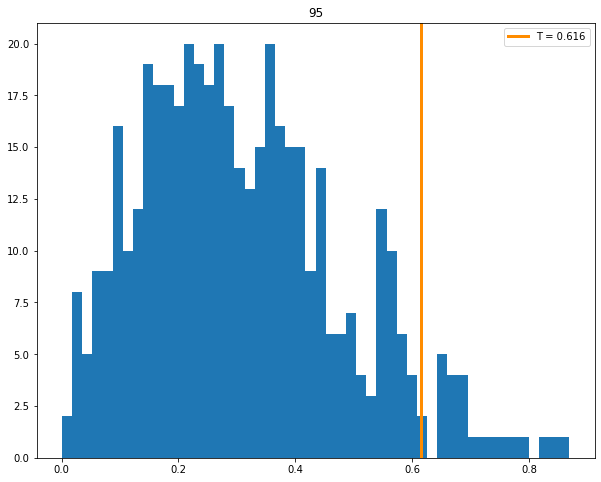

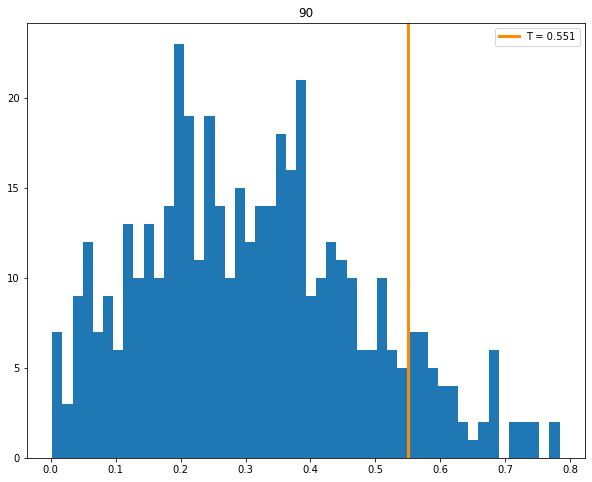

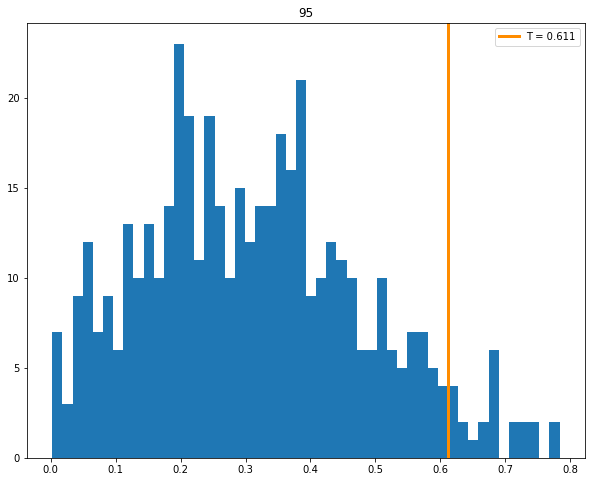

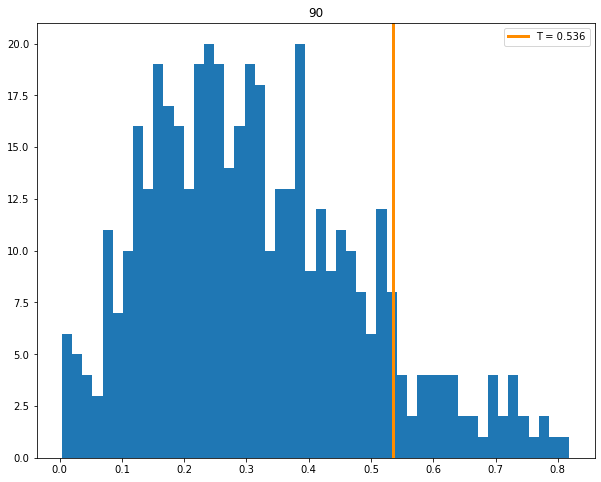

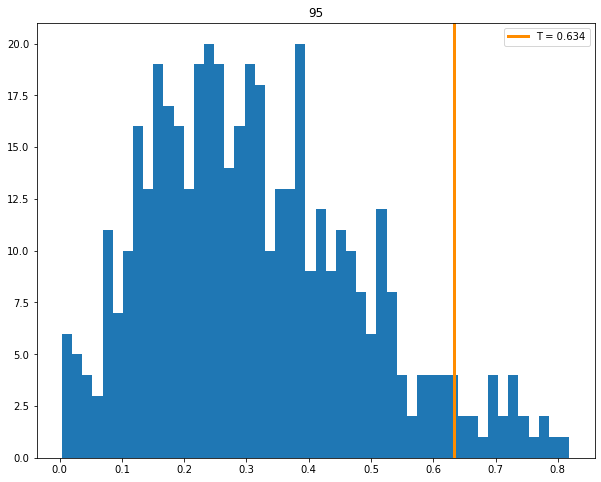

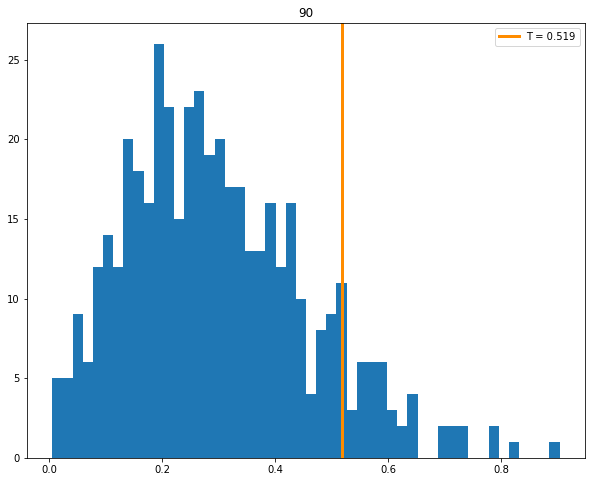

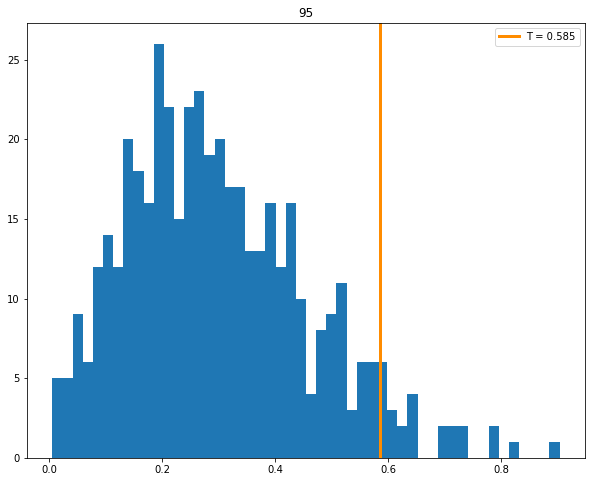

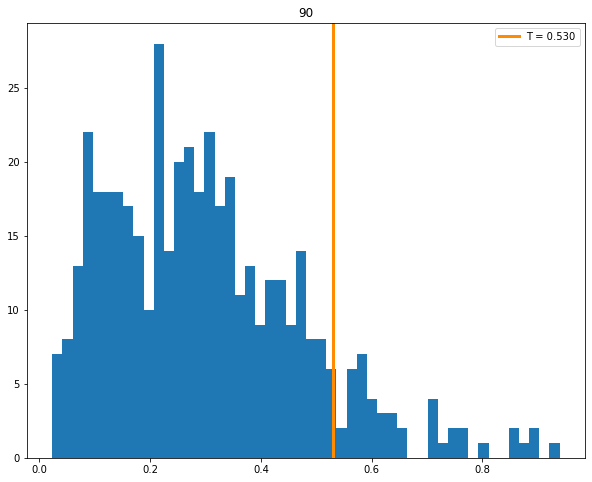

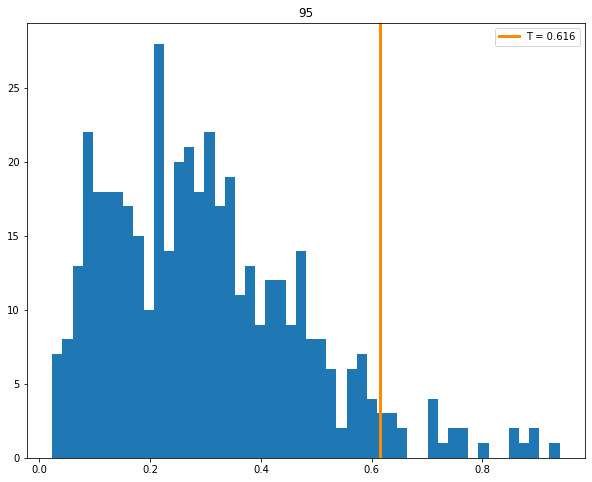

N =  500


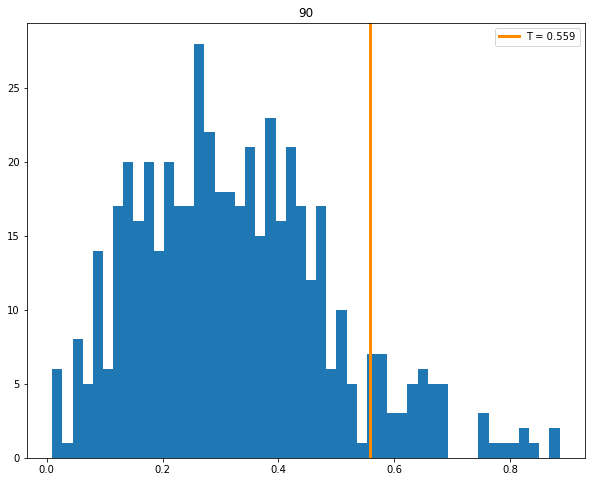

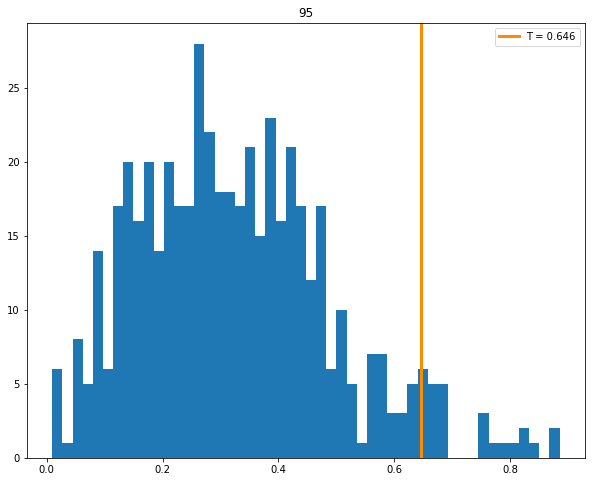

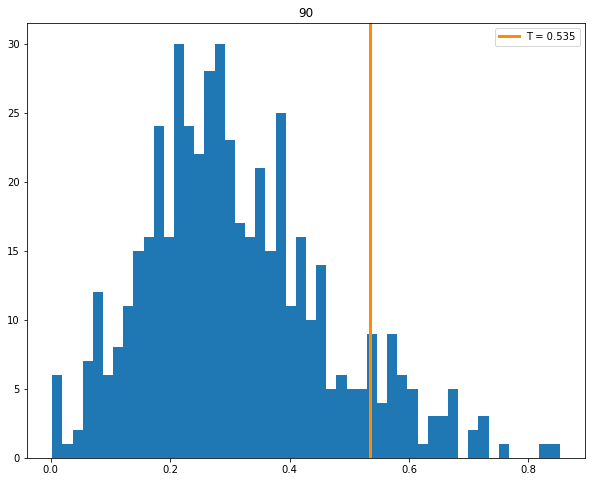

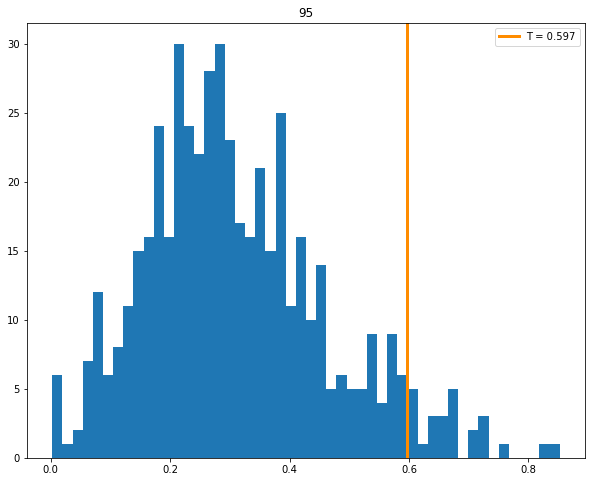

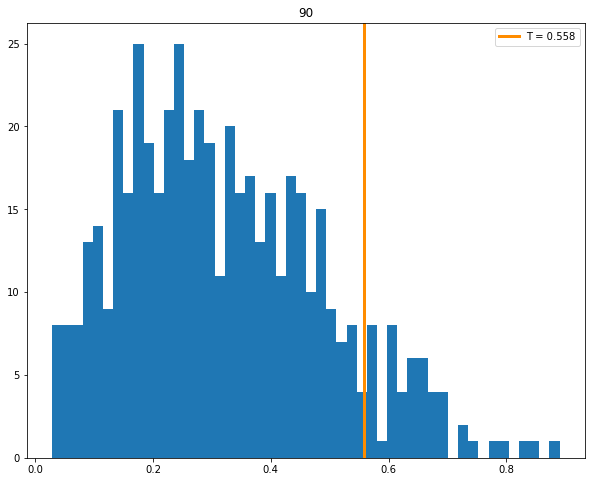

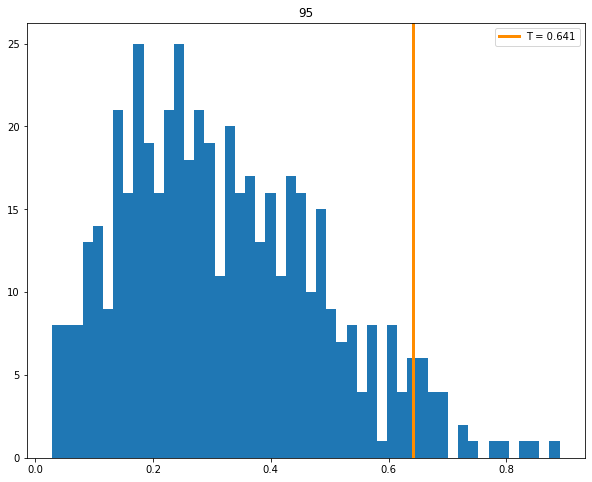

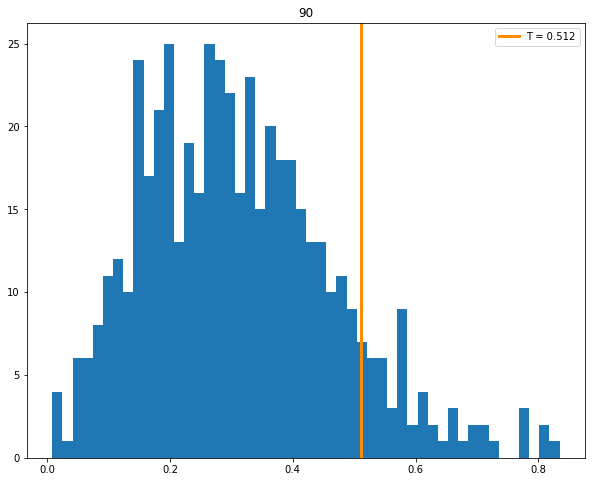

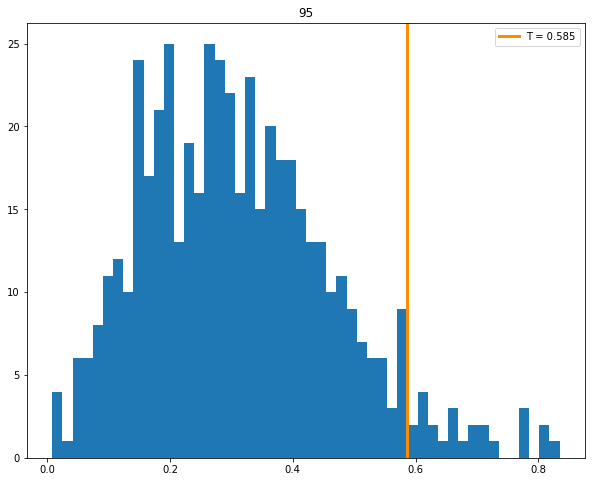

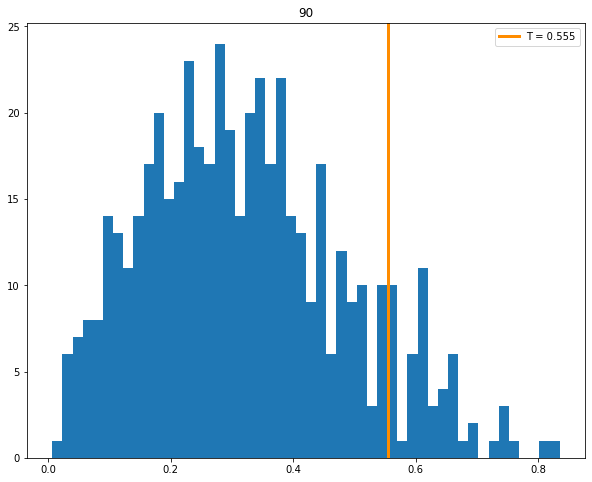

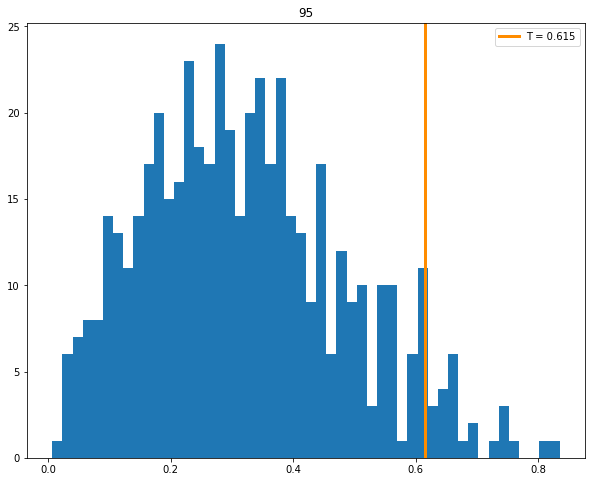

N =  550


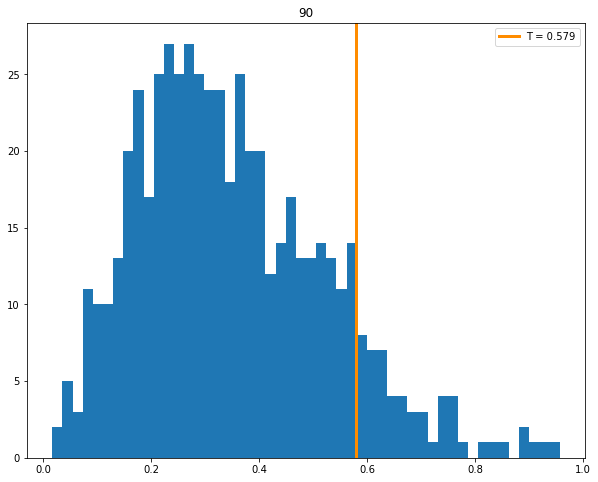

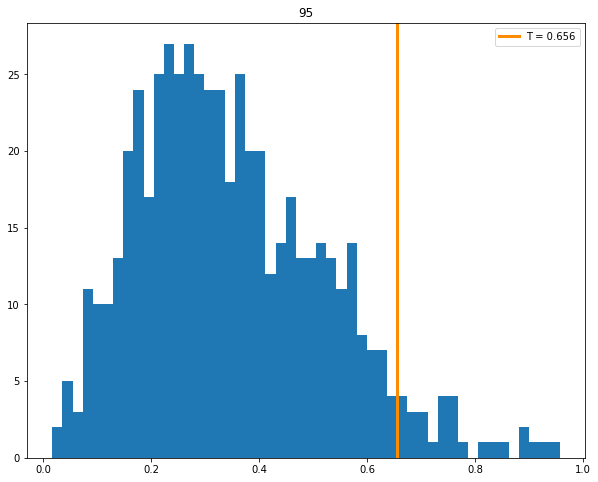

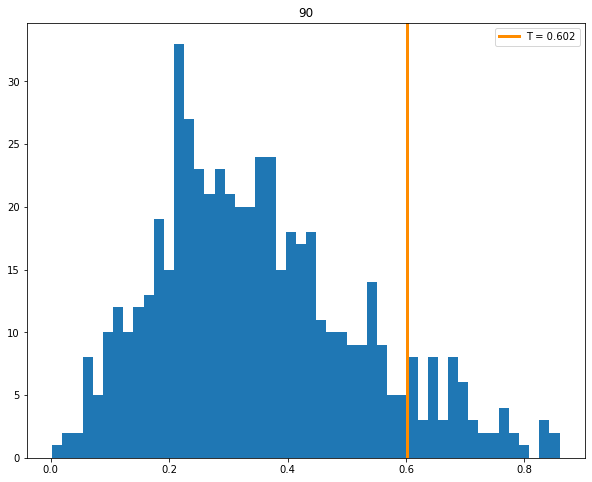

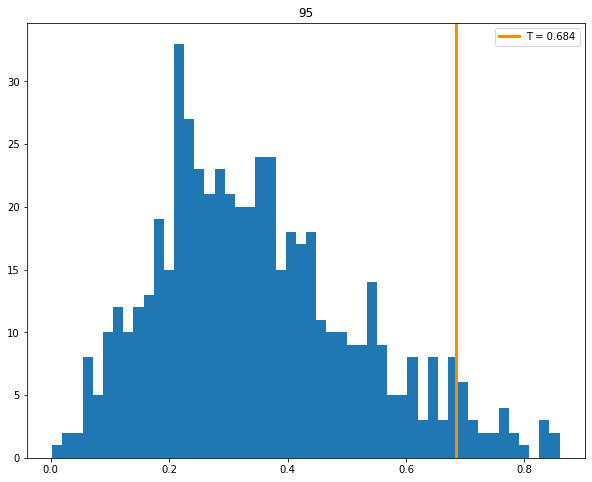

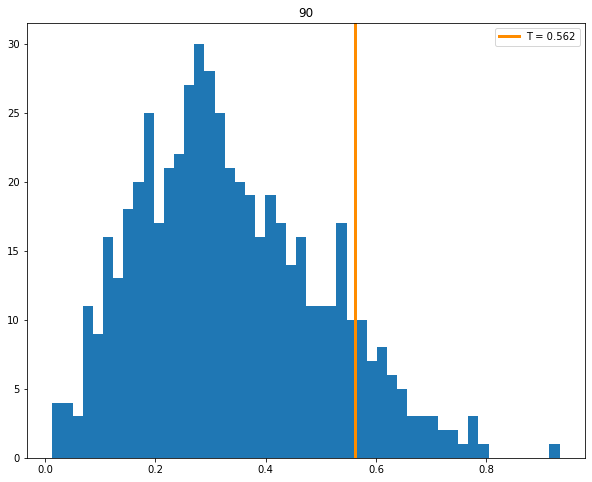

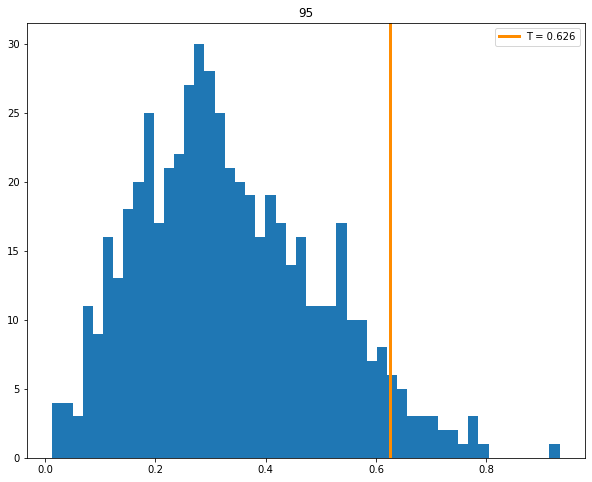

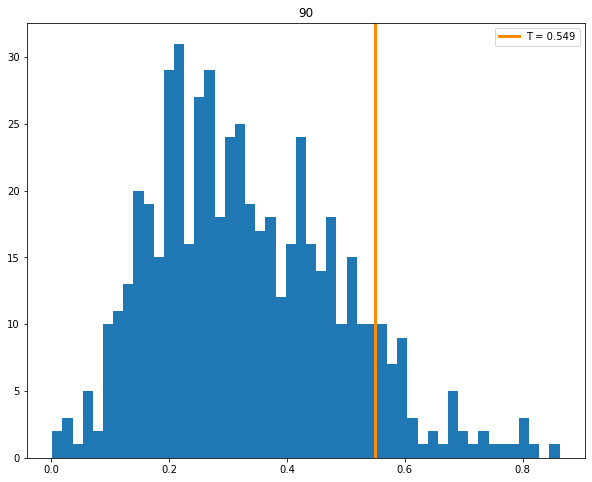

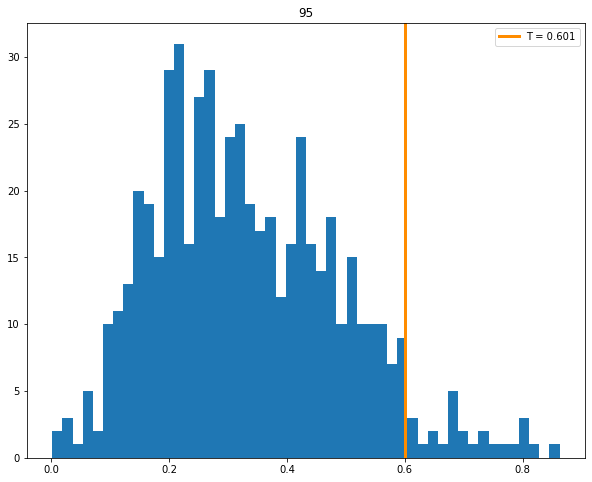

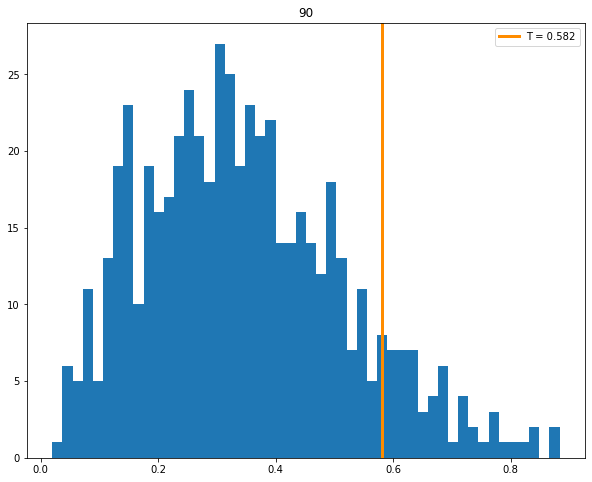

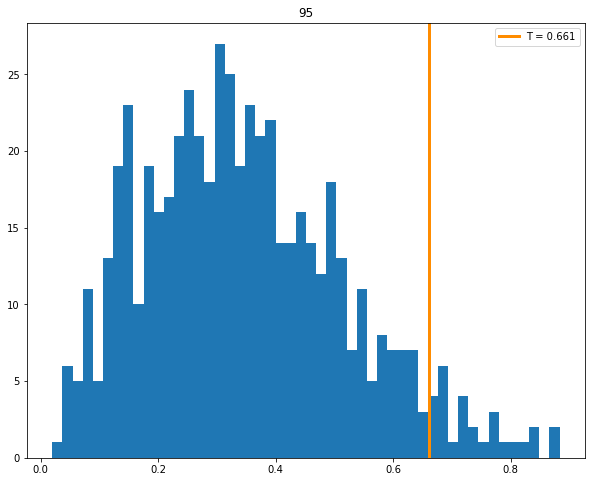

N =  600


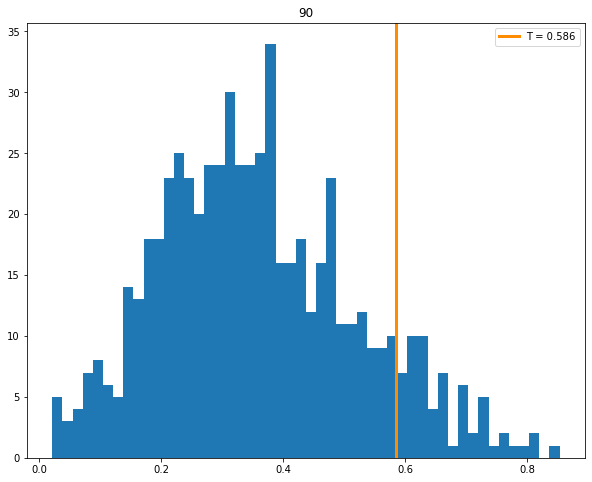

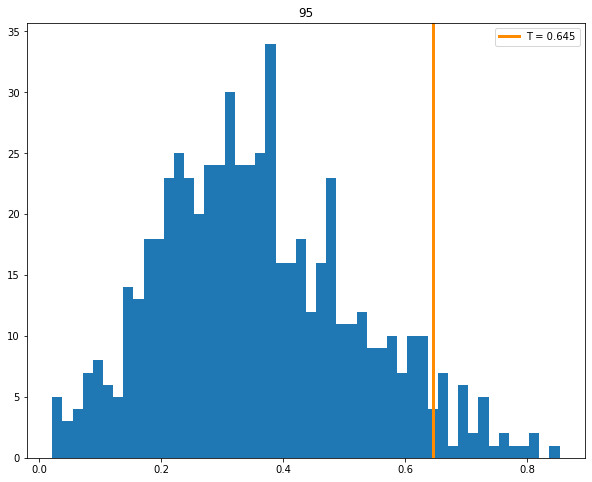

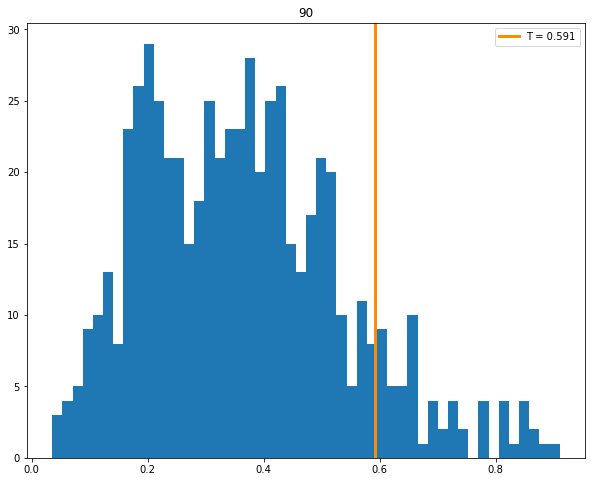

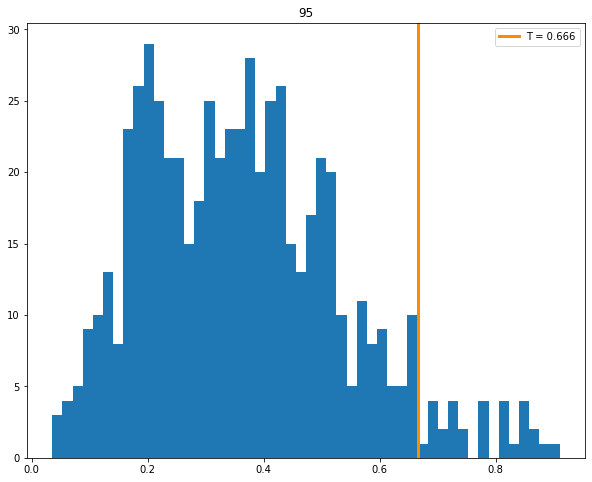

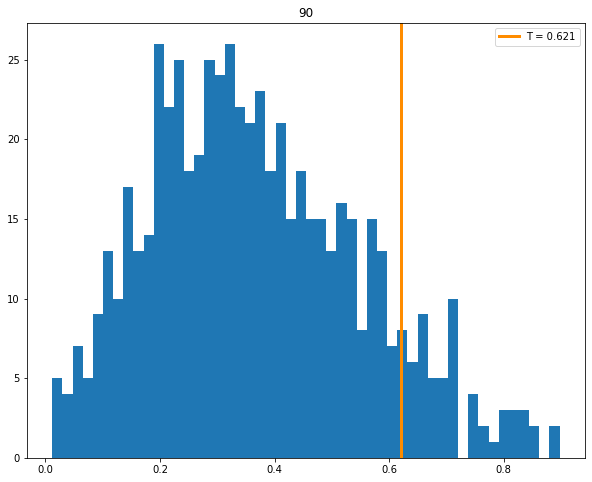

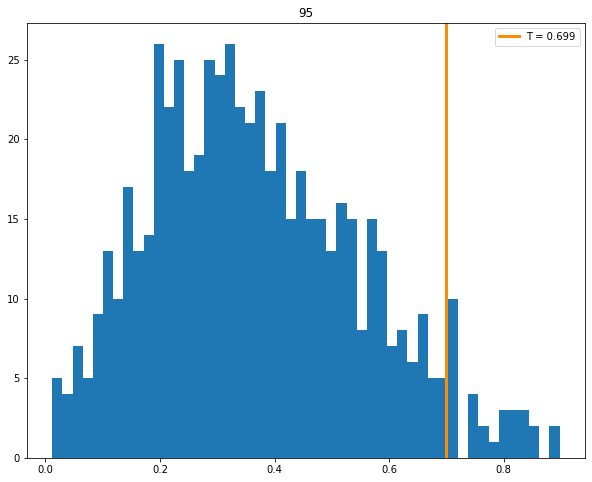

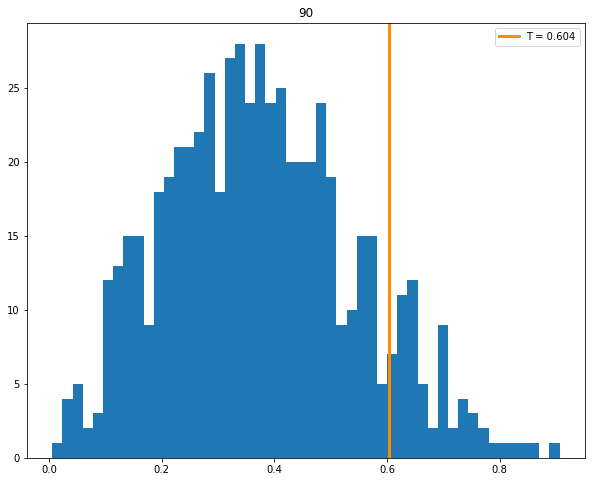

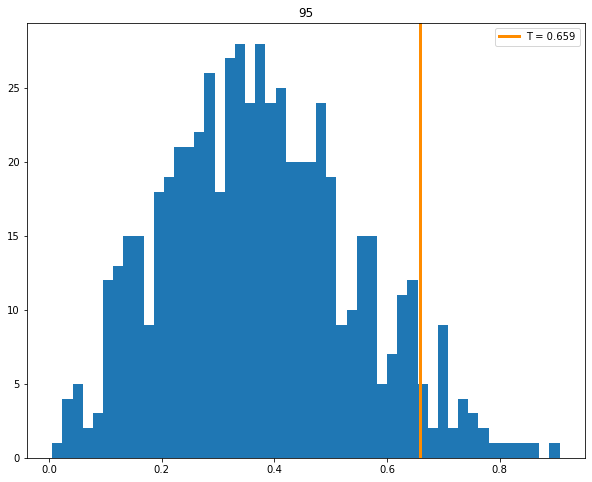

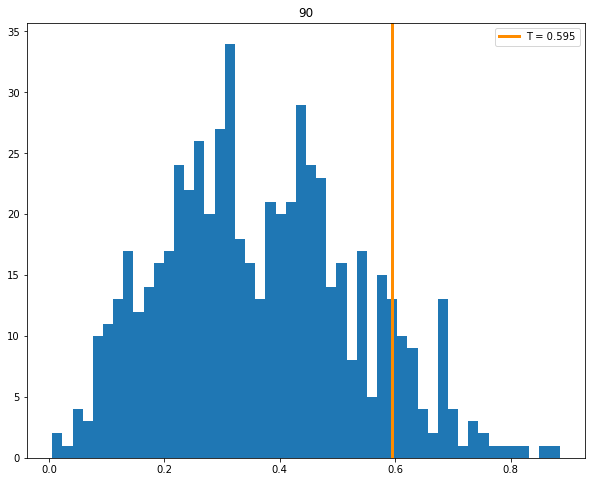

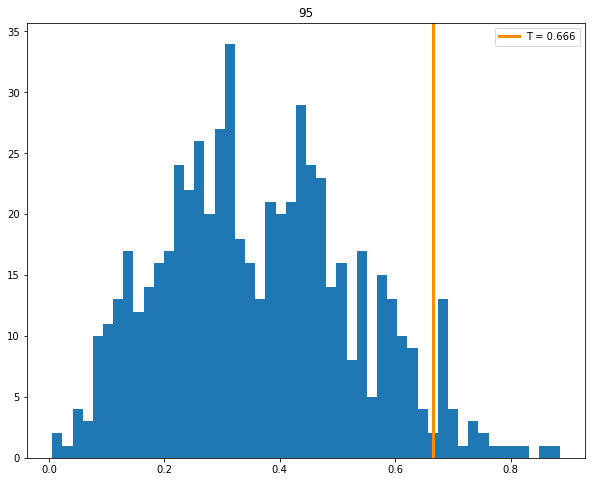

N =  650


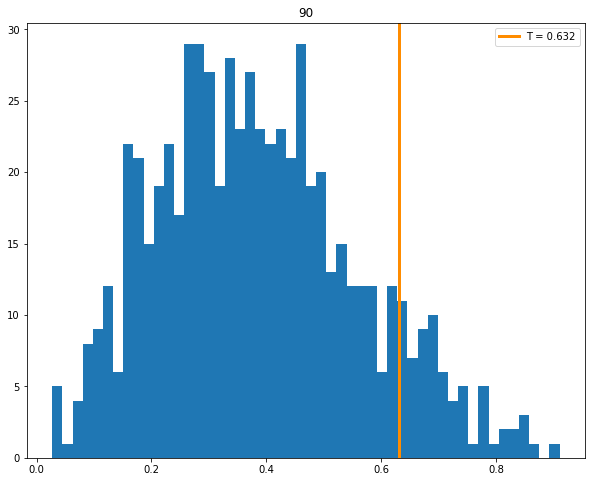

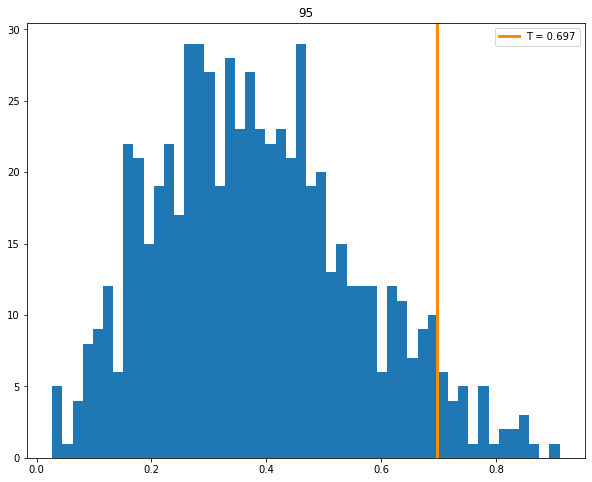

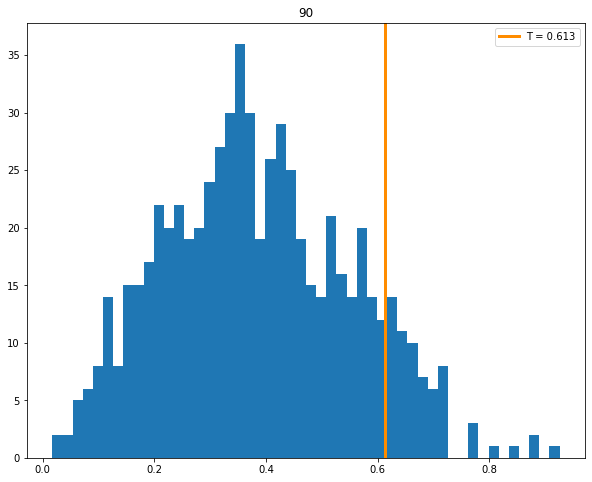

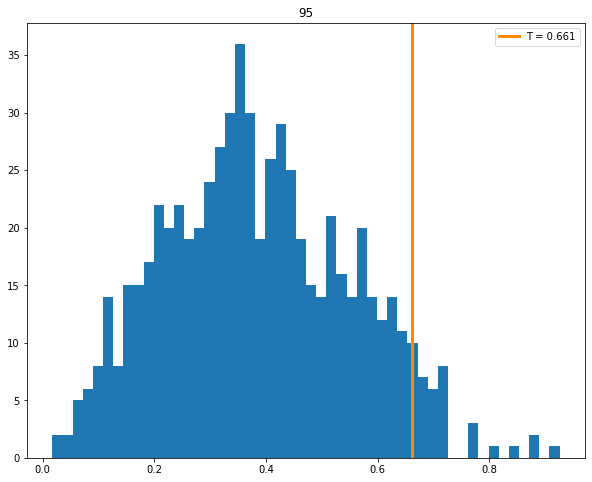

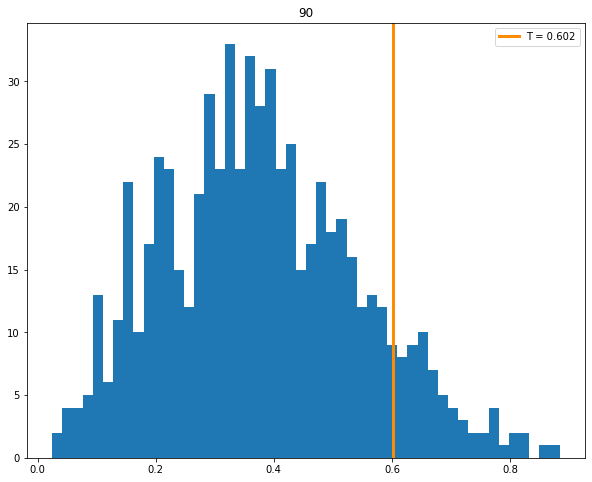

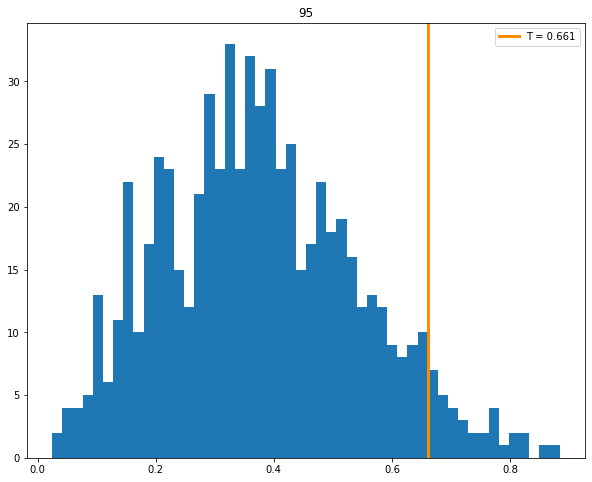

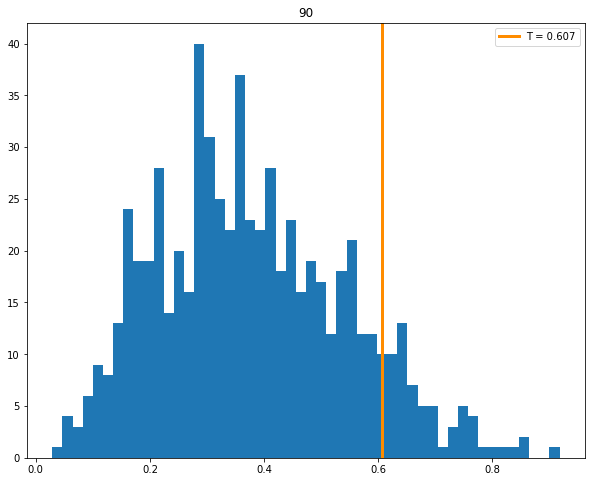

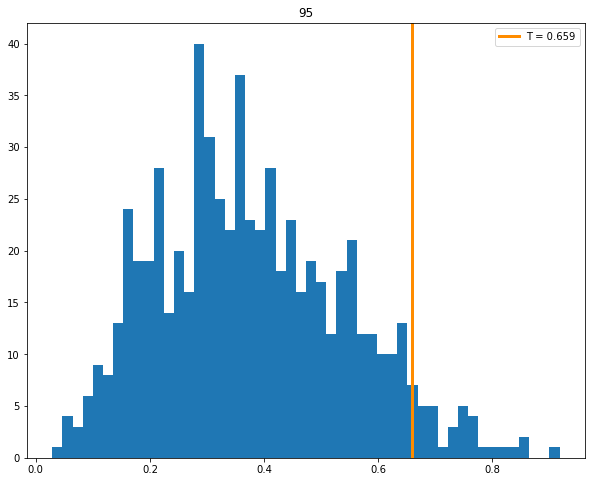

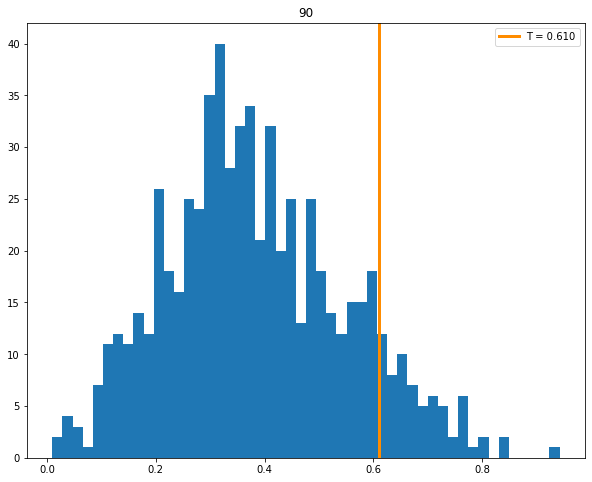

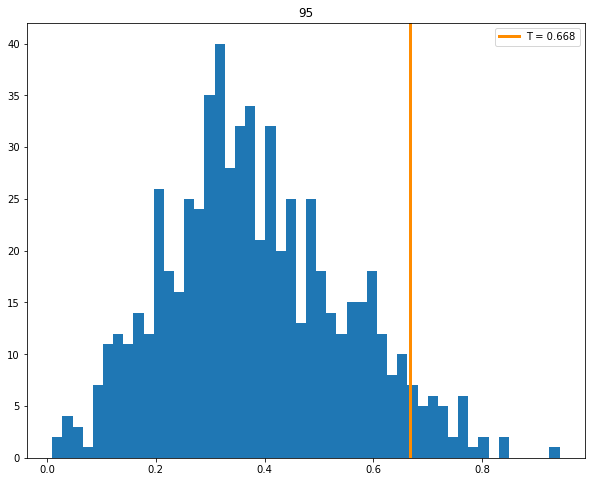

100
N =  300


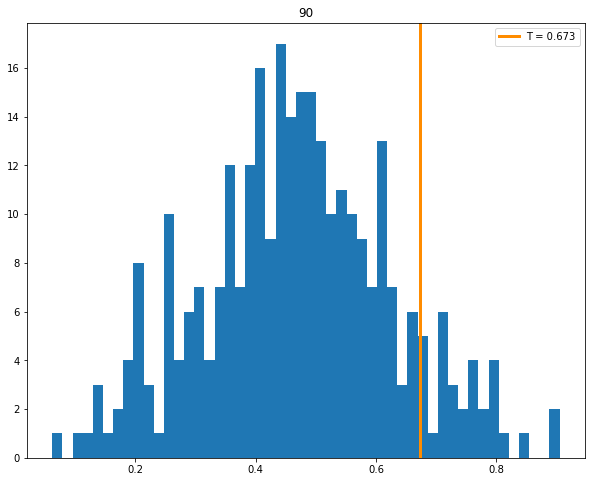

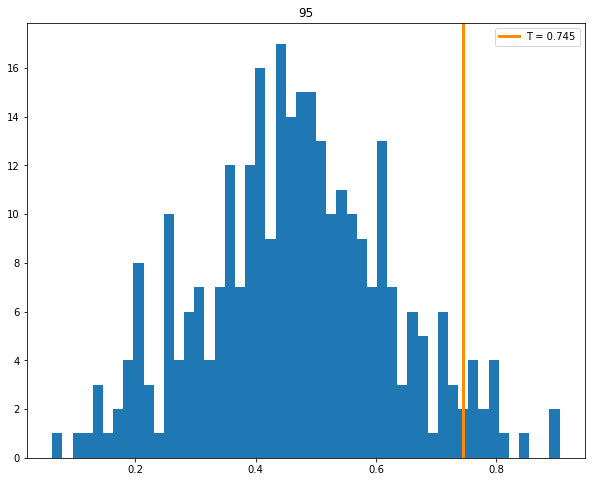

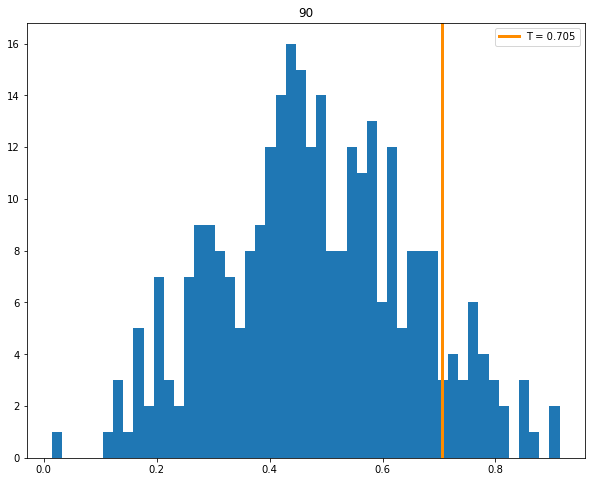

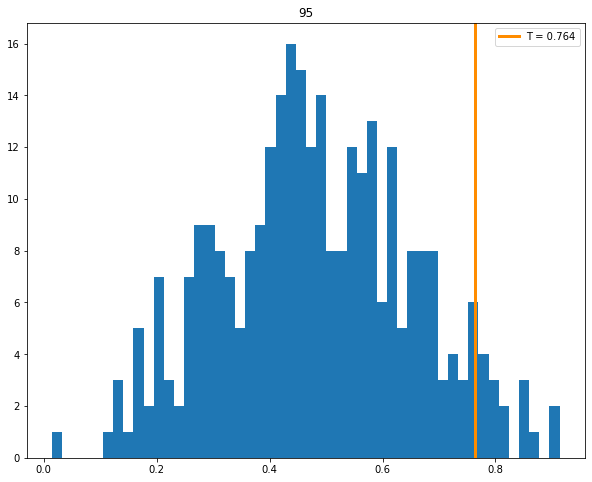

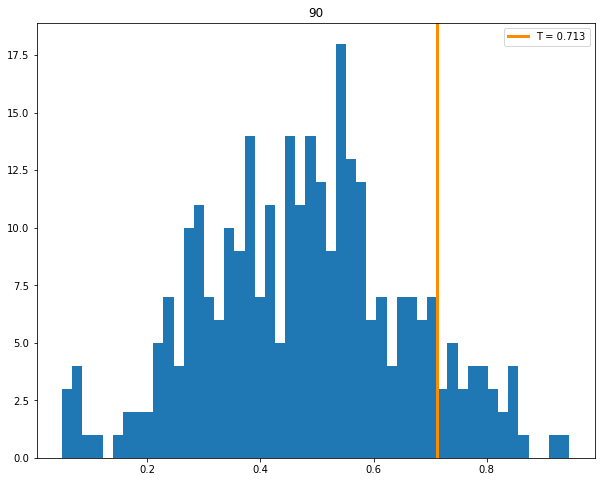

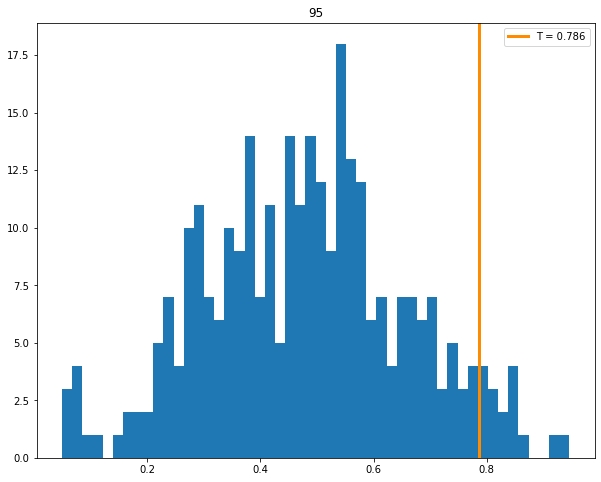

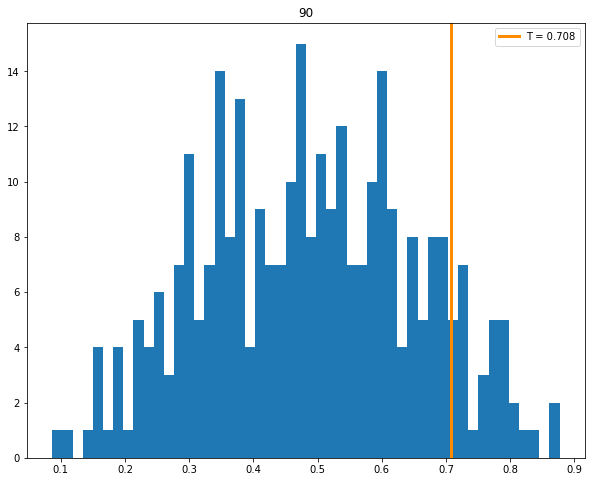

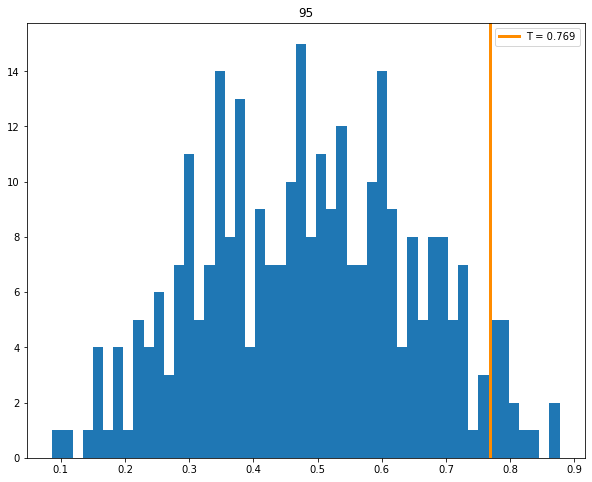

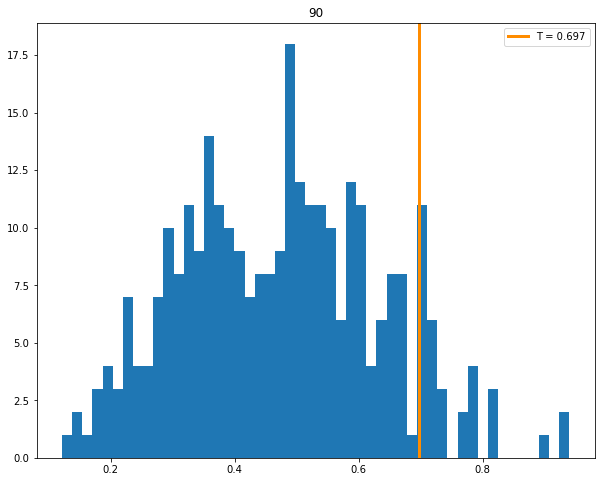

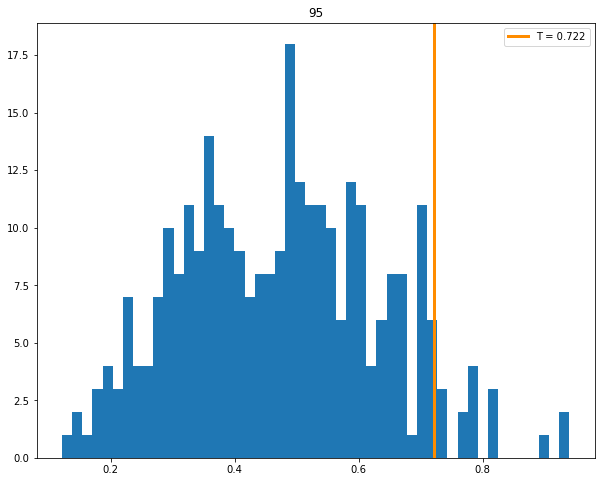

N =  350


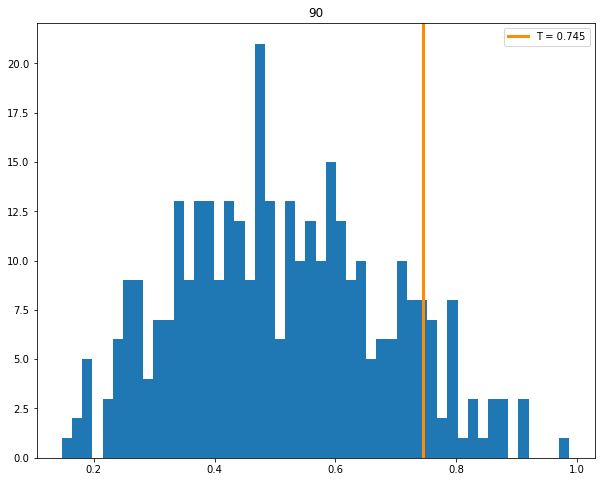

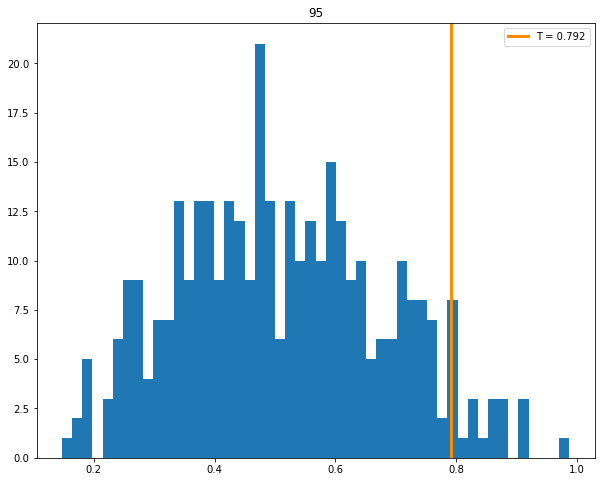

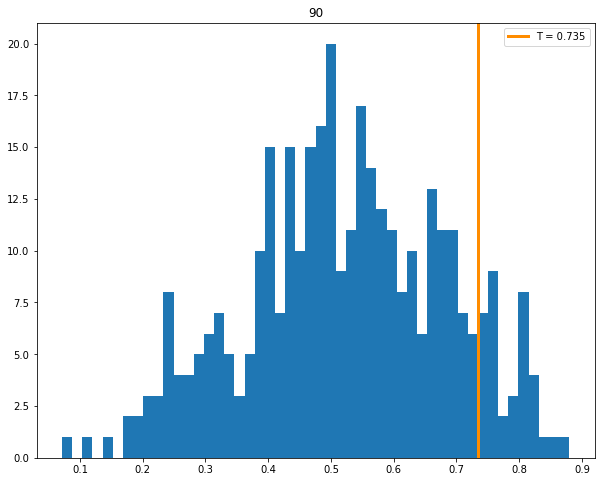

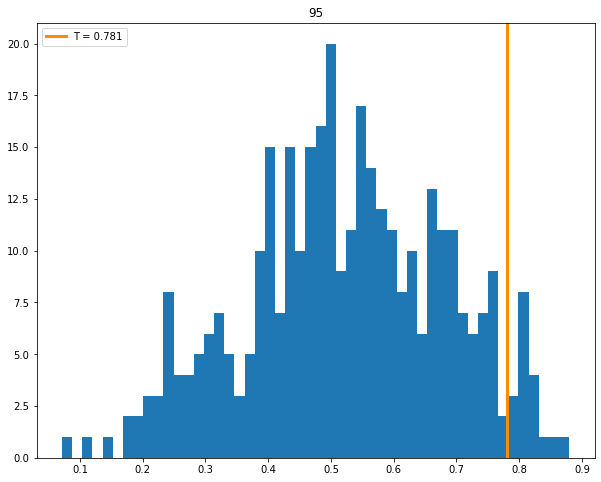

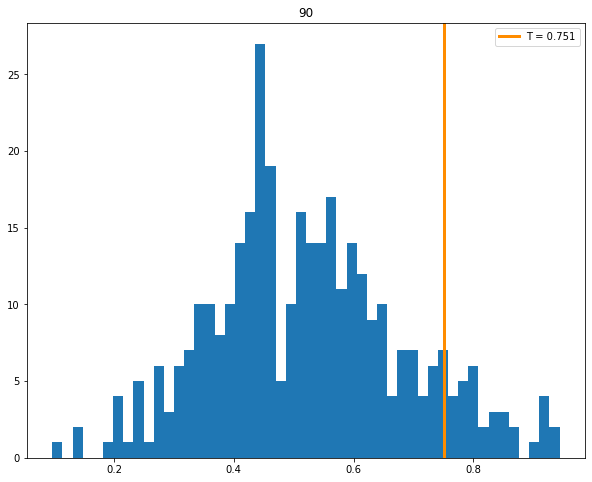

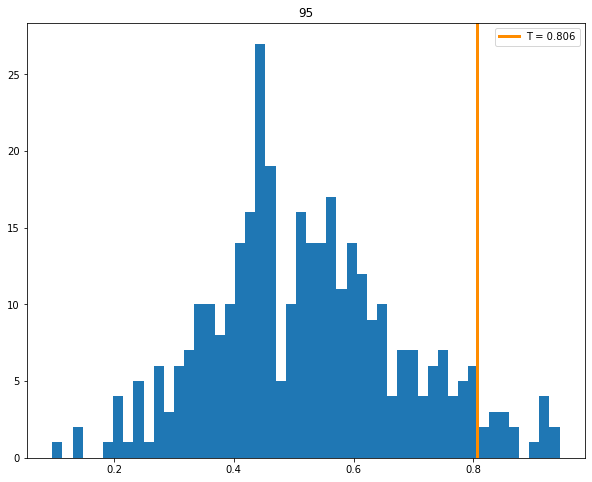

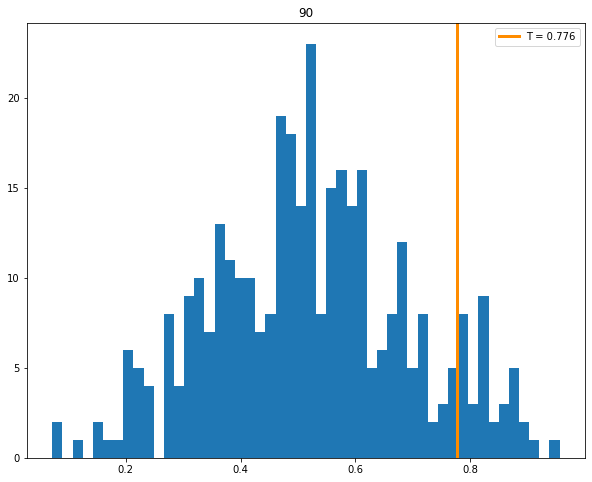

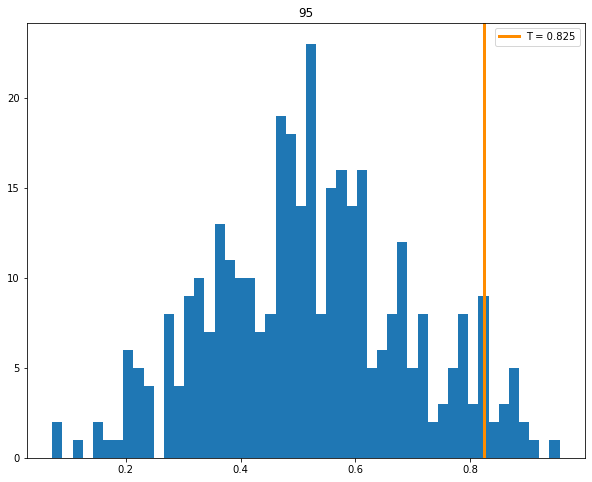

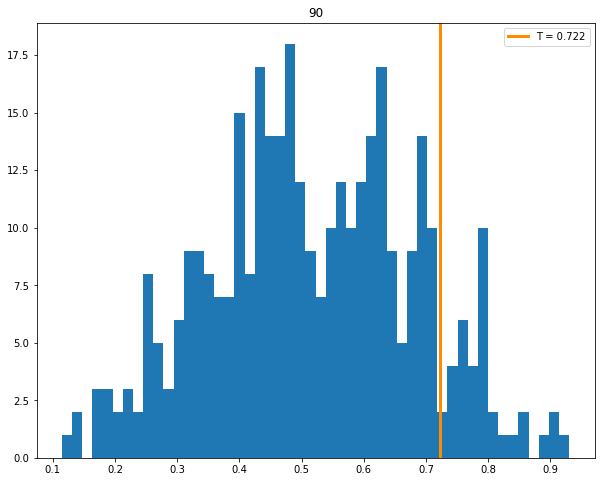

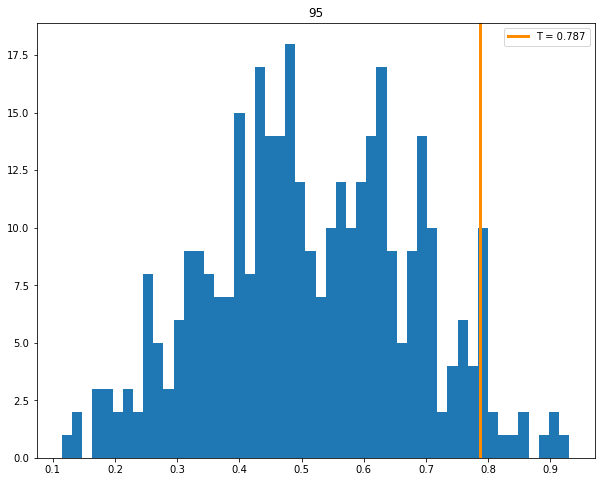

N =  400


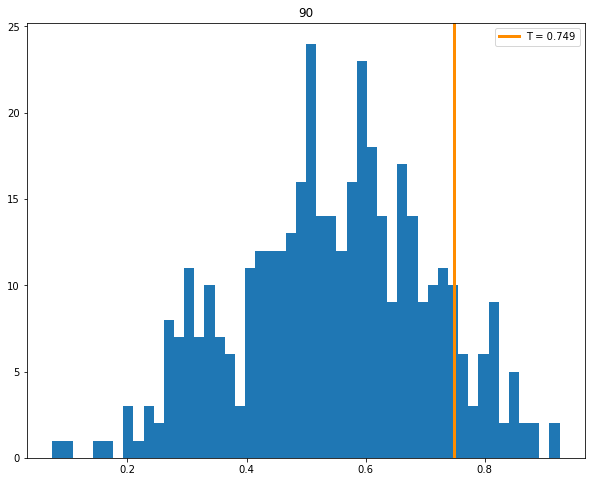

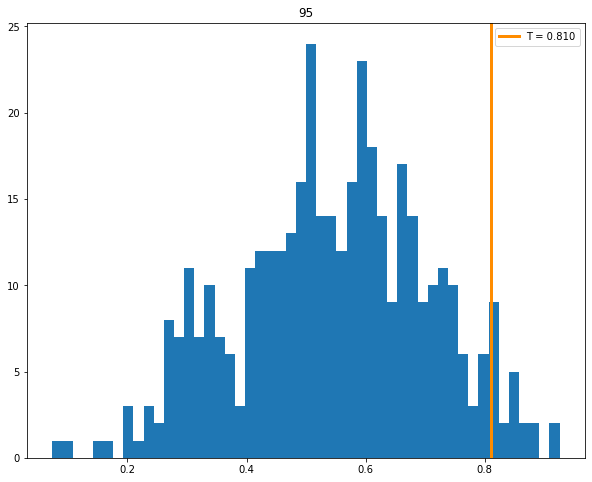

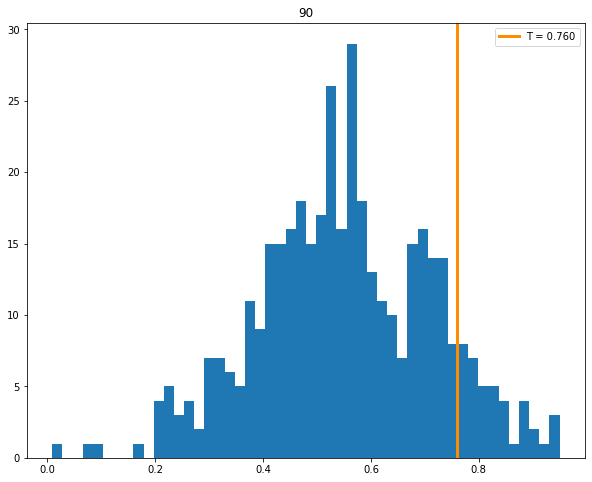

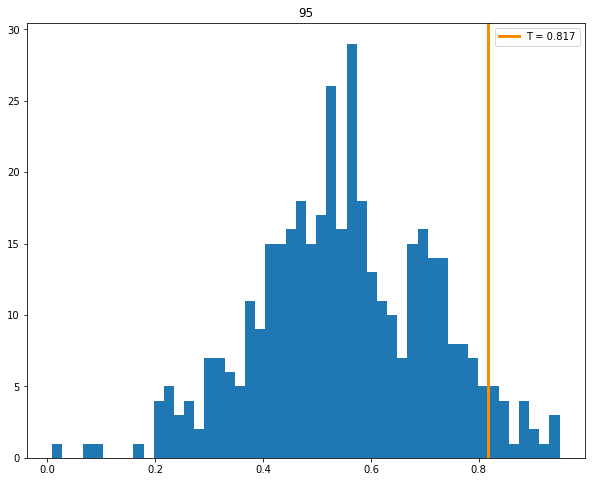

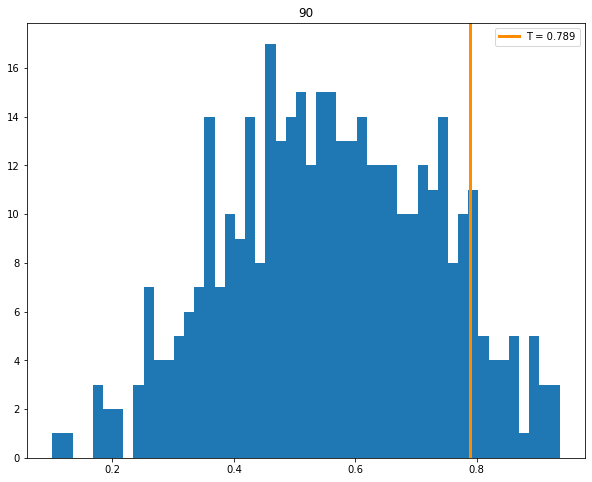

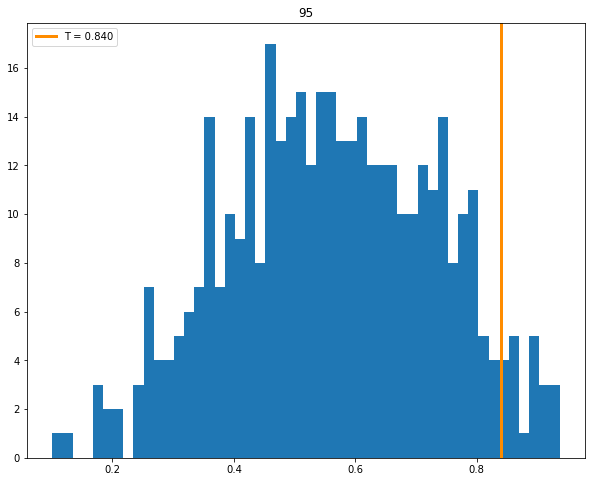

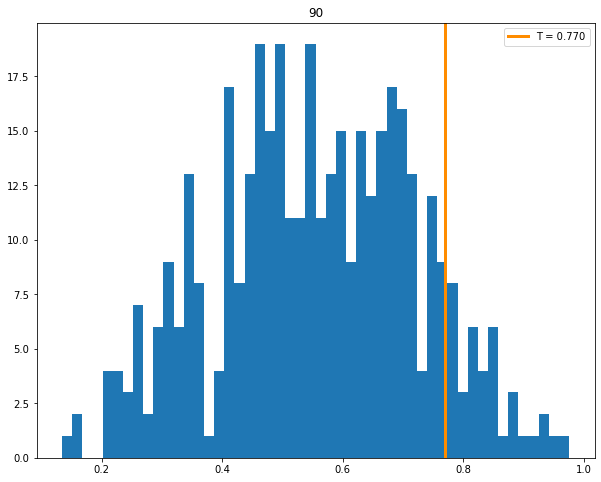

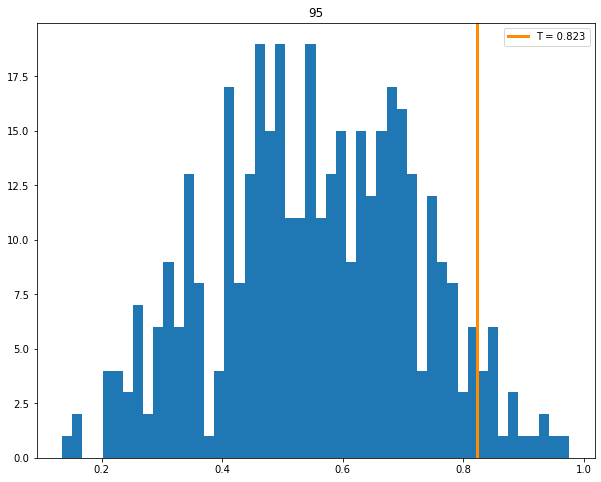

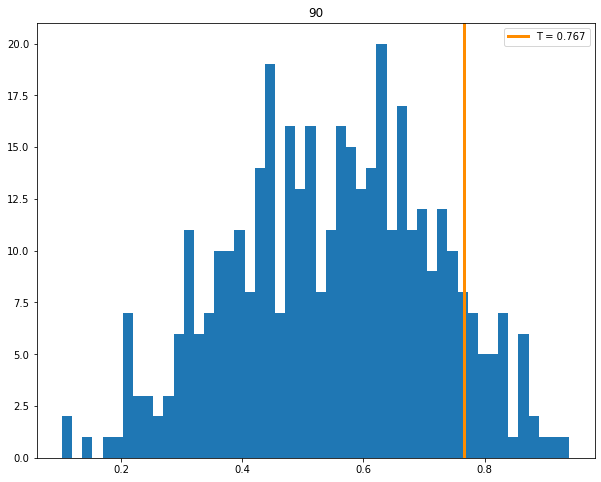

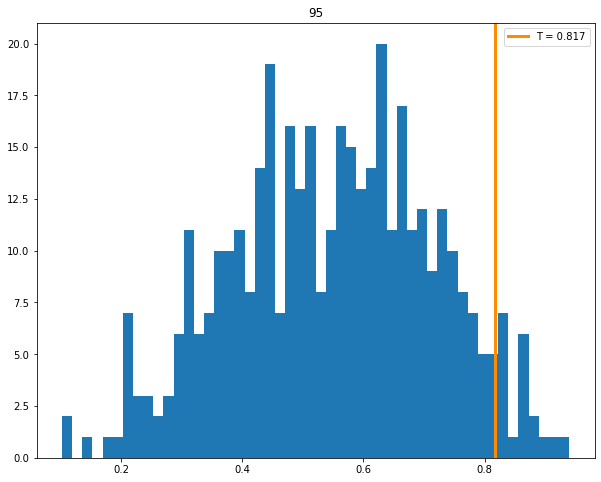

N =  450


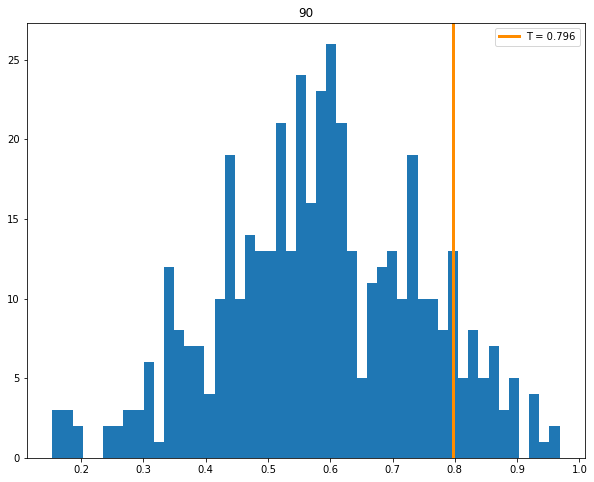

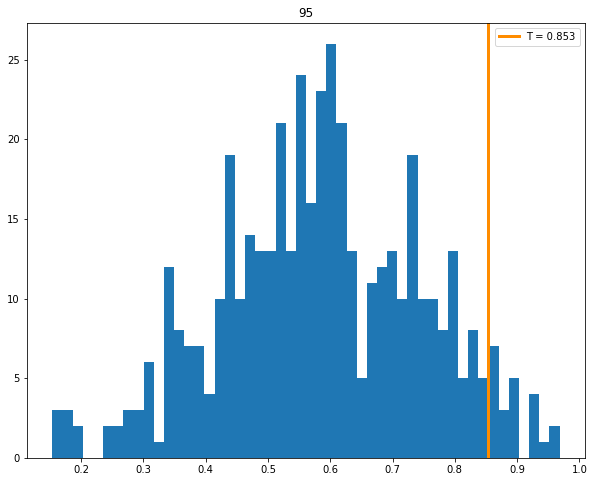

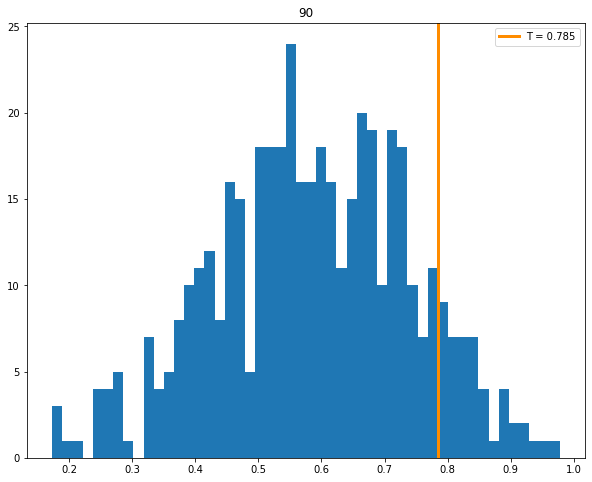

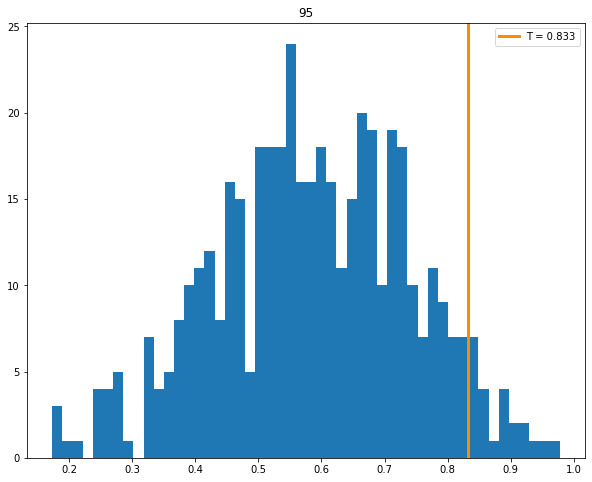

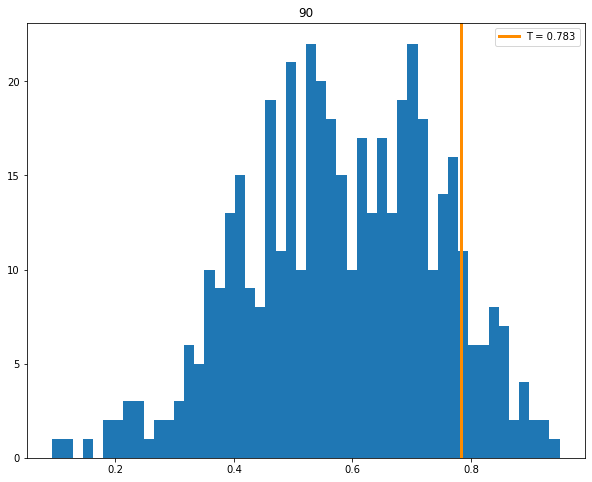

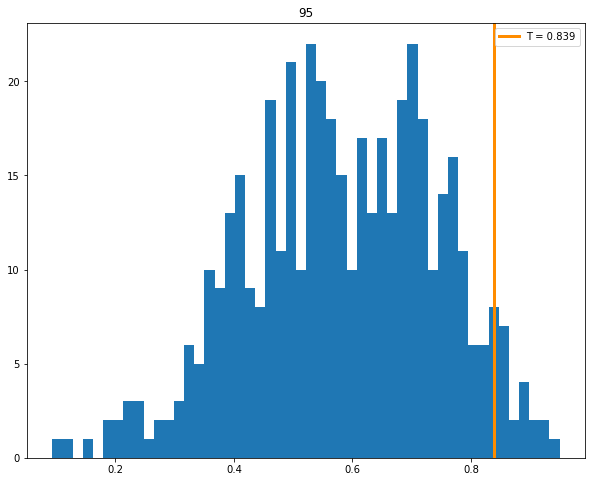

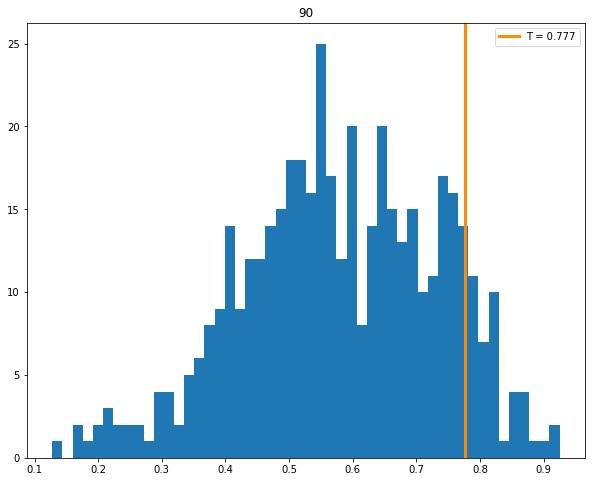

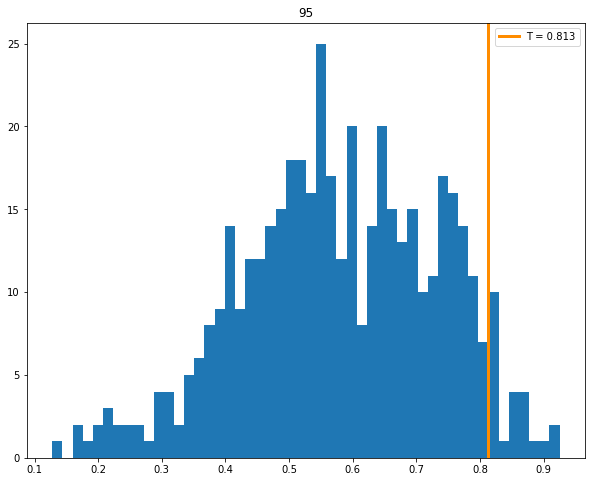

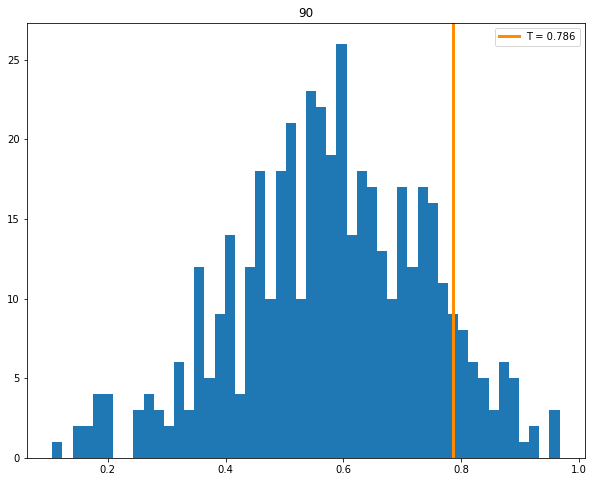

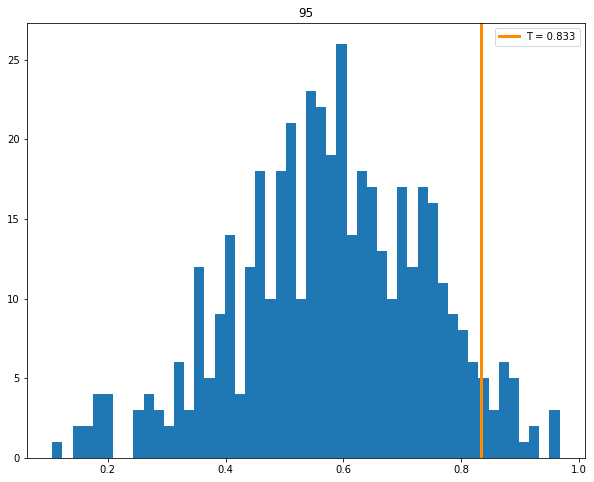

N =  500


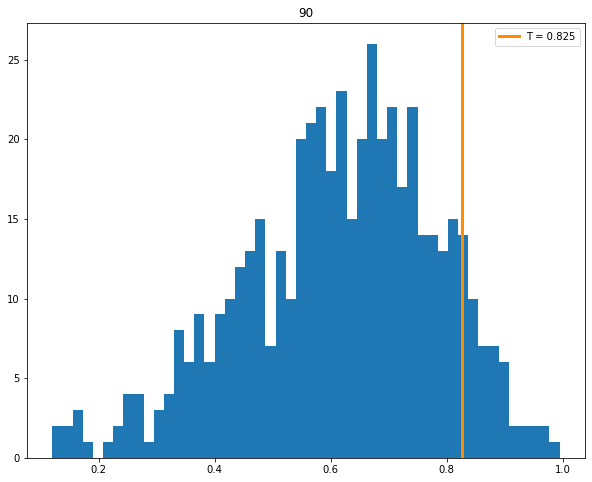

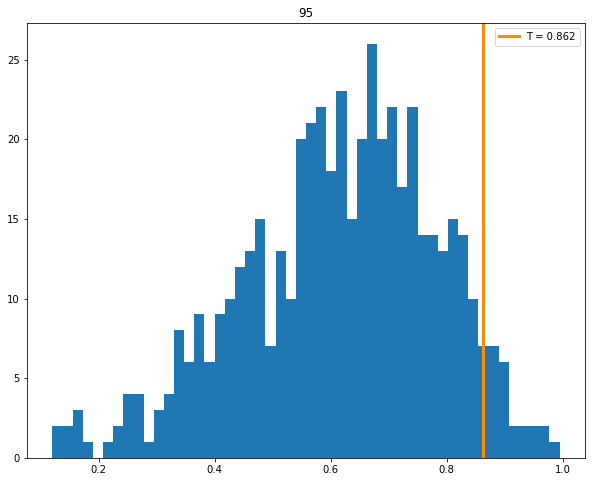

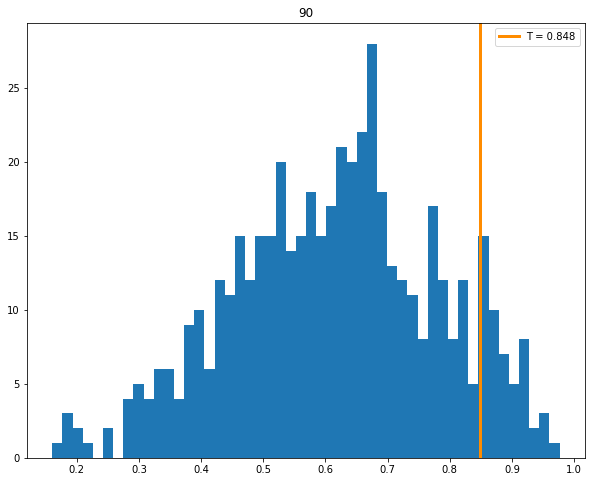

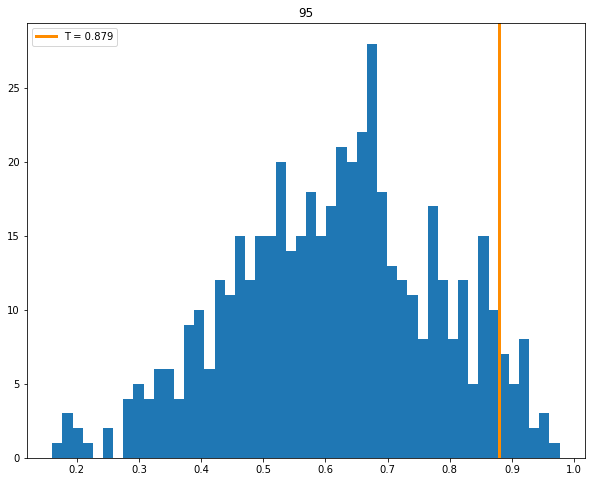

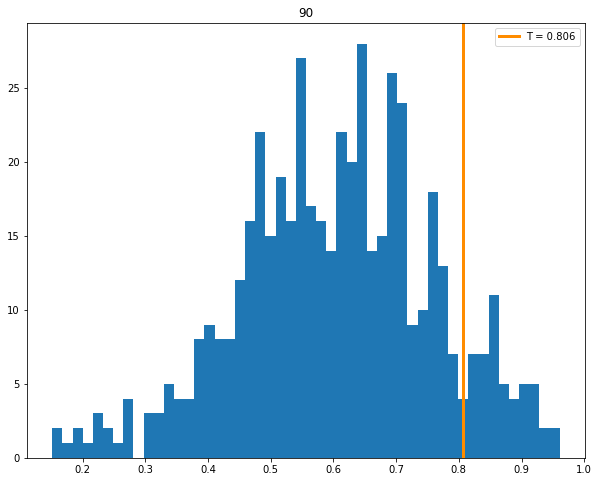

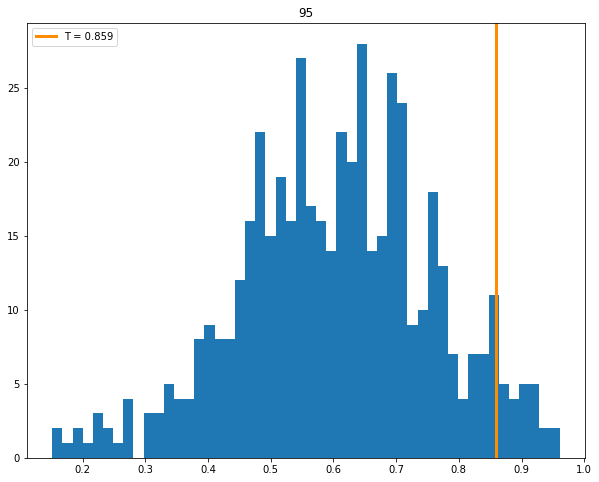

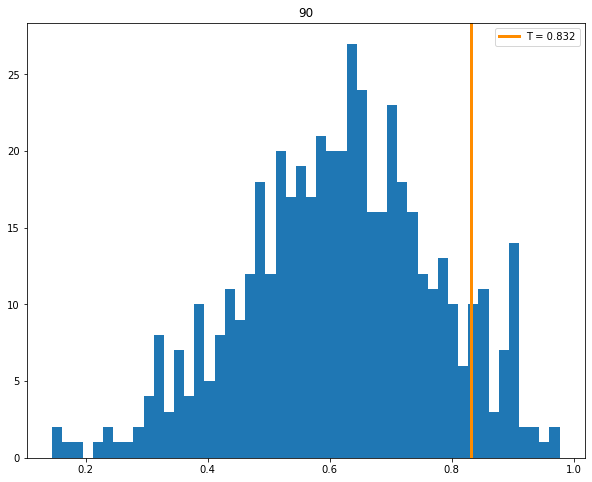

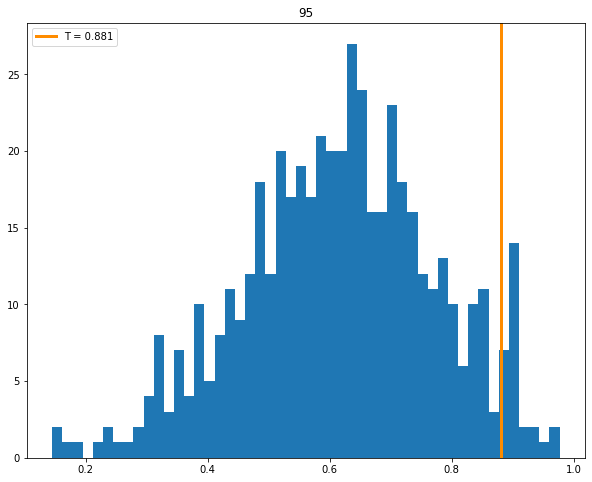

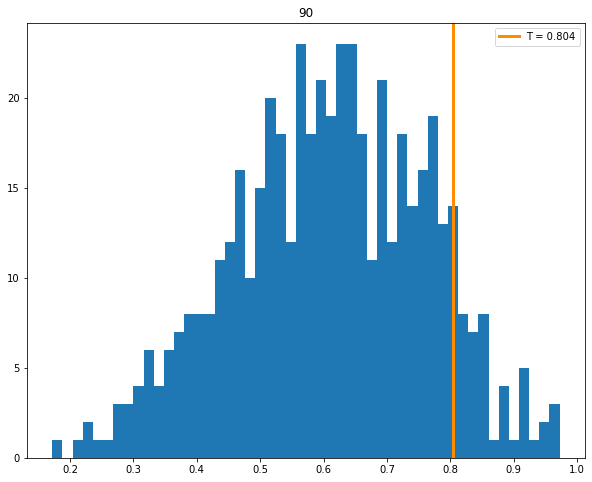

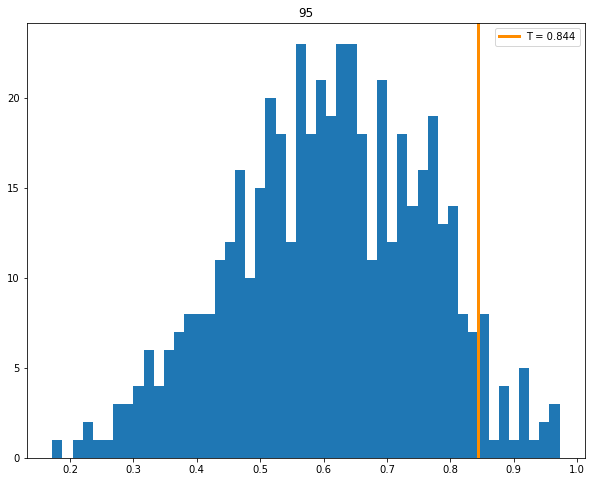

N =  550


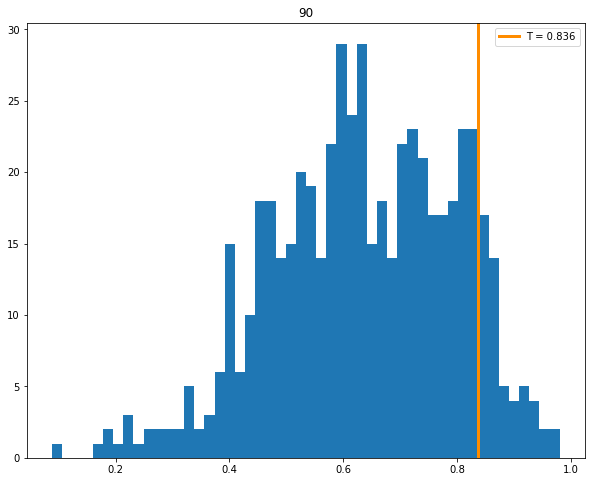

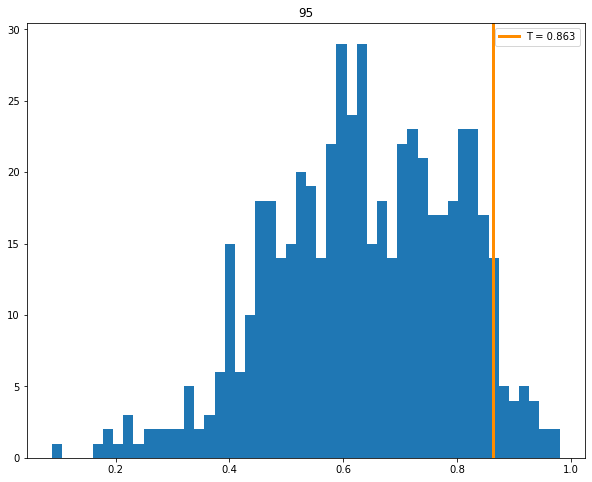

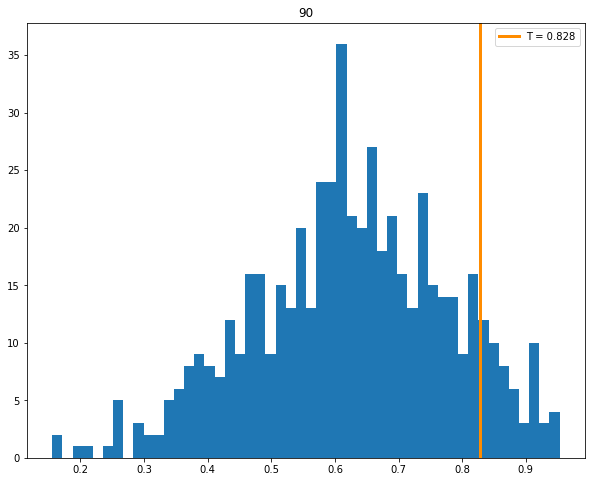

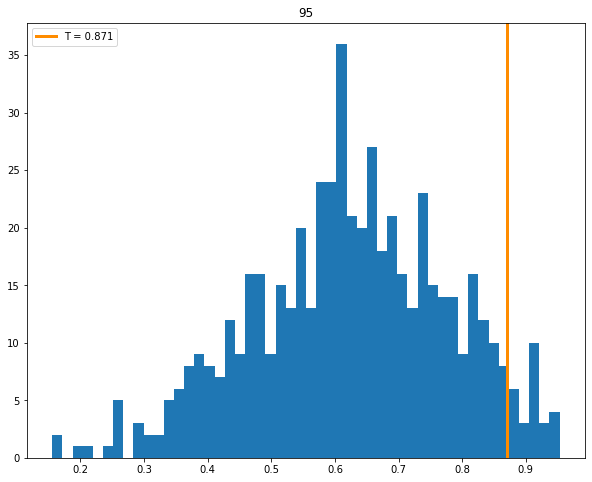

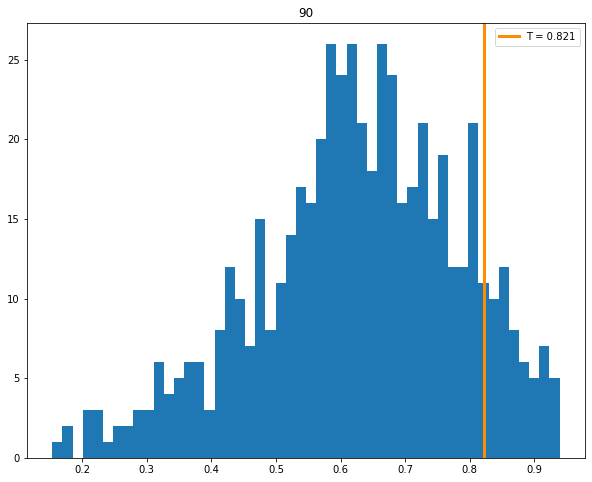

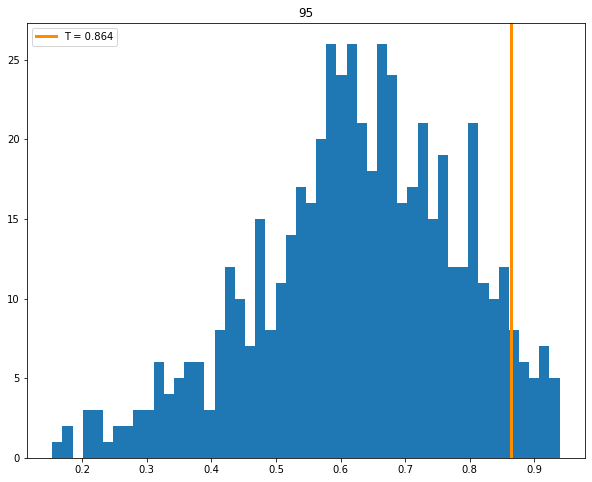

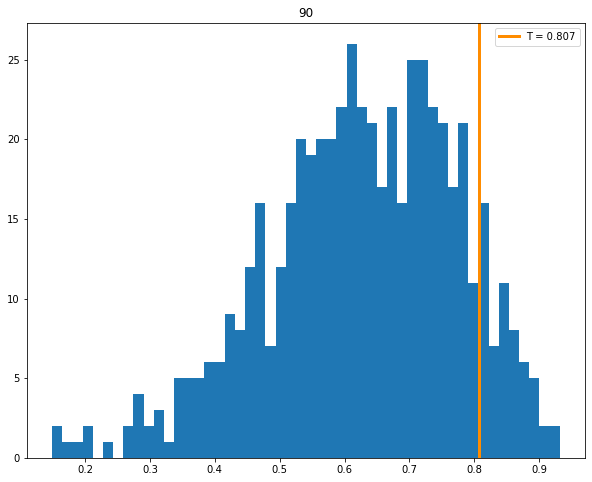

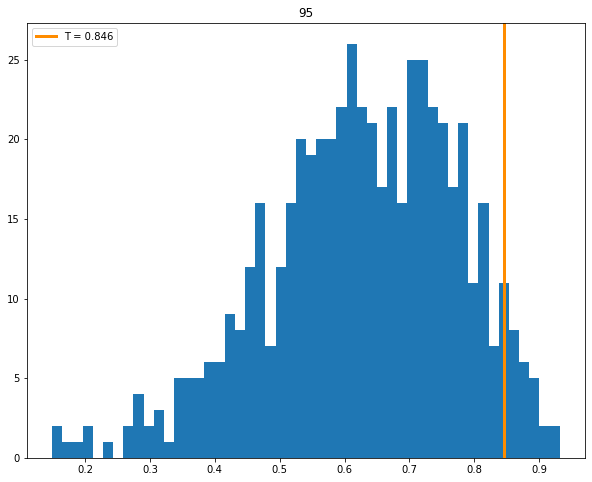

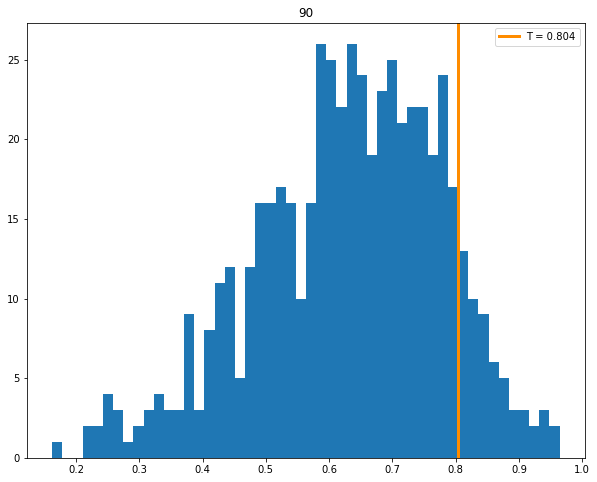

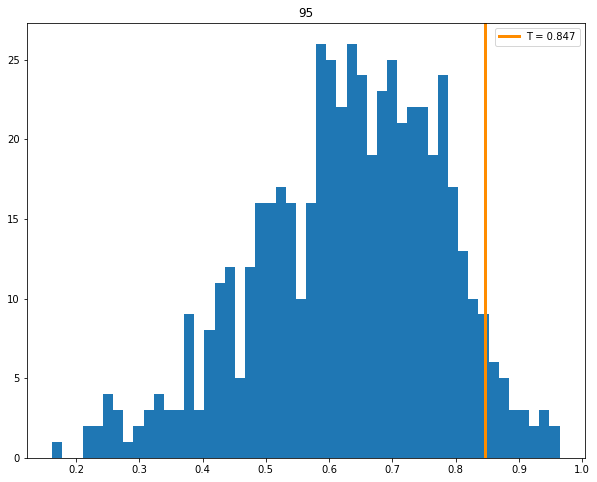

N =  600


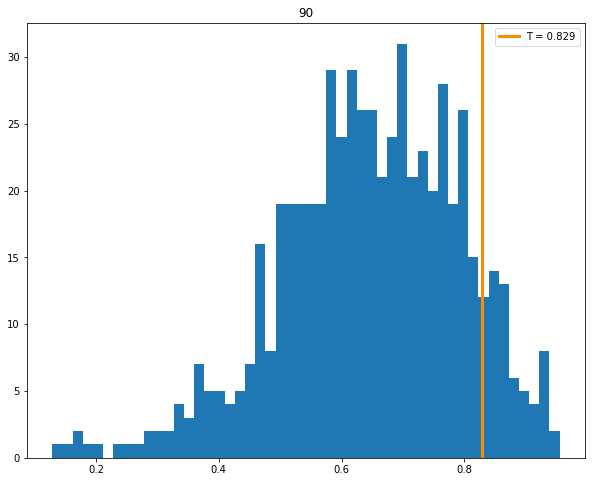

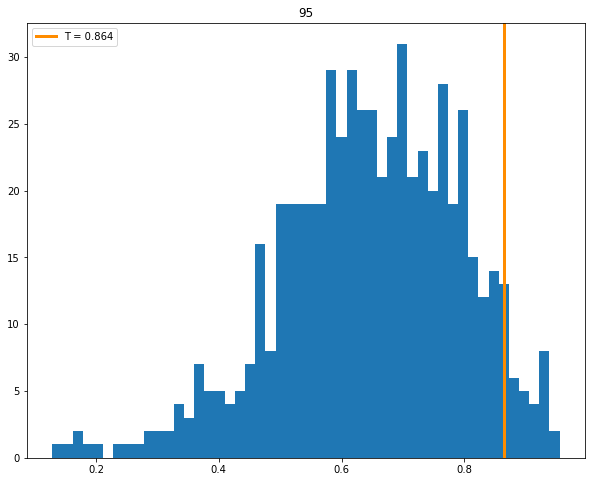

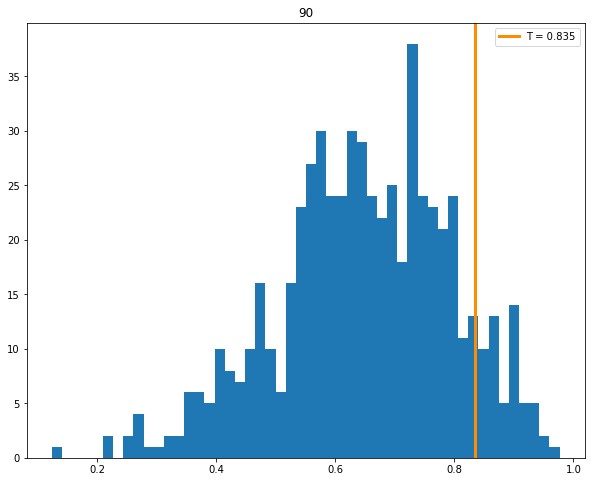

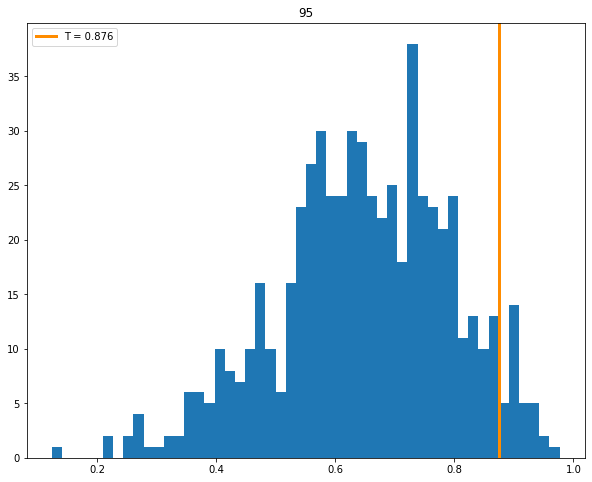

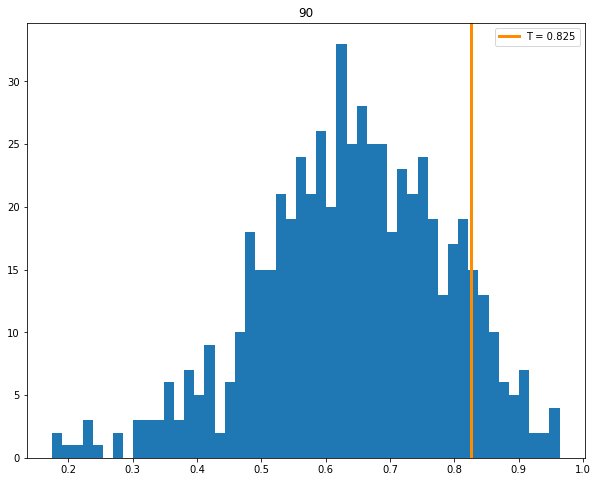

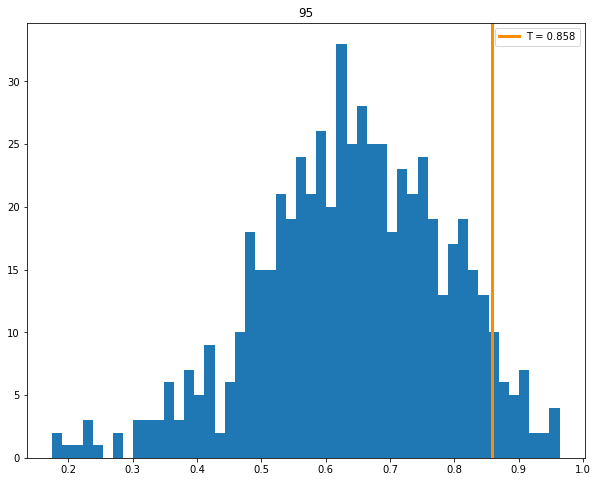

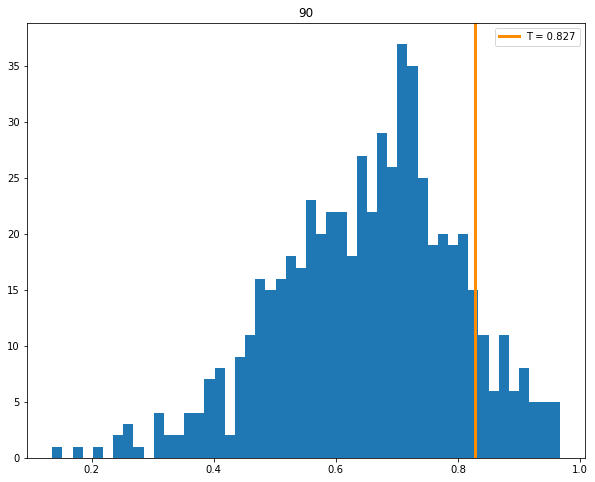

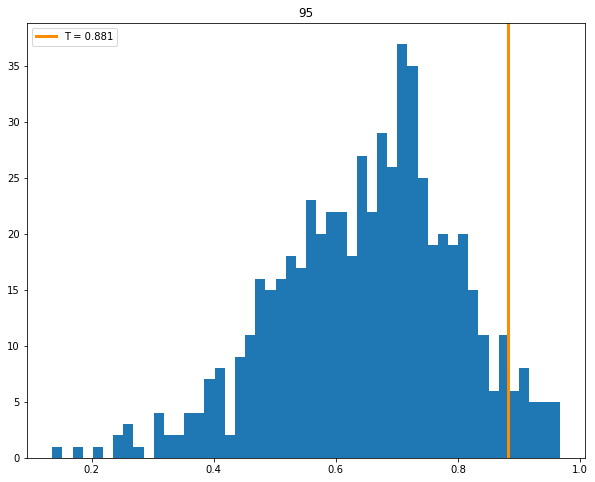

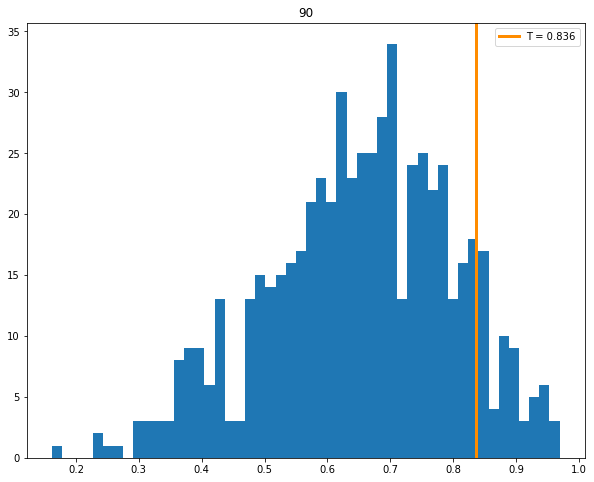

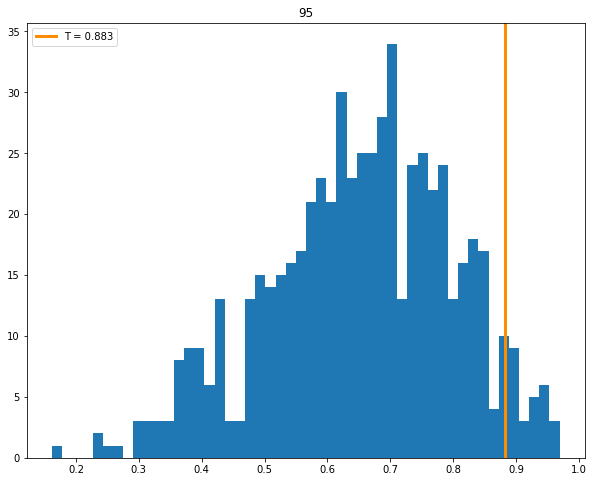

N =  650


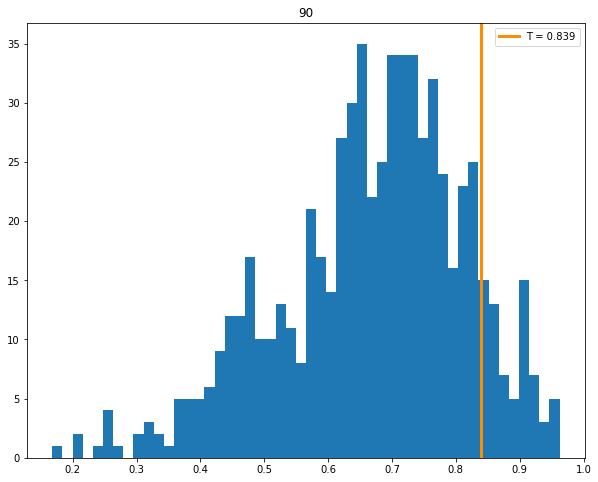

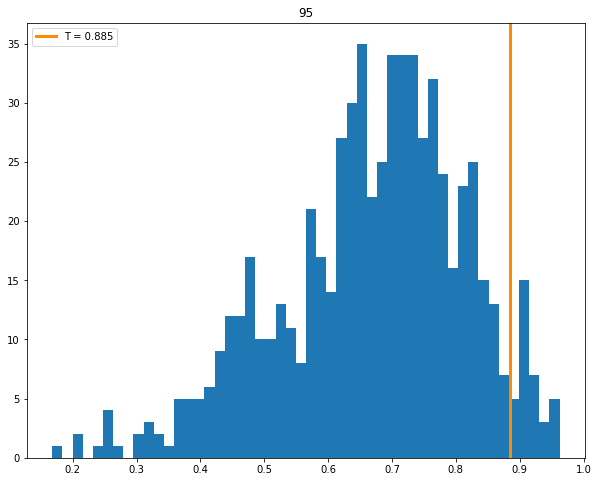

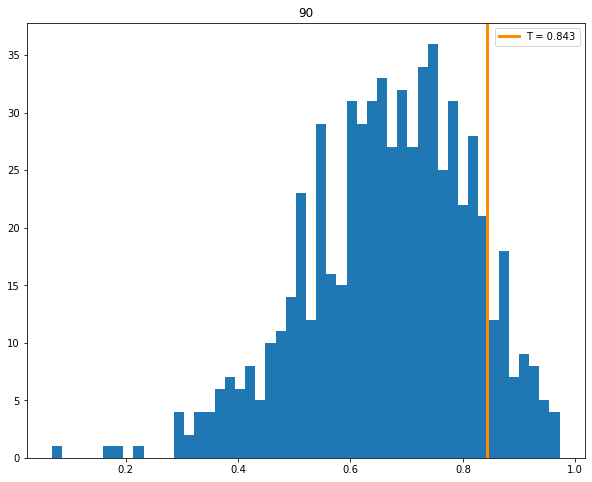

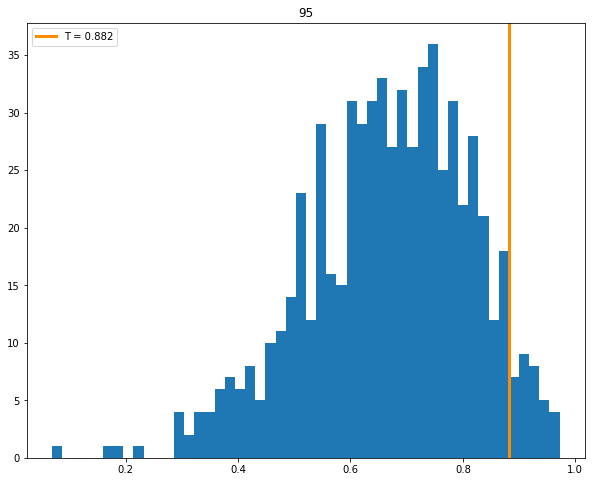

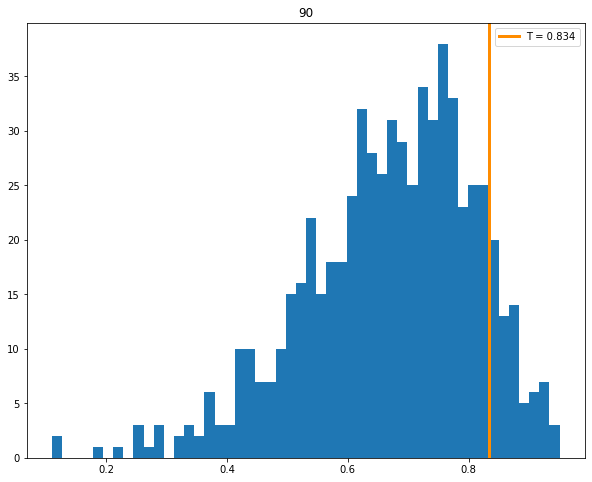

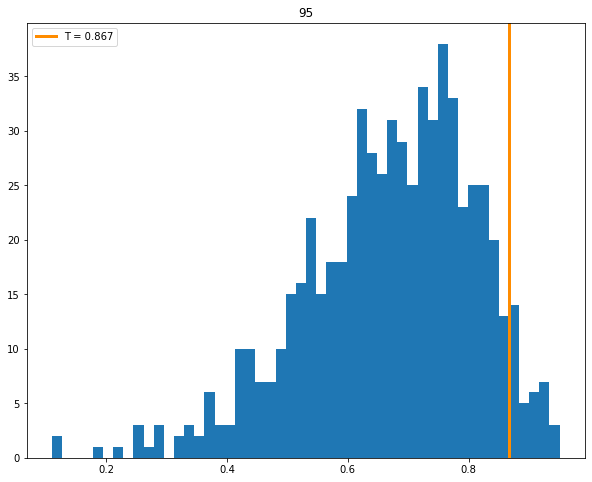

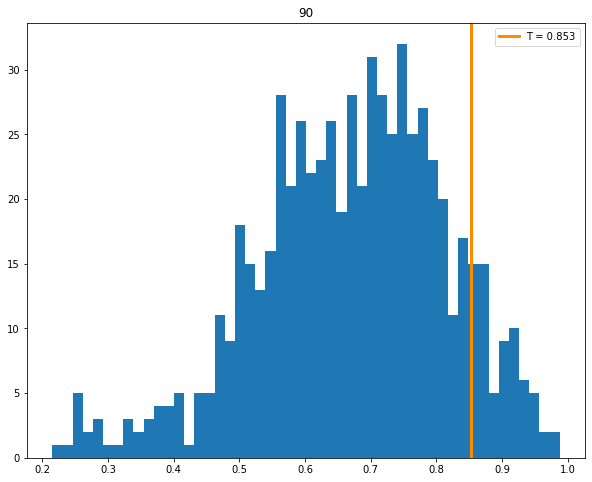

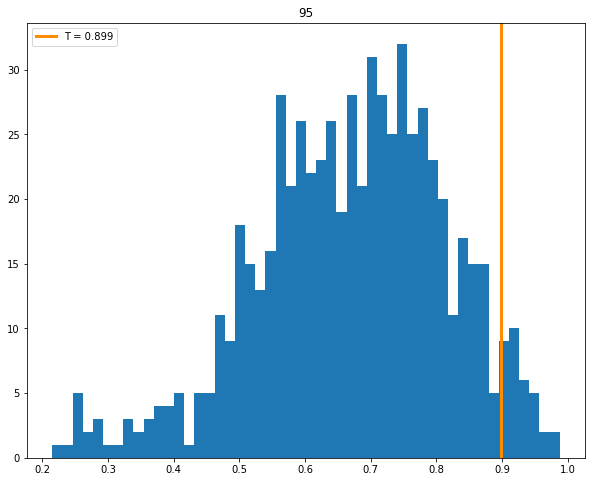

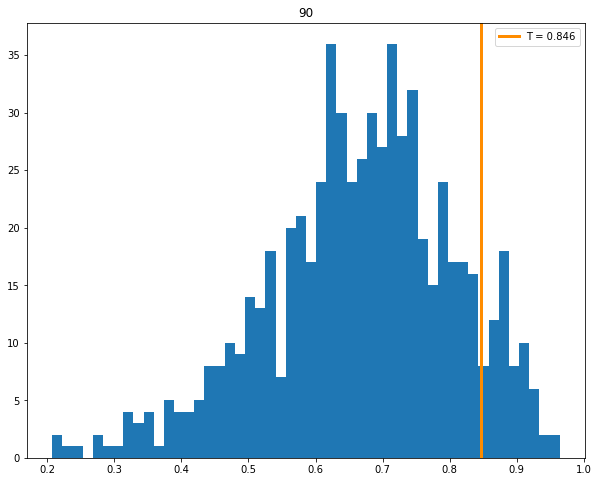

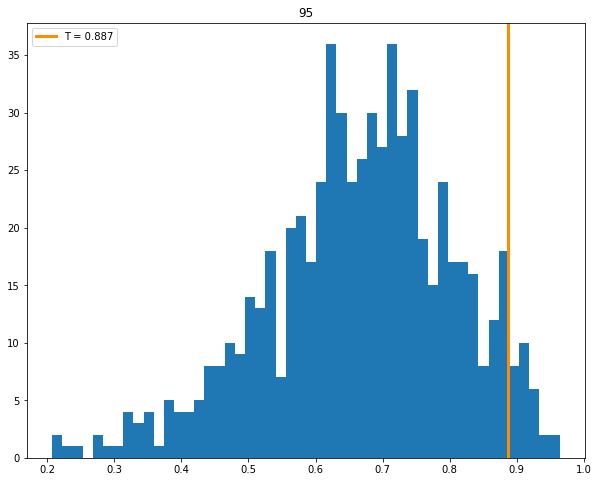

In [116]:
Sigma_s_s = [10, 55, 100]
Ns = np.arange(300, 651, 50).tolist()


all_T_av90 = []
all_T_av95 = []

for sigma_s in Sigma_s_s:
    print(sigma_s)
    T_N_av90 = []
    T_N_av95 = []
    for N in Ns:
        print('N = ', N)
        T90s = []
        T95s = []
        for i in range(5):
            T_90, T_95 = compute_T_90_95(N, sigma_s, x_lim = [0,2], y_lim = [0,2])
            T90s.append(T_90)
            T95s.append(T_95)
        T90s, T95s    = np.asarray(T90s), np.asarray(T95s)
        T_avg90 = np.mean(T90s)
        T_avg95 = np.mean(T95s)


        T_N_av90.append(T_avg90)
        T_N_av95.append(T_avg95)
        
    all_T_av90.append(T_N_av90)
    all_T_av95.append(T_N_av95)

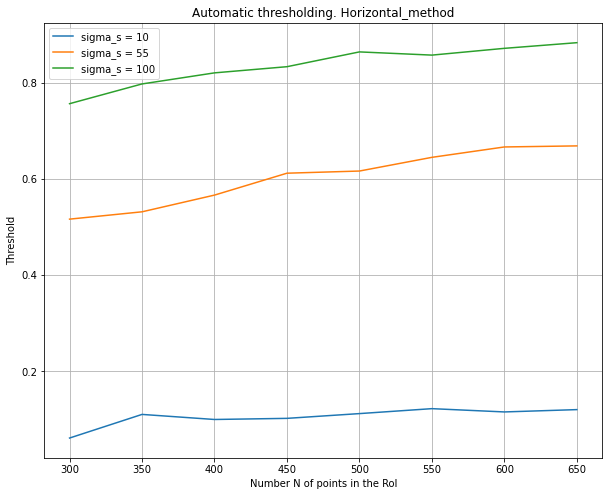

In [118]:
labels = ['sigma_s = ' + str(s) for s in Sigma_s_s]

x = Ns
plt.figure(figsize = (10,8))
for i, av in enumerate(all_T_av95):
    av = np.asarray(av)
    plt.plot(x,av, label = labels[i])

plt.title('Automatic thresholding. Horizontal_method')
plt.xlabel('Number N of points in the RoI')
plt.ylabel('Threshold')
plt.legend()
plt.grid()
plt.show()

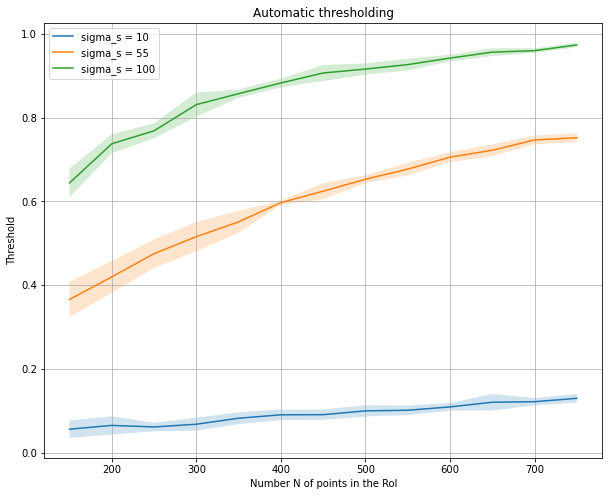

In [11]:

labels = ['sigma_s = ' + str(s) for s in Sigma_s_s]

x = Ns
plt.figure(figsize = (10,8))
for i, av in enumerate(all_T_av):
    av = np.asarray(av)
    sd = np.asarray(all_T_sd[i])
    plt.plot(x,av, label = labels[i])
    plt.fill_between(x, (av - sd), (av + sd), alpha=.2)

plt.title('Automatic thresholding')
plt.xlabel('Number N of points in the RoI')
plt.ylabel('Threshold')
plt.legend()
plt.grid()
plt.show()

## Voir la limitation que Manley redoute: 

In [66]:
param = Standard_Param()

param_NoNoise = Standard_Param()
param_NoNoise.NoisePercentage = 0

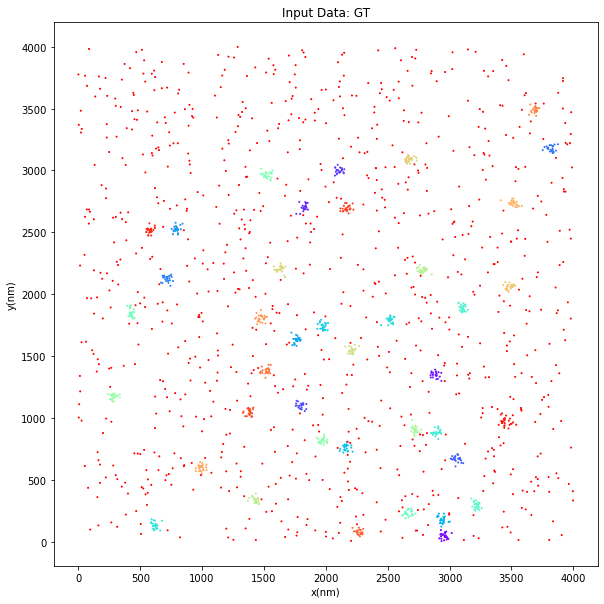

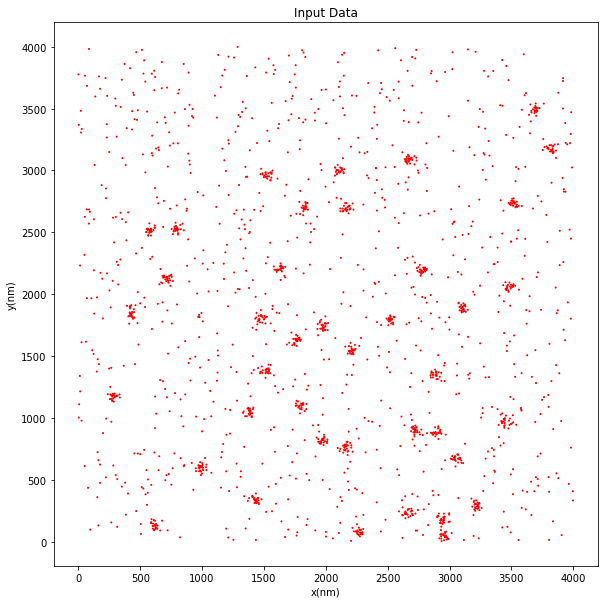

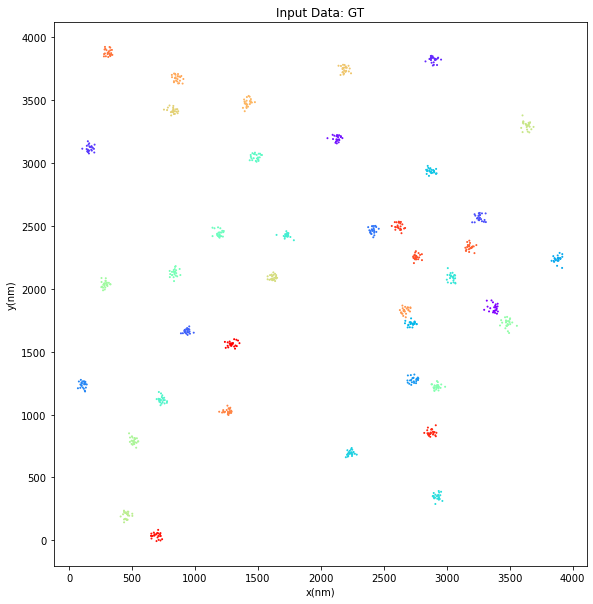

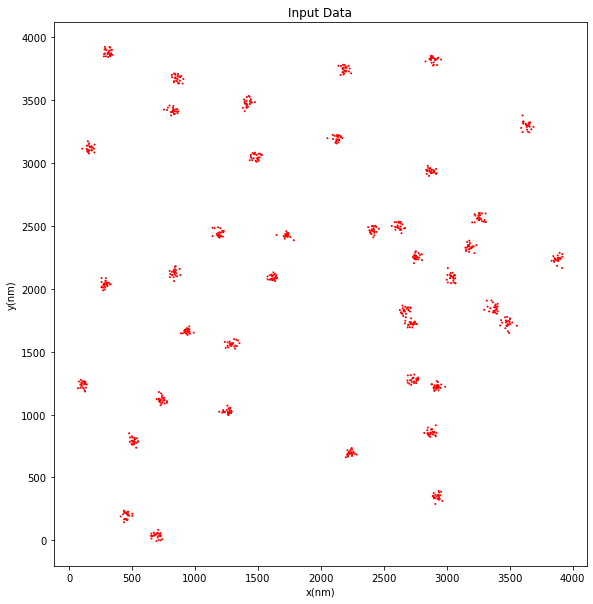

In [67]:
DataNoise = Call_DataGenerator(param)
DataNoise.plot_points()
DataNoNoise = Call_DataGenerator(param_NoNoise)
DataNoNoise.plot_points()

In [68]:
Noise_df = DataNoise.GetAllData()
N_Noise = len(DataNoise.GetPoints())
NoNoise_df = DataNoNoise.GetAllData()
N_NoNoise = len(DataNoNoise.GetPoints())
sigma_s = 35.0

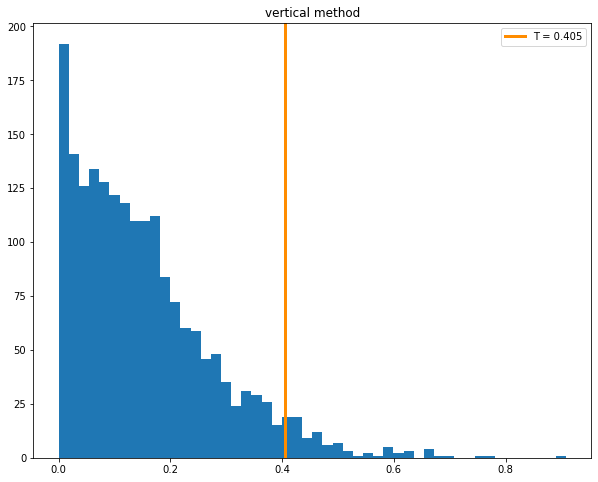

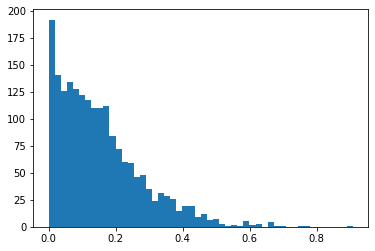

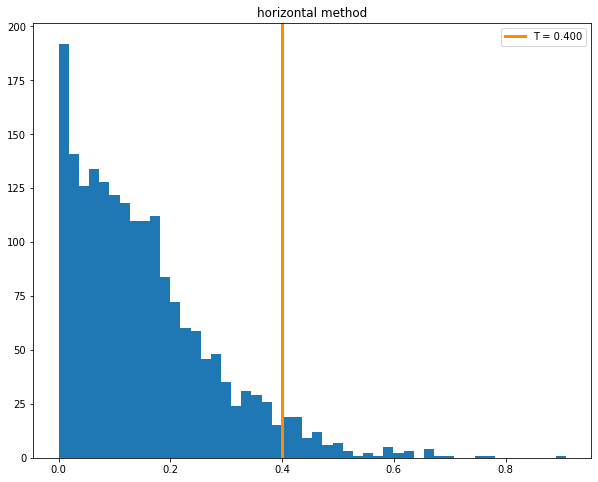

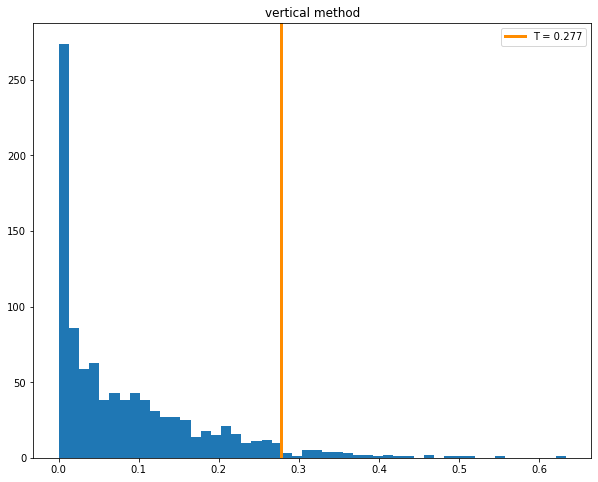

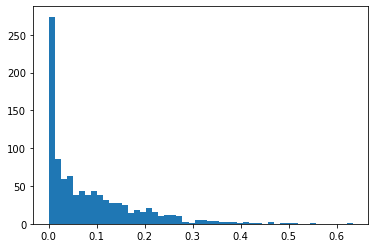

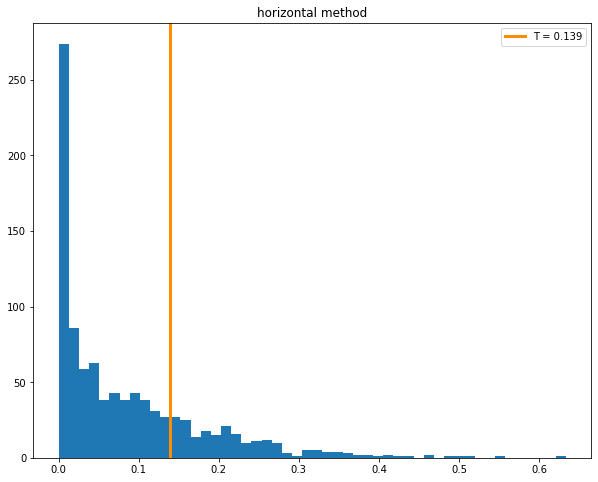

In [72]:
T_Noise, poubelle = compute_T(N_Noise, sigma_s)
T_NoNoise, poubelle = compute_T(N_NoNoise, sigma_s)

In [56]:
print('T_noise = ', T_Noise)
print('T_NoNoise = ', T_NoNoise)

T_noise =  0.40848280982367563
T_NoNoise =  0.2758114551728531


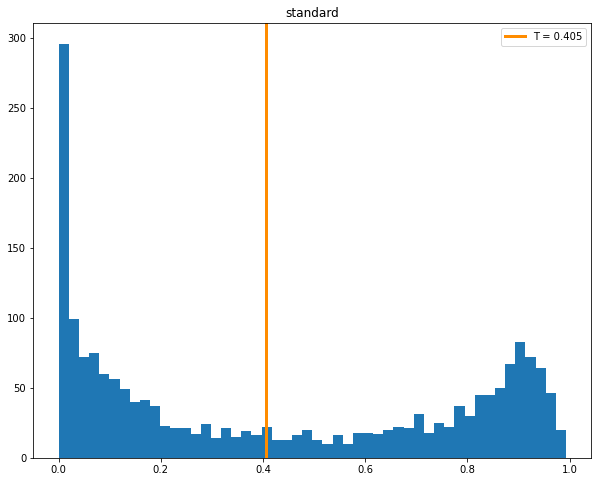

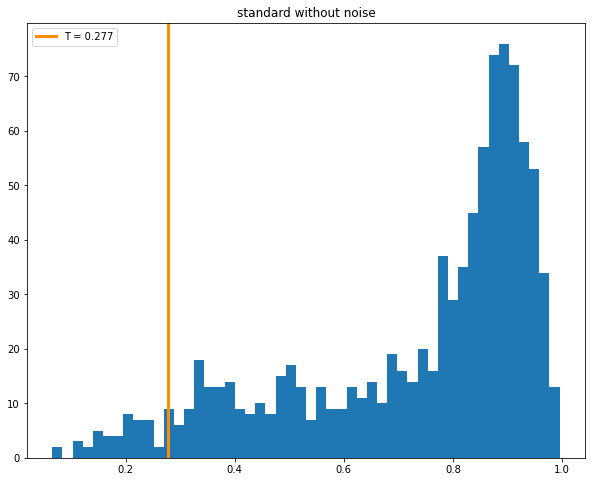

In [74]:
P_Noise = Noise_df[['x', 'y']].to_numpy()
P_NoNoise = NoNoise_df[['x', 'y']].to_numpy()

Sigma1          = np.ones((P_Noise.shape[0], 2, 2)) * 0
Sigma1[:, 0, 1] = 0
Sigma1[:, 1, 0] = 0
n1              = np.ones((P_Noise.shape[0], 1)).ravel()

density_Noise, G = compute_density(P_Noise, Sigma1, sigma_s)
see_histogram(density_Noise, T_Noise, 'standard')

Sigma1          = np.ones((P_NoNoise.shape[0], 2, 2)) * 0
Sigma1[:, 0, 1] = 0
Sigma1[:, 1, 0] = 0
n1              = np.ones((P_NoNoise.shape[0], 1)).ravel()

density_noNoise, G = compute_density(P_NoNoise, Sigma1, sigma_s)
see_histogram(density_noNoise, T_NoNoise, 'standard without noise')



T_Noise =  0.48199720541797286
T_NoNoise =  0.31839390778532173


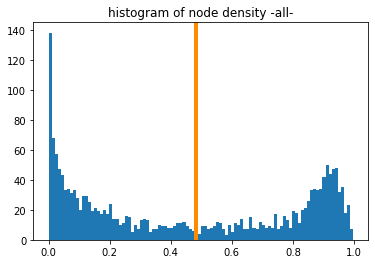

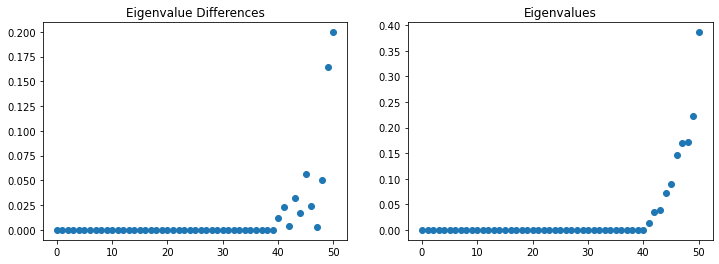

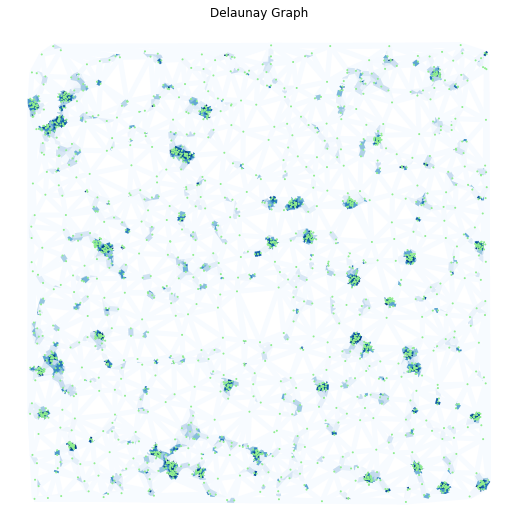

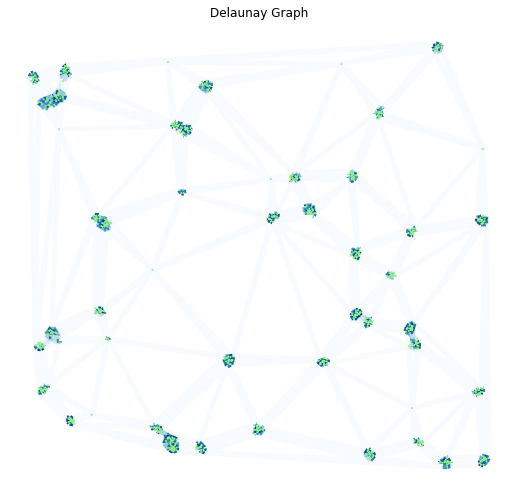

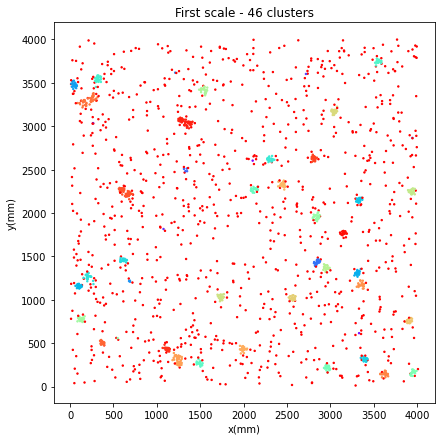

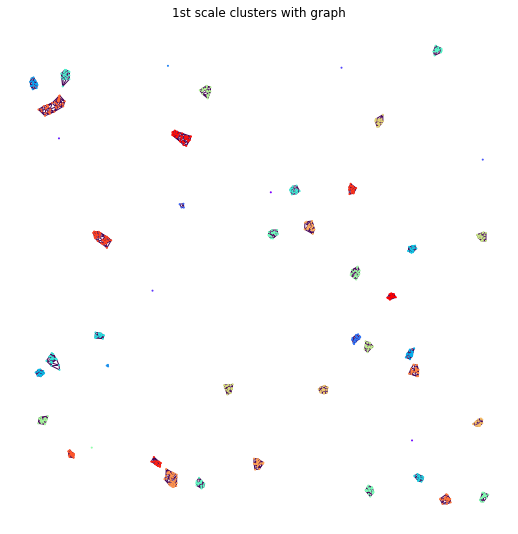

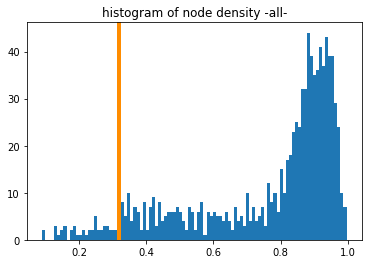

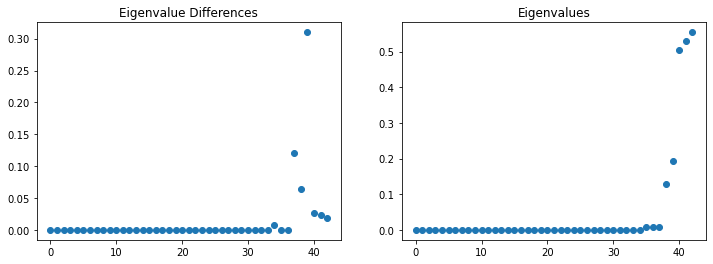

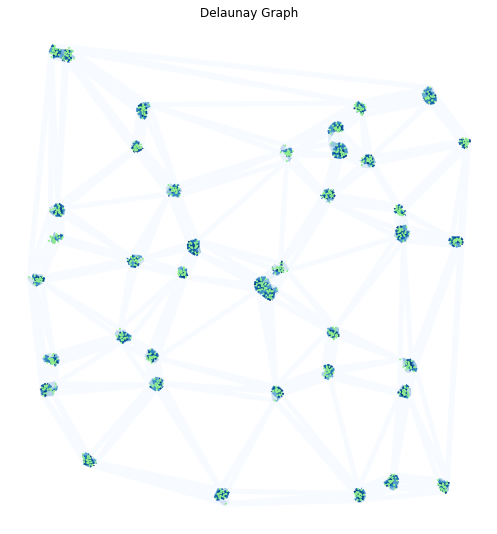

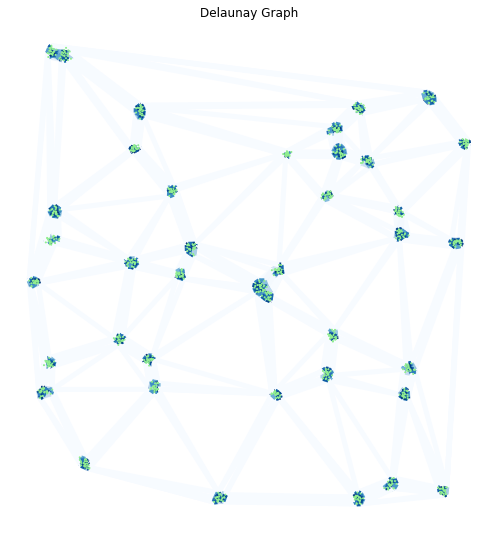

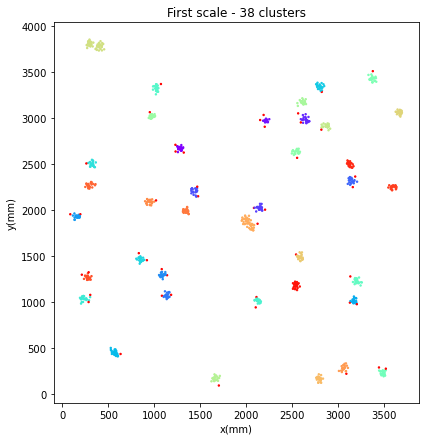

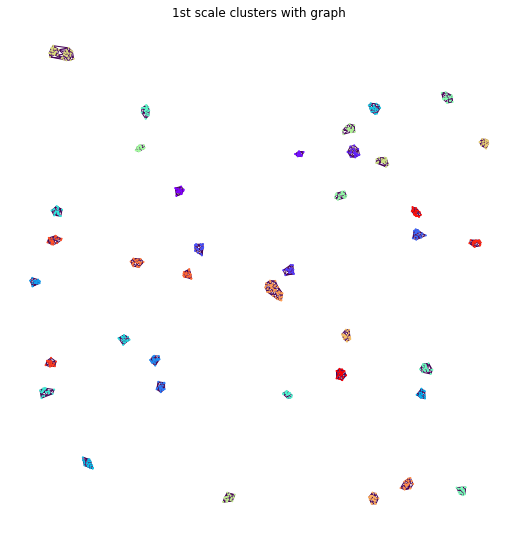

In [49]:
# CA CA A éTé OBTENU AVEC SIGMA_S = 40.0

# - T_noise =  0.48199720541797286
# - T_NoNoise =  0.31839390778532173

T_Noise =  0.4048880293696683
T_NoNoise =  0.2773844982933877


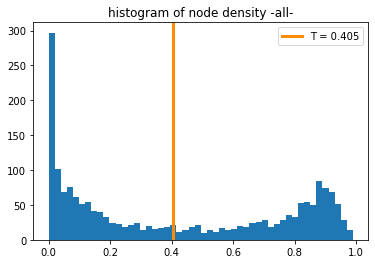

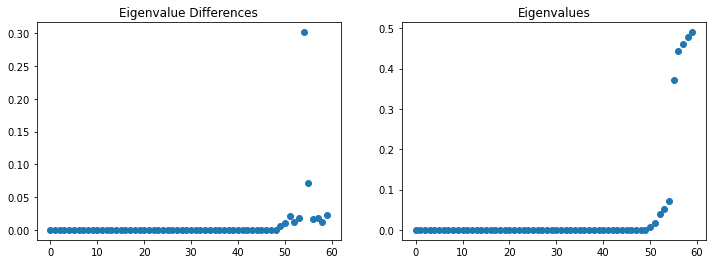

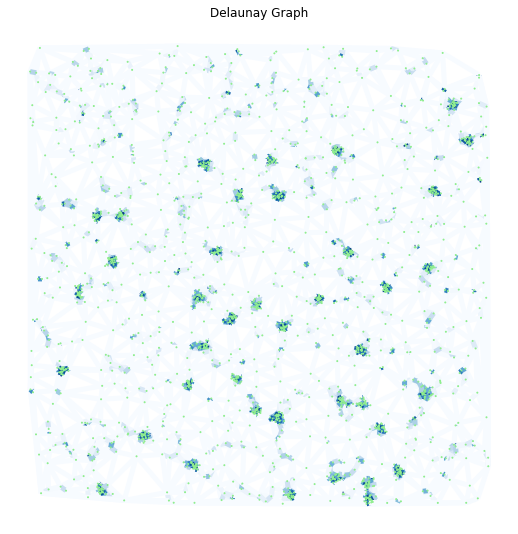

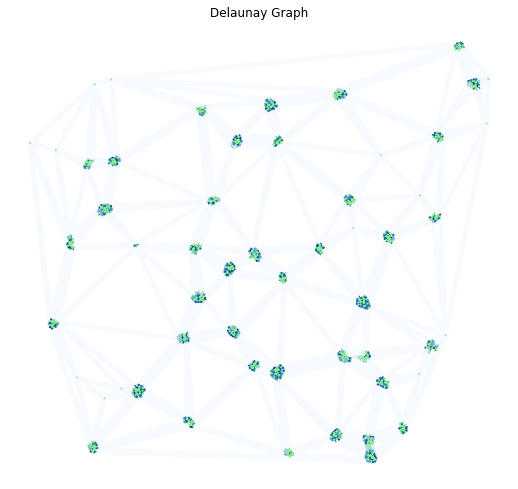

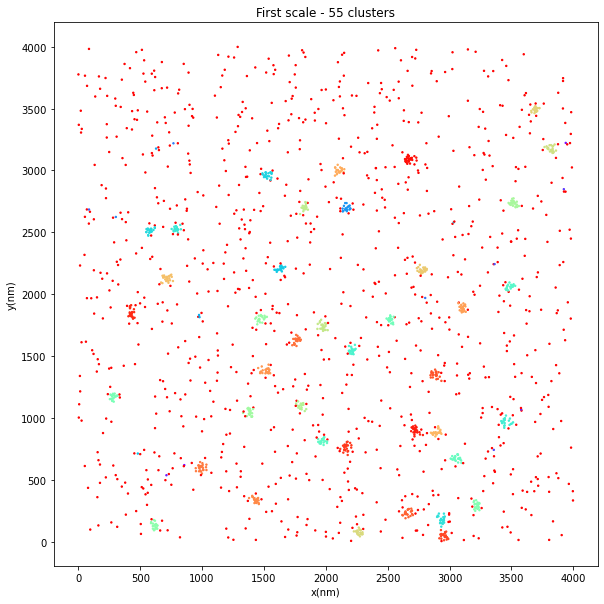

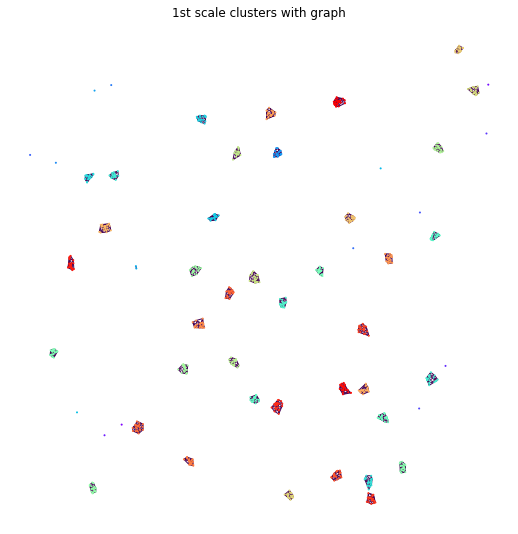

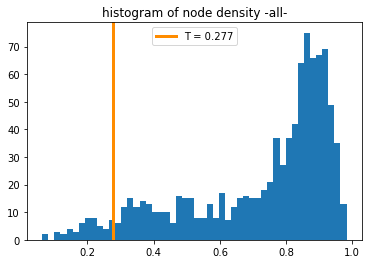

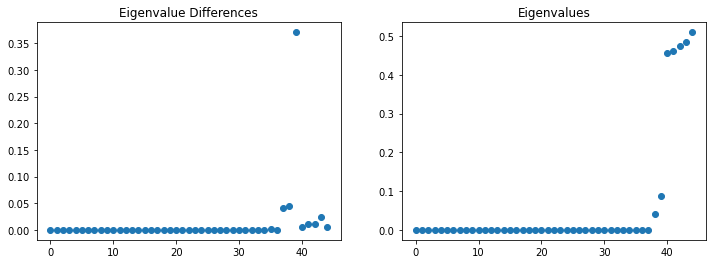

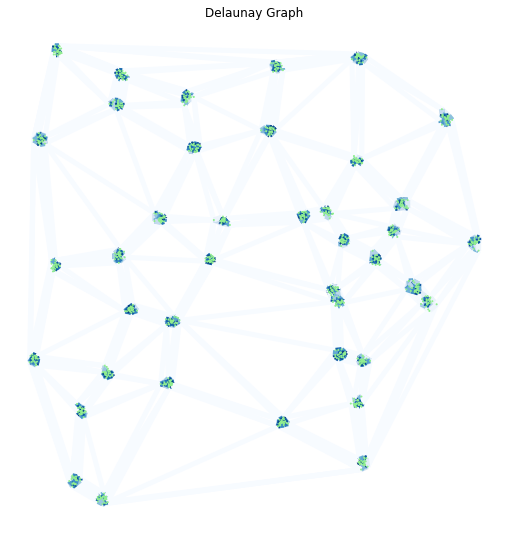

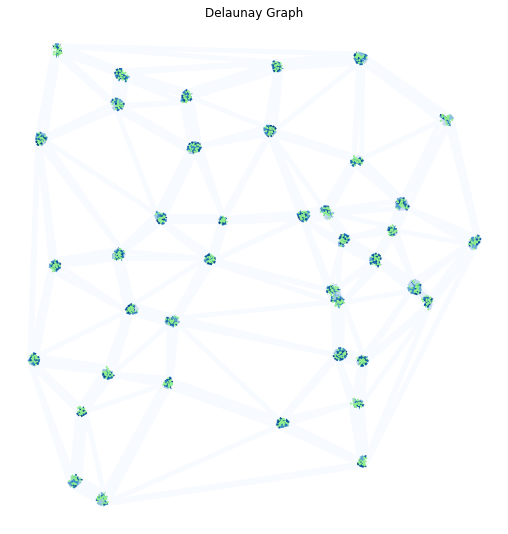

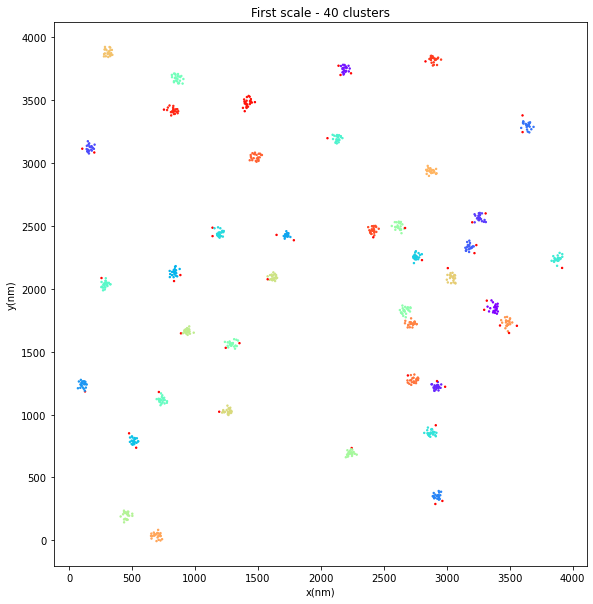

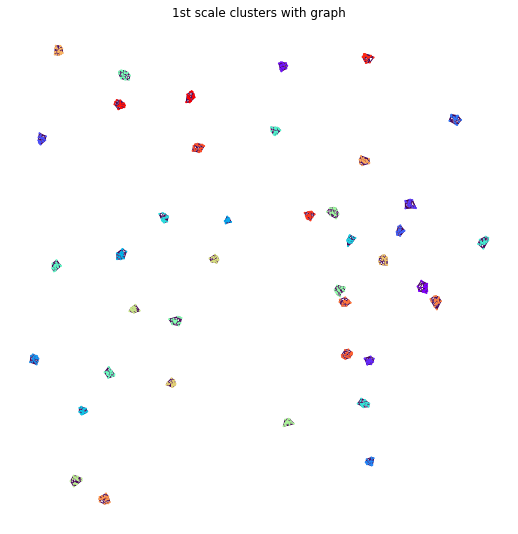

In [75]:
# Avec sigma = 35
print('T_Noise = ', T_Noise)
print('T_NoNoise = ', T_NoNoise)
labels_Noise = calling_graphic(Noise_df, sigma_s, T_Noise)
labels_Noise = calling_graphic(NoNoise_df, sigma_s, T_NoNoise)

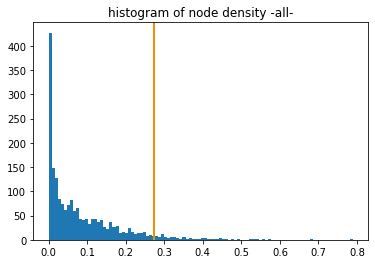

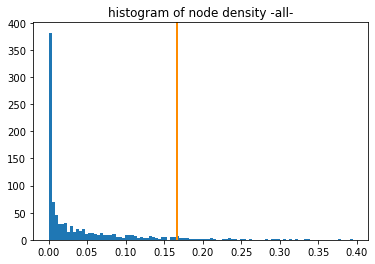

In [60]:
# EXACTEMENT LES MEMES DONNéES MAIS AVEC UN SIGMA PLUS PETIT. 
sigma_s = 25.0
T_Noise = compute_T(N_Noise, sigma_s)
T_NoNoise = compute_T(N_NoNoise, sigma_s)

T_Noise =  0.27420449667372176
T_NoNoise =  0.1666346050355632


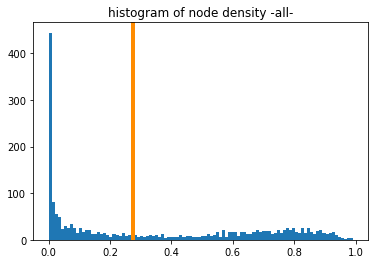

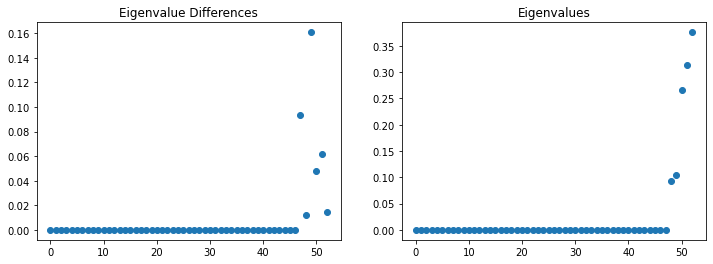

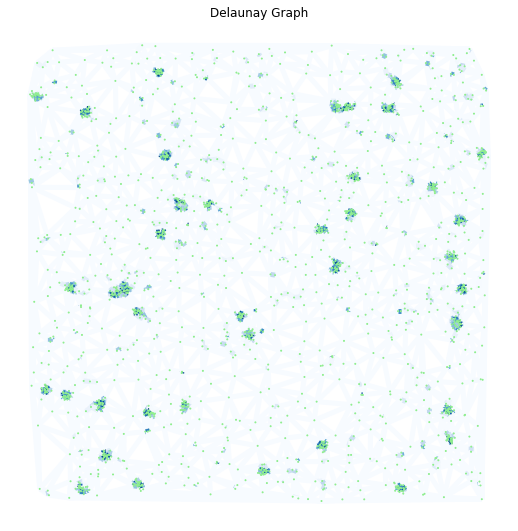

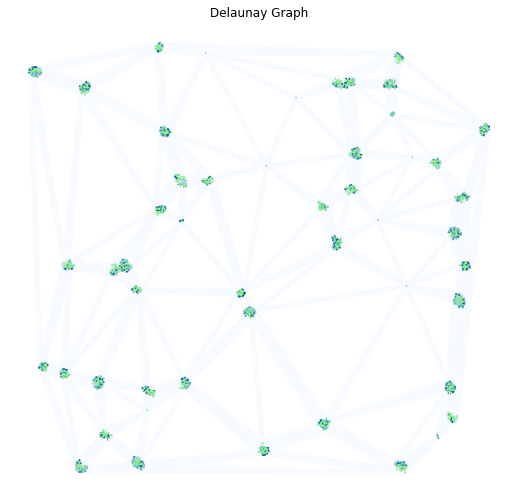

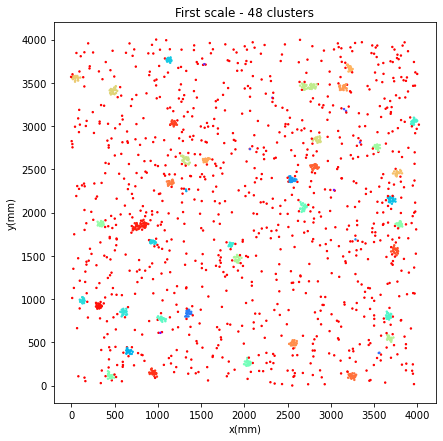

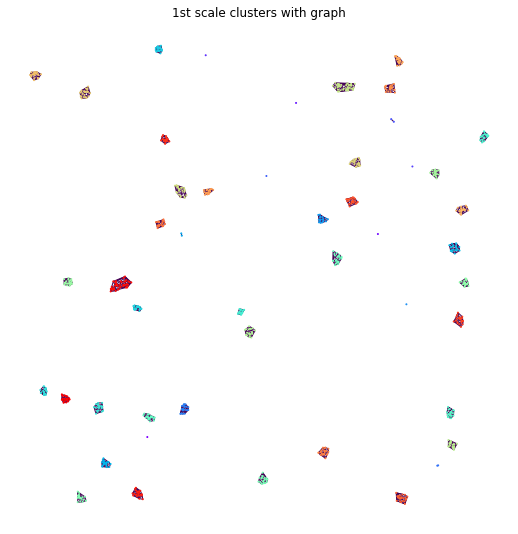

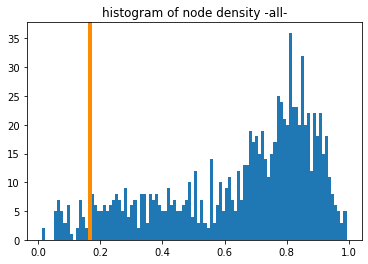

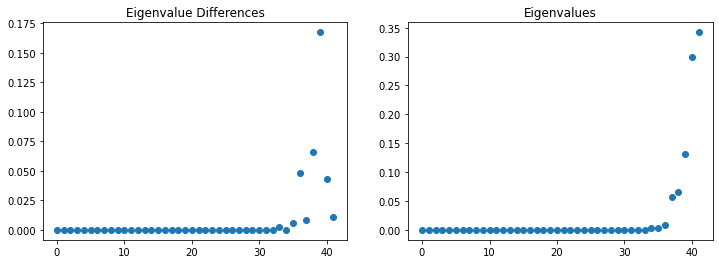

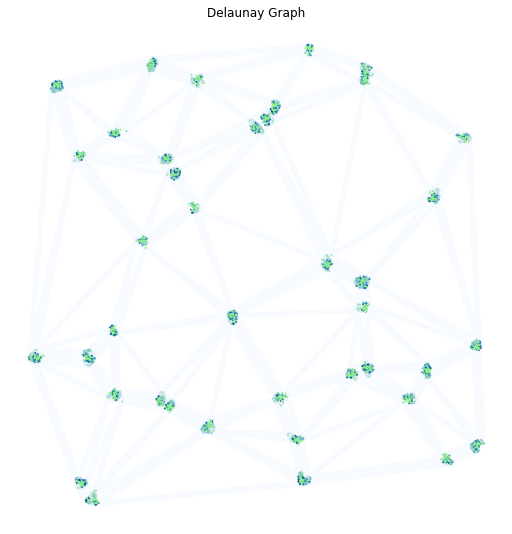

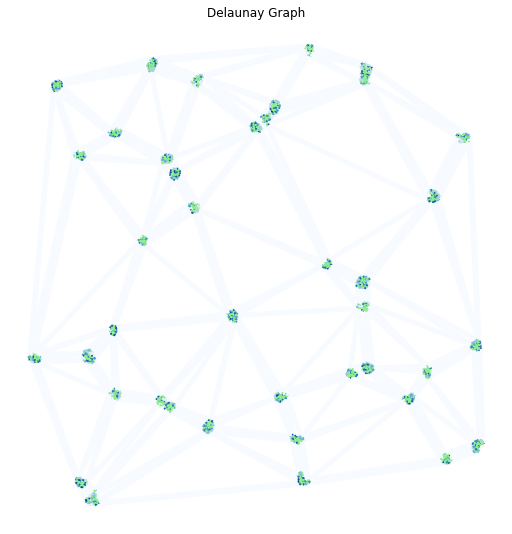

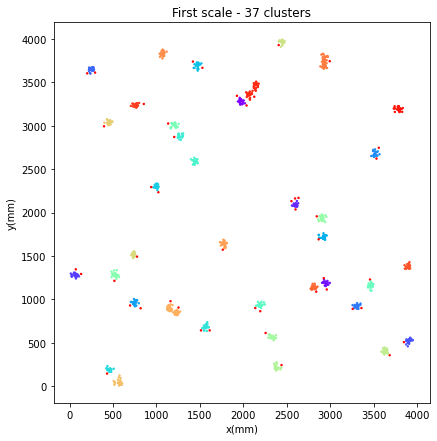

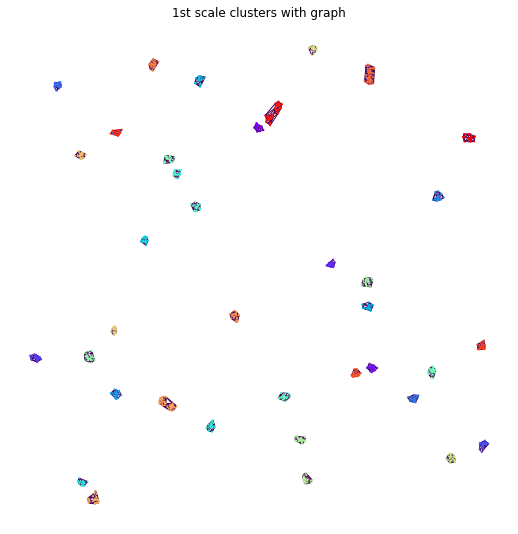

In [61]:
# Avec sigma = 25
print('T_Noise = ', T_Noise)
print('T_NoNoise = ', T_NoNoise)
labels_Noise = calling_graphic(Noise_df, sigma_s, T_Noise)
labels_Noise = calling_graphic(NoNoise_df, sigma_s, T_NoNoise)

In [76]:
# Another extreme situation that does not really make any sense

In [7]:
T_crowded

0.7700123943656837

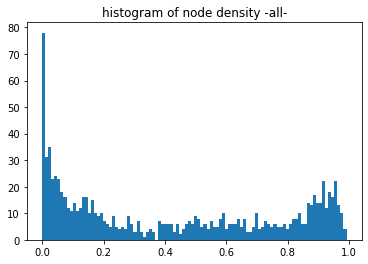

In [86]:
data_cluster = datagen.GetAllData()
P = data_cluster[['x', 'y']].to_numpy() # select the coordinates columns, and transform into a numpy object
truelabels = data_cluster['labels_1'].to_numpy()

Sigma1          = np.ones((P.shape[0], 2, 2)) * 0.5
Sigma1[:, 0, 1] = 0
Sigma1[:, 1, 0] = 0
n1              = np.ones((P.shape[0], 1)).ravel()

density1, G0 = see_histogram(P, Sigma1, sigma_s)

In [ ]:
def plot_with_error(distances, y_avg, y_std, NumberOfSim = 30,
                    title = 'Power Of Seperation',
                    xlabel = 'distance [nm]',
                    ylabel = 'FMI'):
    x = distances
    y_avg = np.asarray(y_avg)
    y_std = np.asarray(y_std) / np.sqrt(NumberOfSim) 
    plt.plot(x,y_avg, color ='b', label='GrapHiC')
    plt.fill_between(x, (y_avg - y_std), (y_avg + y_std), color='b', alpha=.1)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

New method: with quantile. THreshold at 90% or 95% of the points. 

In [99]:
csr = CsrGenerator(N=2000)
data = csr.GetAllData()
P = data[['x', 'y']].to_numpy() # select the coordinates columns, and transform into a numpy object
truelabels = data['labels_1'].to_numpy()

Sigma1          = np.ones((P.shape[0], 2, 2)) * 0
Sigma1[:, 0, 1] = 0
Sigma1[:, 1, 0] = 0
n1              = np.ones((P.shape[0], 1)).ravel()

density_csr, G0 = compute_density(P, Sigma1, sigma_s)

In [108]:
res = np.quantile(density_csr, 0.5)

In [109]:
res

0.13035068328045135

In [110]:
np.median(density_csr)

0.13035068328045135

(array([638., 543., 342., 229., 116.,  68.,  38.,  16.,   6.,   4.]),
 array([5.21026018e-06, 7.80780322e-02, 1.56150854e-01, 2.34223676e-01,
        3.12296498e-01, 3.90369320e-01, 4.68442142e-01, 5.46514964e-01,
        6.24587786e-01, 7.02660608e-01, 7.80733430e-01]),
 <BarContainer object of 10 artists>)

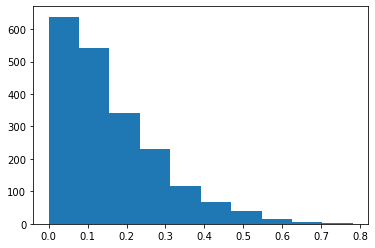

In [107]:
plt.hist(density_csr)

NameError: name 'title' is not defined

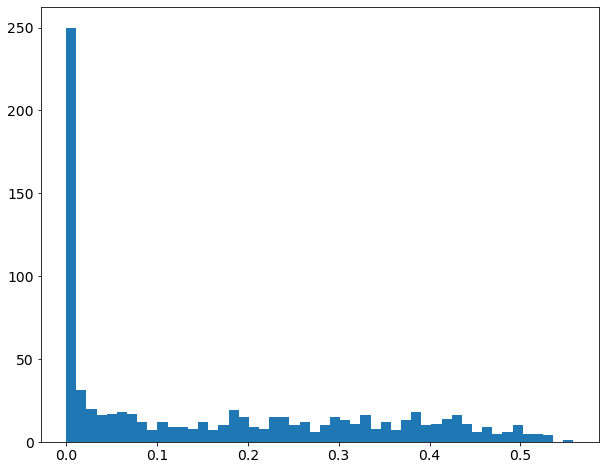

In [71]:
plt.figure(figsize = (10,8))
plt.hist(density, bins=50)
plt.title(title)
plt.axvline(x=noise_thrsh, label='T = ' + '%.3f'%(noise_thrsh), c='DarkOrange', linewidth=3)
plt.legend()
plt.show()